# General libraries

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
from pymatgen.core import periodic_table
import pymatgen.io.cif as cif
import pymatgen.analysis.ewald as ewald

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Dataset normalization

In [75]:
df = pd.read_csv('Var_01.csv')
df.sample(2)

# all need is POSCAR as input for future engineernig
df.drop(['energy_per_atom', 'formation_energy_per_atom', 'volume', 'nsites', 'unit_cell_formula', 'pretty_formula', 'is_hubbard', 'elements', 
 'nelements', 'e_above_hull', 'hubbards', 'is_compatible', 'spacegroup', 'task_ids', 'band_gap', 'density', 
 'icsd_id', 'icsd_ids',  'total_magnetization', 'material_id', 'oxide_type', 'tags', 'piezo', 'diel', 'full_formula'], axis='columns', inplace=True)
df.dropna(inplace=True)

In [76]:
# extract bulk moduli
df['bulk'] = df.elasticity.apply(lambda x: eval(x)['K_VRH'])
df

,energy,cif,elasticity,bulk
2,-15.580602,# generated using pymatgen\r\ndata_FeAg3\r\n_s...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0
4,-11.293552,# generated using pymatgen\r\ndata_AlFe\r\n_sy...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0
5,-41.981392,# generated using pymatgen\r\ndata_AlFe2\r\n_s...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0
7,-64.628769,# generated using pymatgen\r\ndata_Al6Fe\r\n_s...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0
9,-40.645991,# generated using pymatgen\r\ndata_Al3Fe\r\n_s...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0
...,...,...,...,...
550,-49.071885,# generated using pymatgen\r\ndata_YFe5\r\n_sy...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0
563,-25.278117,# generated using pymatgen\r\ndata_Zn13Fe\r\n_...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0
566,-51.810017,# generated using pymatgen\r\ndata_ZrFe2\r\n_s...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0
568,-51.939510,# generated using pymatgen\r\ndata_Zr2Fe\r\n_s...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0


In [77]:
# predicted value
pred_val = 'bulk'

---

# Data processing

In [78]:
def get_elem_props(elem):
    elem_props = {}
    elem_props['Z'] = periodic_table.Element(elem).Z
    elem_props['X'] = periodic_table.Element(elem).X
    elem_props['oxidation_states'] = periodic_table.Element(elem).oxidation_states
    elem_props['row'] = periodic_table.Element(elem).row
    elem_props['group'] = periodic_table.Element(elem).group
    elem_props['atomic_mass'] = periodic_table.Element(elem).atomic_mass
    elem_props['atomic_radius'] = periodic_table.Element(elem).atomic_radius
    elem_props['electrical_resistivity'] = periodic_table.Element(elem).electrical_resistivity
    elem_props['velocity_of_sound'] = periodic_table.Element(elem).velocity_of_sound
    elem_props['molar_volume'] = periodic_table.Element(elem).density_of_solid
    elem_props['thermal_conductivity'] = periodic_table.Element(elem).thermal_conductivity
    elem_props['melting_point'] = periodic_table.Element(elem).melting_point
    elem_props['average_ionic_radius'] = periodic_table.Element(elem).average_ionic_radius
    elem_props['average_cationic_radius'] = periodic_table.Element(elem).average_cationic_radius
    elem_props['average_anionic_radius'] = periodic_table.Element(elem).average_anionic_radius

    return elem_props

# Functions for the futures extracting

Extract pymatgen structure object from cif file as string

In [79]:
def get_struct(file_cif):
    imported_cif = cif.CifParser.from_string(file_cif) #; print(imported_cif)
    struct = imported_cif.get_structures()[0] #; print(struct)
    return struct

Function on Ewald summation as the convolutional layer for crystalline graph

$ E = \sum {\frac {F_1 \times F_2}{|r_i-r_j|}} $

In [80]:
def ewald_sum(struct):
    ew = ewald.EwaldSummation(struct, 
                         real_space_cut=None, 
                         recip_space_cut=None, 
                         eta=None, 
                         acc_factor=12.0, 
                         w=0.7071067811865475, 
                         compute_forces=False)
    
    return ew.total_energy

Charged structure is mandatory for Ewald summation procedure

We want to replace simple atomic oxidation states by another properties

In [81]:
def get_ox_dict(struct, prop):
    ox_dict={}
    for i in struct.species:
        try:
            ox_dict[str(i)] = round(get_elem_props(i)[prop])
        except Exception as e:
            ox_dict[str(i)] = np.nan
            print(e)
    return ox_dict

Then we need to get pymatgen.core.Structure obj. as the charged structure

In [82]:
def get_charged_struct(file_cif, ox_dict):
    imported_cif = cif.CifParser.from_string(file_cif)
    struct = imported_cif.get_structures()[0]
    try:
        struct.add_oxidation_state_by_element(ox_dict)
        return struct
    except Exception as e:
        print(e)
        return np.nan

Finally we can summarize previous functions to get a result of Ewald summation from one line of dataset

In [83]:
def get_ew(file_cif, p):
    struct = get_struct(file_cif)
    ox_dict = get_ox_dict(struct, p) #; print(ox_dict)
    charged_struct = get_charged_struct(file_cif, ox_dict) #; print(charged_struct)
    try:
        ew = ewald_sum(charged_struct) #; print(ew)
        return (ew*-1)
    except Exception as e:
        print(e)
        return np.nan

# Prepare raw futures

In [84]:
props = ['Z', 'X', 'row', 'group', 'atomic_mass', 'atomic_radius', 'thermal_conductivity', 'melting_point'] 

d = df.copy()

# instantiate progress
total = d.shape[0]

p_counter = 0
p_len = len(props) #; print(p_len)

for p in props:
    df_processed = pd.DataFrame()
    tmp = {}
    p_counter += 1
    progress = 0
    
    # cs corresponds to single cif as string
    for cs in d['cif']:
        f = get_ew(cs, p)
        tmp[p] = f
        df_processed = df_processed.append([tmp])
        
        # update progress
        progress += 1
        print(f'Property: {p_counter}/{p_len}, Progress: {progress}/{total} ', end='\r')
    
    d[p] = df_processed.values

d

C:\Users\User\Anaconda3\lib\site-packages\pymatgen\io\cif.py:1121: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


,energy,cif,elasticity,bulk,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,-15.580602,# generated using pymatgen\r\ndata_FeAg3\r\n_s...,"{'G_Reuss': -15.0, 'G_VRH': 8.0, 'G_Voigt': 32...",133.0,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,-11.293552,# generated using pymatgen\r\ndata_AlFe\r\n_sy...,"{'G_Reuss': 133.0, 'G_VRH': 75.0, 'G_Voigt': 1...",85.0,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,-41.981392,# generated using pymatgen\r\ndata_AlFe2\r\n_s...,"{'G_Reuss': 60.0, 'G_VRH': 60.0, 'G_Voigt': 61...",117.0,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,-64.628769,# generated using pymatgen\r\ndata_Al6Fe\r\n_s...,"{'G_Reuss': 53.0, 'G_VRH': 56.0, 'G_Voigt': 58...",106.0,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,-40.645991,# generated using pymatgen\r\ndata_Al3Fe\r\n_s...,"{'G_Reuss': 51.0, 'G_VRH': 53.0, 'G_Voigt': 55...",125.0,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
550,-49.071885,# generated using pymatgen\r\ndata_YFe5\r\n_sy...,"{'G_Reuss': 67.0, 'G_VRH': 68.0, 'G_Voigt': 68...",105.0,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,-25.278117,# generated using pymatgen\r\ndata_Zn13Fe\r\n_...,"{'G_Reuss': 41.0, 'G_VRH': 42.0, 'G_Voigt': 43...",86.0,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,-51.810017,# generated using pymatgen\r\ndata_ZrFe2\r\n_s...,"{'G_Reuss': 71.0, 'G_VRH': 72.0, 'G_Voigt': 73...",147.0,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,-51.939510,# generated using pymatgen\r\ndata_Zr2Fe\r\n_s...,"{'G_Reuss': 30.0, 'G_VRH': 32.0, 'G_Voigt': 35...",124.0,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


---

# Prepare data for ML

## Futures vectors

In [85]:
X = d.drop([pred_val, 'cif', 'energy', 'elasticity'], axis='columns')
X

,Z,X,row,group,atomic_mass,atomic_radius,thermal_conductivity,melting_point
2,57852.650775,129.645511,734.360152,3432.926361,300836.795955,102.338288,4.179167e+06,6.265616e+07
4,6565.698759,66.955974,206.240223,1875.162860,29827.463753,16.738993,4.437626e+05,3.242468e+07
5,25192.936144,212.452261,711.473010,5187.643400,115432.296957,53.113065,1.082677e+06,1.235264e+08
7,26321.621835,465.916900,1148.850214,17909.716720,116162.691009,116.479225,5.524227e+06,1.331458e+08
9,19363.388311,277.985175,739.433491,9771.963342,86577.332135,69.496294,2.838873e+06,9.691046e+07
...,...,...,...,...,...,...,...,...
550,40763.889055,165.879825,875.630234,2545.030741,195788.722733,73.184669,2.417093e+05,1.626921e+08
563,104090.477476,470.185090,1880.740360,16279.030466,488350.069141,117.546273,1.627903e+06,7.206335e+07
566,49261.728460,141.726574,961.468778,2267.625191,241671.481189,97.129911,1.964479e+05,1.871750e+08
568,59135.945899,84.566149,1011.527079,1353.058377,299900.652345,135.623856,9.428701e+04,1.890790e+08


## Predicted values

In [86]:
y = d[pred_val].values.ravel()
print("The number of elements in the predicted value array ("+str(pred_val)+"):", str(y.shape[0]))

The number of elements in the predicted value array (bulk): 160


## Splitting into training and test samples

In [87]:
# Test samples fraction
test_size = 0.2

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
print("The ratio of the volumes of training/test samples: "+str(X_train.shape[0])+'/'+str(X_test.shape[0]))

The ratio of the volumes of training/test samples: 128/32


## Data normalization

In [89]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Check samples:")
X.shape, y.shape

Check samples:


((160, 8), (160,))

---

## Correlations analysis

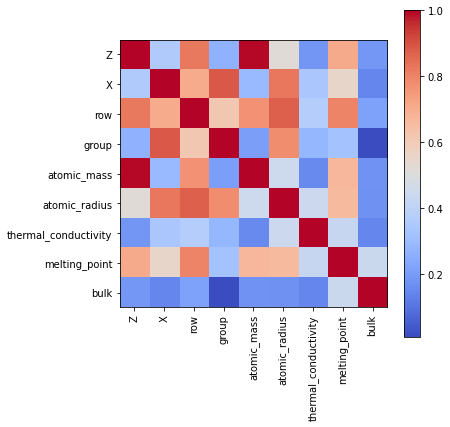

In [90]:
test_df = X.copy()
test_df[pred_val] = y
test_df

corr_matrix = test_df.corr()

plt.figure(figsize=(6,6))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()  # add color intensity map

plt.xticks(rotation=90)

plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.show()

Диаграмма корреляций прогнозируемой величины с величинами из набора векторов признаков:

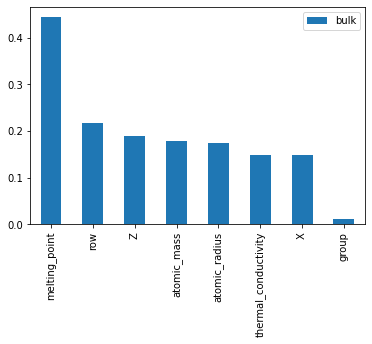

In [91]:
data_4_analysis = pd.DataFrame().append(X)
data_4_analysis[pred_val] = y

# bar plot
pd.DataFrame(data_4_analysis.corr()[pred_val]).\
             drop(index=[pred_val]).\
             sort_values(by=[pred_val], ascending=False).\
             plot(kind='bar')
plt.show()

---

# Regression models

Regression metric:

In [92]:
scoring='neg_mean_absolute_error'

*Other regression metrics from sklearn:*
- `explained_variance`
- `max_error`
- `neg_mean_absolute_error`
- `neg_mean_squared_error`
- `neg_root_mean_squared_error`
- `neg_mean_squared_log_error`
- `neg_median_absolute_error`
- `r2`
- `neg_mean_poisson_deviance`
- `neg_mean_gamma_deviance`
- `neg_mean_absolute_percentage_error`

In [93]:
res_table = pd.DataFrame()
tmp={}

## Linear regression

Cooresponding libraries

In [94]:
from sklearn.linear_model import LinearRegression

Функция построения графика $y_{pred}=f(y_{true})$ и отображения метрики $R^2$ в кросс-валидации:

In [95]:
def ex_plot(model_name, y_true, y_pred, scores):
    fig, ax = plt.subplots(figsize=(6,6))
    
    plt.plot(y_test, y_pred, 'o', label=str(scoring)+'(C-V) = '+str(round(scores,2)))
    
    max_dimension = max(y_test.max(), y_pred.max())
    min_dimension = min(y_test.min(), y_pred.min())
    
    x_line = [min_dimension, max_dimension]
    y_line = x_line
    
    plt.plot(x_line, y_line)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.legend()
    plt.title(model_name)
    
    plt.show()

---

Применение модели линейной регрессии:

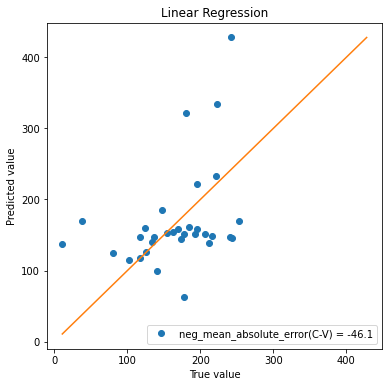

In [96]:
lr = LinearRegression()

''' MODEL FIT '''
lr.fit(X_train, y_train)
   
''' Cross-Validation '''
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring=scoring)

''' PLOT '''
ex_plot('Linear Regression', y_test, lr.predict(X_test), scores.mean())

tmp['model'] = 'lr'
tmp[scoring] = scores.mean()
res_table = res_table.append([tmp])

---

## kNN

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    1.6s finished


{'n_neighbors': 2}


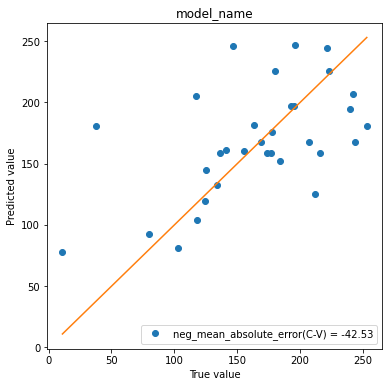

In [97]:
# Загрузка библиотек
from sklearn.neighbors import KNeighborsRegressor

# Инициализация модели МО:
model_knr = KNeighborsRegressor()

# Массив числа соседей для перебора
n_neighbors = np.arange(1,15,1) # from 1 to 10

# Определение сетки параметров
param_grid = {'n_neighbors': n_neighbors}

# Инициирование поиска по сетке параметров
gs = GridSearchCV(model_knr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

# Определение наилучшей параметризации
model_best = gs.best_estimator_ 
print(gs.best_params_)
ex_plot('model_name', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [98]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
knn_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'knn'
tmp[scoring] = knn_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## SVM

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:    2.3s finished


{'C': 1000, 'degree': 1, 'epsilon': 0.3, 'kernel': 'rbf', 'tol': 0.01}


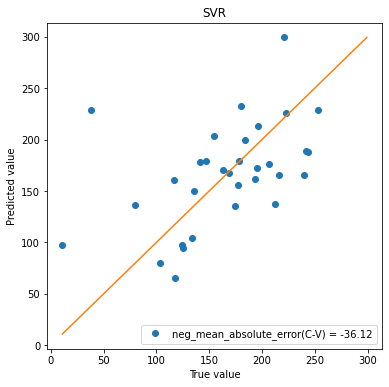

In [99]:
# Загрузка библиотек
from sklearn.svm import SVR

# Инициализация модели МО:
svr = SVR()

# Массив параметров для перебора
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [1,2,3,5]
tol = [0.001, 0.01]
C = [100, 1000]
epsilon = [0.2, 0.3, 0.5]

param_grid = {'kernel': kernel, 'degree' : degree, 'tol' : tol, 'C' : C, 'epsilon' : epsilon}

gs = GridSearchCV(svr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('SVR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').max())

In [100]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
svm_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'svm'
tmp[scoring] = svm_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## RFR

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   26.6s finished


{'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 0.001, 'n_estimators': 500}


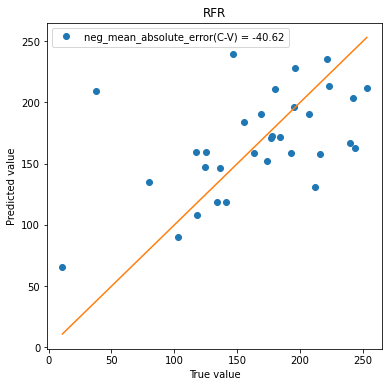

In [101]:
from sklearn.ensemble import RandomForestRegressor
RFR = RandomForestRegressor()

n_estimators = [300,500]
max_features = ['auto']
max_depth = [1,40,100]
min_samples_split = [0.0001,0.001,0.01]
min_samples_leaf = [1,2]
bootstrap = [True]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(RFR, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)

model_best = gs.best_estimator_
print(gs.best_params_)
ex_plot('RFR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())

In [102]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
rfr_res = results.sort_values(by='rank').set_index('rank')

tmp['model'] = 'rfr'
tmp[scoring] = rfr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

---

## GBR

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   22.7s finished


------------------------------
Параметры наилучшего варианта:
{'learning_rate': 0.1, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 0.1, 'n_estimators': 350}


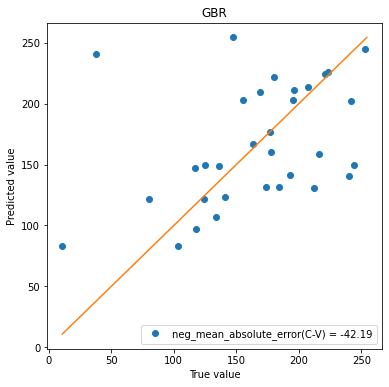

------------------------------


In [103]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

# Массивы значений параметров для поиска по сетке
learning_rate = [0.001, 0.01, 0.1]
n_estimators = [300,350]
min_samples_split = [0.001,0.01, 0.1]
min_samples_leaf = [1,2]
max_depth = [1,5,15]

param_grid = { 'learning_rate': learning_rate,
               'n_estimators': n_estimators,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_depth': max_depth}

gs = GridSearchCV(gbr, param_grid, cv = 5, verbose = 1, n_jobs=-1, scoring=scoring)
gs.fit(X_train, y_train)
model_best = gs.best_estimator_
print("------------------------------")
print("Параметры наилучшего варианта:")
print(gs.best_params_)
ex_plot('GBR', y_test, model_best.predict(X_test), gs.cv_results_.get('mean_test_score').mean())
print("------------------------------")

In [104]:
# Таблица результатов поиска по сетке параметров
results = pd.DataFrame()
results['params'] = gs.cv_results_.get('params')
results['scores'] = gs.cv_results_.get('mean_test_score')
results['rank'] = gs.cv_results_.get('rank_test_score')
gbr_res = results.sort_values(by='rank').set_index('rank').head(3)

tmp['model'] = 'gbr'
tmp[scoring] = gbr_res.head(1).scores.values[0]
res_table = res_table.append([tmp])

## Simple regressors summary

In [105]:
res_table

,model,neg_mean_absolute_error
0,lr,-46.097961
0,knn,-38.819692
0,svm,-36.116748
0,rfr,-34.784257
0,gbr,-32.707826


---

# Keras model

In [ ]:
# pre-requirements
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

# keras-tuner (general)
import tensorflow.keras as keras

# hyperparameter optimization algorithm
from kerastuner import Hyperband # OTHER MODULES: RandomSearch, BayesianOptimization

# easy calling
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

## Keras tuner part

In [107]:
inputdim = X.shape[1]

def build_model(hp):
    
    ''' trial parameters '''
    # model type selection
    model = Sequential()
        
    # model hyperparameters
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid'])
    optimizer_choice = hp.Choice('optimizer', values=['adam','rmsprop','SGD'])
    hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) 
    
    ''' ANN STRUCTURE '''
    # first h-layer
    model.add(Dense(units=hp.Int('layer_1', min_value=20, max_value=200, step=20),
                    input_dim=inputdim,
                    activation=activation_choice))
    
    # other h-layer 
    # optimized for perfomance
    for i in range(hp.Int('num_layers', 2, 4)):
        model.add(Dense(units=hp.Int('layer_' + str(i), min_value=20, max_value=100, step=20),
                        activation=activation_choice))
    
    # output layer
    model.add(Dense(1))
    
    ''' instantiate ANN '''
    model.compile(optimizer=optimizer_choice,
                  loss='MAE',
                  metrics=['MAE'])
    return model

In [111]:
tuner = Hyperband(build_model,
                  objective='val_MAE',
                  max_epochs=500, # for Hyperband only
                  #max_trials=20, # for BayesianOptimization & RandomSearch
                  directory='test_dir') #, # ATTENTION! path should be latin!!!!!!
                  #overwrite=True) # overwrite all previous models in specified directory

INFO:tensorflow:Reloading Oracle from existing project test_dir\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from test_dir\untitled_project\tuner0.json


In [112]:
tuner.search_space_summary()

In [113]:
tuner.search(X_train, y_train, 
             batch_size=200, # optimal batch size preselected
             # epochs=500,   # for BayesianOptimization & RandomSearch
             validation_split=0.2,
             verbose=2)

Epoch 1/3
1/1 - 0s - loss: 154.1013 - MAE: 154.1013 - val_loss: 143.0750 - val_MAE: 143.0750
Epoch 2/3
1/1 - 0s - loss: 154.0095 - MAE: 154.0095 - val_loss: 142.9832 - val_MAE: 142.9832
Epoch 3/3
1/1 - 0s - loss: 153.9177 - MAE: 153.9177 - val_loss: 142.8913 - val_MAE: 142.8913


Epoch 1/3
1/1 - 0s - loss: 154.0837 - MAE: 154.0837 - val_loss: 143.1259 - val_MAE: 143.1259
Epoch 2/3
1/1 - 0s - loss: 154.0587 - MAE: 154.0587 - val_loss: 143.1003 - val_MAE: 143.1003
Epoch 3/3
1/1 - 0s - loss: 154.0330 - MAE: 154.0330 - val_loss: 143.0741 - val_MAE: 143.0741


Epoch 1/3
1/1 - 0s - loss: 154.2884 - MAE: 154.2884 - val_loss: 143.1795 - val_MAE: 143.1795
Epoch 2/3
1/1 - 0s - loss: 154.1138 - MAE: 154.1138 - val_loss: 143.0050 - val_MAE: 143.0050
Epoch 3/3
1/1 - 0s - loss: 153.9393 - MAE: 153.9393 - val_loss: 142.8305 - val_MAE: 142.8305


Epoch 1/3
1/1 - 0s - loss: 153.8625 - MAE: 153.8625 - val_loss: 142.8026 - val_MAE: 142.8026
Epoch 2/3
1/1 - 0s - loss: 153.7370 - MAE: 153.7370 - val_loss: 142.6769 - val_MAE: 142.6769
Epoch 3/3
1/1 - 0s - loss: 153.6113 - MAE: 153.6113 - val_loss: 142.5510 - val_MAE: 142.5510


Epoch 1/3
1/1 - 0s - loss: 154.0786 - MAE: 154.0786 - val_loss: 143.1167 - val_MAE: 143.1167
Epoch 2/3
1/1 - 0s - loss: 154.0531 - MAE: 154.0531 - val_loss: 143.0898 - val_MAE: 143.0898
Epoch 3/3
1/1 - 0s - loss: 154.0271 - MAE: 154.0271 - val_loss: 143.0597 - val_MAE: 143.0597


Epoch 1/3
1/1 - 0s - loss: 154.1044 - MAE: 154.1044 - val_loss: 143.1468 - val_MAE: 143.1468
Epoch 2/3
1/1 - 0s - loss: 154.0793 - MAE: 154.0793 - val_loss: 143.1232 - val_MAE: 143.1232
Epoch 3/3
1/1 - 0s - loss: 154.0561 - MAE: 154.0561 - val_loss: 143.1006 - val_MAE: 143.1006


Epoch 1/3
1/1 - 0s - loss: 154.1123 - MAE: 154.1123 - val_loss: 143.1078 - val_MAE: 143.1078
Epoch 2/3
1/1 - 0s - loss: 154.0426 - MAE: 154.0426 - val_loss: 143.0412 - val_MAE: 143.0412
Epoch 3/3
1/1 - 0s - loss: 153.9811 - MAE: 153.9811 - val_loss: 142.9704 - val_MAE: 142.9704


Epoch 1/3
1/1 - 0s - loss: 154.0736 - MAE: 154.0736 - val_loss: 143.1190 - val_MAE: 143.1190
Epoch 2/3
1/1 - 0s - loss: 154.0541 - MAE: 154.0541 - val_loss: 143.0987 - val_MAE: 143.0987
Epoch 3/3
1/1 - 0s - loss: 154.0339 - MAE: 154.0339 - val_loss: 143.0774 - val_MAE: 143.0774


Epoch 1/3
1/1 - 0s - loss: 154.0867 - MAE: 154.0867 - val_loss: 143.1284 - val_MAE: 143.1284
Epoch 2/3
1/1 - 0s - loss: 154.0636 - MAE: 154.0636 - val_loss: 143.1068 - val_MAE: 143.1068
Epoch 3/3
1/1 - 0s - loss: 154.0423 - MAE: 154.0423 - val_loss: 143.0856 - val_MAE: 143.0856


Epoch 1/3
1/1 - 0s - loss: 154.0881 - MAE: 154.0881 - val_loss: 143.1402 - val_MAE: 143.1402
Epoch 2/3
1/1 - 0s - loss: 154.0760 - MAE: 154.0760 - val_loss: 143.1261 - val_MAE: 143.1261
Epoch 3/3
1/1 - 0s - loss: 154.0624 - MAE: 154.0624 - val_loss: 143.1113 - val_MAE: 143.1113


Epoch 1/3
1/1 - 0s - loss: 154.0750 - MAE: 154.0750 - val_loss: 143.1194 - val_MAE: 143.1194
Epoch 2/3
1/1 - 0s - loss: 154.0562 - MAE: 154.0562 - val_loss: 143.1006 - val_MAE: 143.1006
Epoch 3/3
1/1 - 0s - loss: 154.0388 - MAE: 154.0388 - val_loss: 143.0813 - val_MAE: 143.0813


Epoch 1/3
1/1 - 0s - loss: 154.1001 - MAE: 154.1001 - val_loss: 143.1023 - val_MAE: 143.1023
Epoch 2/3
1/1 - 0s - loss: 154.0390 - MAE: 154.0390 - val_loss: 143.0228 - val_MAE: 143.0228
Epoch 3/3
1/1 - 0s - loss: 153.9662 - MAE: 153.9662 - val_loss: 142.9150 - val_MAE: 142.9150


Epoch 1/3
1/1 - 0s - loss: 153.4438 - MAE: 153.4438 - val_loss: 142.2142 - val_MAE: 142.2142
Epoch 2/3
1/1 - 0s - loss: 153.1486 - MAE: 153.1486 - val_loss: 141.9205 - val_MAE: 141.9205
Epoch 3/3
1/1 - 0s - loss: 152.8549 - MAE: 152.8549 - val_loss: 141.6295 - val_MAE: 141.6295


Epoch 1/3
1/1 - 0s - loss: 154.0900 - MAE: 154.0900 - val_loss: 143.1292 - val_MAE: 143.1292
Epoch 2/3
1/1 - 0s - loss: 154.0655 - MAE: 154.0655 - val_loss: 143.1063 - val_MAE: 143.1063
Epoch 3/3
1/1 - 0s - loss: 154.0430 - MAE: 154.0430 - val_loss: 143.0836 - val_MAE: 143.0836


Epoch 1/3
1/1 - 0s - loss: 154.0719 - MAE: 154.0719 - val_loss: 143.0462 - val_MAE: 143.0462
Epoch 2/3
1/1 - 0s - loss: 153.9873 - MAE: 153.9873 - val_loss: 142.9386 - val_MAE: 142.9386
Epoch 3/3
1/1 - 0s - loss: 153.8873 - MAE: 153.8873 - val_loss: 142.8130 - val_MAE: 142.8130


Epoch 1/3
1/1 - 0s - loss: 154.8526 - MAE: 154.8526 - val_loss: 143.8306 - val_MAE: 143.8306
Epoch 2/3
1/1 - 0s - loss: 154.7650 - MAE: 154.7650 - val_loss: 143.7432 - val_MAE: 143.7432
Epoch 3/3
1/1 - 0s - loss: 154.6776 - MAE: 154.6776 - val_loss: 143.6561 - val_MAE: 143.6561


Epoch 1/3
1/1 - 0s - loss: 154.0875 - MAE: 154.0875 - val_loss: 143.1377 - val_MAE: 143.1377
Epoch 2/3
1/1 - 0s - loss: 154.0732 - MAE: 154.0732 - val_loss: 143.1227 - val_MAE: 143.1227
Epoch 3/3
1/1 - 0s - loss: 154.0590 - MAE: 154.0590 - val_loss: 143.1072 - val_MAE: 143.1072


Epoch 1/3
1/1 - 0s - loss: 154.0319 - MAE: 154.0319 - val_loss: 143.0672 - val_MAE: 143.0672
Epoch 2/3
1/1 - 0s - loss: 154.0028 - MAE: 154.0028 - val_loss: 143.0366 - val_MAE: 143.0366
Epoch 3/3
1/1 - 0s - loss: 153.9727 - MAE: 153.9727 - val_loss: 143.0058 - val_MAE: 143.0058


Epoch 1/3
1/1 - 0s - loss: 153.3554 - MAE: 153.3554 - val_loss: 142.1121 - val_MAE: 142.1121
Epoch 2/3
1/1 - 0s - loss: 153.0466 - MAE: 153.0466 - val_loss: 141.8034 - val_MAE: 141.8034
Epoch 3/3
1/1 - 0s - loss: 152.7379 - MAE: 152.7379 - val_loss: 141.4949 - val_MAE: 141.4949


Epoch 1/3
1/1 - 0s - loss: 154.0883 - MAE: 154.0883 - val_loss: 143.1156 - val_MAE: 143.1156
Epoch 2/3
1/1 - 0s - loss: 154.0527 - MAE: 154.0527 - val_loss: 143.0819 - val_MAE: 143.0819
Epoch 3/3
1/1 - 0s - loss: 154.0211 - MAE: 154.0211 - val_loss: 143.0442 - val_MAE: 143.0442


Epoch 1/3
1/1 - 0s - loss: 153.5785 - MAE: 153.5785 - val_loss: 142.2684 - val_MAE: 142.2684
Epoch 2/3
1/1 - 0s - loss: 153.2028 - MAE: 153.2028 - val_loss: 141.9923 - val_MAE: 141.9923
Epoch 3/3
1/1 - 0s - loss: 152.9267 - MAE: 152.9267 - val_loss: 141.7574 - val_MAE: 141.7574


Epoch 1/3
1/1 - 0s - loss: 153.3372 - MAE: 153.3372 - val_loss: 142.2694 - val_MAE: 142.2694
Epoch 2/3
1/1 - 0s - loss: 153.2034 - MAE: 153.2034 - val_loss: 142.1354 - val_MAE: 142.1354
Epoch 3/3
1/1 - 0s - loss: 153.0694 - MAE: 153.0694 - val_loss: 142.0011 - val_MAE: 142.0011


Epoch 1/3
1/1 - 0s - loss: 153.0632 - MAE: 153.0632 - val_loss: 141.9837 - val_MAE: 141.9837
Epoch 2/3
1/1 - 0s - loss: 152.9181 - MAE: 152.9181 - val_loss: 141.8387 - val_MAE: 141.8387
Epoch 3/3
1/1 - 0s - loss: 152.7731 - MAE: 152.7731 - val_loss: 141.6941 - val_MAE: 141.6941


Epoch 1/3
1/1 - 0s - loss: 154.0460 - MAE: 154.0460 - val_loss: 143.0703 - val_MAE: 143.0703
Epoch 2/3
1/1 - 0s - loss: 154.0114 - MAE: 154.0114 - val_loss: 143.0335 - val_MAE: 143.0335
Epoch 3/3
1/1 - 0s - loss: 153.9764 - MAE: 153.9764 - val_loss: 142.9942 - val_MAE: 142.9942


Epoch 1/3
1/1 - 0s - loss: 156.4001 - MAE: 156.4001 - val_loss: 144.8217 - val_MAE: 144.8217
Epoch 2/3
1/1 - 0s - loss: 155.7561 - MAE: 155.7561 - val_loss: 144.3637 - val_MAE: 144.3637
Epoch 3/3
1/1 - 0s - loss: 155.2982 - MAE: 155.2982 - val_loss: 143.9851 - val_MAE: 143.9851


Epoch 1/3
1/1 - 0s - loss: 154.0837 - MAE: 154.0837 - val_loss: 143.1036 - val_MAE: 143.1036
Epoch 2/3
1/1 - 0s - loss: 154.0376 - MAE: 154.0376 - val_loss: 143.0441 - val_MAE: 143.0441
Epoch 3/3
1/1 - 0s - loss: 153.9785 - MAE: 153.9785 - val_loss: 142.9735 - val_MAE: 142.9735


Epoch 1/3
1/1 - 0s - loss: 154.2175 - MAE: 154.2175 - val_loss: 142.9661 - val_MAE: 142.9661
Epoch 2/3
1/1 - 0s - loss: 153.9005 - MAE: 153.9005 - val_loss: 142.6489 - val_MAE: 142.6489
Epoch 3/3
1/1 - 0s - loss: 153.5834 - MAE: 153.5834 - val_loss: 142.3316 - val_MAE: 142.3316


Epoch 1/3
1/1 - 0s - loss: 154.0493 - MAE: 154.0493 - val_loss: 143.0627 - val_MAE: 143.0627
Epoch 2/3
1/1 - 0s - loss: 154.0043 - MAE: 154.0043 - val_loss: 143.0122 - val_MAE: 143.0122
Epoch 3/3
1/1 - 0s - loss: 153.9571 - MAE: 153.9571 - val_loss: 142.9562 - val_MAE: 142.9562


Epoch 1/3
1/1 - 0s - loss: 154.0938 - MAE: 154.0938 - val_loss: 143.1213 - val_MAE: 143.1213
Epoch 2/3
1/1 - 0s - loss: 154.0602 - MAE: 154.0602 - val_loss: 143.0889 - val_MAE: 143.0889
Epoch 3/3
1/1 - 0s - loss: 154.0304 - MAE: 154.0304 - val_loss: 143.0578 - val_MAE: 143.0578


Epoch 1/3
1/1 - 0s - loss: 155.1358 - MAE: 155.1358 - val_loss: 144.0090 - val_MAE: 144.0090
Epoch 2/3
1/1 - 0s - loss: 154.9434 - MAE: 154.9434 - val_loss: 143.8175 - val_MAE: 143.8175
Epoch 3/3
1/1 - 0s - loss: 154.7518 - MAE: 154.7518 - val_loss: 143.6267 - val_MAE: 143.6267


Epoch 1/3
1/1 - 0s - loss: 153.0589 - MAE: 153.0589 - val_loss: 141.9993 - val_MAE: 141.9993
Epoch 2/3
1/1 - 0s - loss: 152.9337 - MAE: 152.9337 - val_loss: 141.8740 - val_MAE: 141.8740
Epoch 3/3
1/1 - 0s - loss: 152.8084 - MAE: 152.8084 - val_loss: 141.7485 - val_MAE: 141.7485


Epoch 1/3
1/1 - 0s - loss: 154.0693 - MAE: 154.0693 - val_loss: 143.0047 - val_MAE: 143.0047
Epoch 2/3
1/1 - 0s - loss: 153.9543 - MAE: 153.9543 - val_loss: 142.8766 - val_MAE: 142.8766
Epoch 3/3
1/1 - 0s - loss: 153.8371 - MAE: 153.8371 - val_loss: 142.7233 - val_MAE: 142.7233


Epoch 1/3
1/1 - 0s - loss: 154.0598 - MAE: 154.0598 - val_loss: 143.0108 - val_MAE: 143.0108
Epoch 2/3
1/1 - 0s - loss: 153.9545 - MAE: 153.9545 - val_loss: 142.8905 - val_MAE: 142.8905
Epoch 3/3
1/1 - 0s - loss: 153.8399 - MAE: 153.8399 - val_loss: 142.7472 - val_MAE: 142.7472


Epoch 1/3
1/1 - 0s - loss: 154.0577 - MAE: 154.0577 - val_loss: 143.0212 - val_MAE: 143.0212
Epoch 2/3
1/1 - 0s - loss: 153.9625 - MAE: 153.9625 - val_loss: 142.9074 - val_MAE: 142.9074
Epoch 3/3
1/1 - 0s - loss: 153.8541 - MAE: 153.8541 - val_loss: 142.7727 - val_MAE: 142.7727


Epoch 1/3
1/1 - 0s - loss: 154.1036 - MAE: 154.1036 - val_loss: 143.1302 - val_MAE: 143.1302
Epoch 2/3
1/1 - 0s - loss: 154.0651 - MAE: 154.0651 - val_loss: 143.0875 - val_MAE: 143.0875
Epoch 3/3
1/1 - 0s - loss: 154.0253 - MAE: 154.0253 - val_loss: 143.0269 - val_MAE: 143.0269


Epoch 1/3
1/1 - 0s - loss: 154.1068 - MAE: 154.1068 - val_loss: 143.1512 - val_MAE: 143.1512
Epoch 2/3
1/1 - 0s - loss: 154.0845 - MAE: 154.0845 - val_loss: 143.1294 - val_MAE: 143.1294
Epoch 3/3
1/1 - 0s - loss: 154.0633 - MAE: 154.0633 - val_loss: 143.1086 - val_MAE: 143.1086


Epoch 1/3
1/1 - 0s - loss: 154.0860 - MAE: 154.0860 - val_loss: 143.1230 - val_MAE: 143.1230
Epoch 2/3
1/1 - 0s - loss: 154.0576 - MAE: 154.0576 - val_loss: 143.0970 - val_MAE: 143.0970
Epoch 3/3
1/1 - 0s - loss: 154.0313 - MAE: 154.0313 - val_loss: 143.0699 - val_MAE: 143.0699


Epoch 1/3
1/1 - 0s - loss: 154.0730 - MAE: 154.0730 - val_loss: 143.1046 - val_MAE: 143.1046
Epoch 2/3
1/1 - 0s - loss: 154.0431 - MAE: 154.0431 - val_loss: 143.0717 - val_MAE: 143.0717
Epoch 3/3
1/1 - 0s - loss: 154.0125 - MAE: 154.0125 - val_loss: 143.0373 - val_MAE: 143.0373


Epoch 1/3
1/1 - 0s - loss: 154.9338 - MAE: 154.9338 - val_loss: 142.9204 - val_MAE: 142.9204
Epoch 2/3
1/1 - 0s - loss: 153.8548 - MAE: 153.8548 - val_loss: 142.1605 - val_MAE: 142.1605
Epoch 3/3
1/1 - 0s - loss: 153.0950 - MAE: 153.0950 - val_loss: 141.5482 - val_MAE: 141.5482


Epoch 1/3
1/1 - 0s - loss: 154.4582 - MAE: 154.4582 - val_loss: 143.3004 - val_MAE: 143.3004
Epoch 2/3
1/1 - 0s - loss: 154.2348 - MAE: 154.2348 - val_loss: 143.0772 - val_MAE: 143.0772
Epoch 3/3
1/1 - 0s - loss: 154.0116 - MAE: 154.0116 - val_loss: 142.8540 - val_MAE: 142.8540


Epoch 1/3
1/1 - 0s - loss: 154.0834 - MAE: 154.0834 - val_loss: 143.1270 - val_MAE: 143.1270
Epoch 2/3
1/1 - 0s - loss: 154.0631 - MAE: 154.0631 - val_loss: 143.1047 - val_MAE: 143.1047
Epoch 3/3
1/1 - 0s - loss: 154.0415 - MAE: 154.0415 - val_loss: 143.0796 - val_MAE: 143.0796


Epoch 1/3
1/1 - 0s - loss: 155.0346 - MAE: 155.0346 - val_loss: 143.7384 - val_MAE: 143.7384
Epoch 2/3
1/1 - 0s - loss: 154.6728 - MAE: 154.6728 - val_loss: 143.3793 - val_MAE: 143.3793
Epoch 3/3
1/1 - 0s - loss: 154.3138 - MAE: 154.3138 - val_loss: 143.0242 - val_MAE: 143.0242


Epoch 1/3
1/1 - 0s - loss: 154.7515 - MAE: 154.7515 - val_loss: 143.7534 - val_MAE: 143.7534
Epoch 2/3
1/1 - 0s - loss: 154.6878 - MAE: 154.6878 - val_loss: 143.6899 - val_MAE: 143.6899
Epoch 3/3
1/1 - 0s - loss: 154.6243 - MAE: 154.6243 - val_loss: 143.6267 - val_MAE: 143.6267


Epoch 1/3
1/1 - 0s - loss: 154.1198 - MAE: 154.1198 - val_loss: 143.1537 - val_MAE: 143.1537
Epoch 2/3
1/1 - 0s - loss: 154.0918 - MAE: 154.0918 - val_loss: 143.1256 - val_MAE: 143.1256
Epoch 3/3
1/1 - 0s - loss: 154.0665 - MAE: 154.0665 - val_loss: 143.1004 - val_MAE: 143.1004


Epoch 1/3
1/1 - 0s - loss: 153.8418 - MAE: 153.8418 - val_loss: 142.5368 - val_MAE: 142.5368
Epoch 2/3
1/1 - 0s - loss: 153.4712 - MAE: 153.4712 - val_loss: 142.2730 - val_MAE: 142.2730
Epoch 3/3
1/1 - 0s - loss: 153.2074 - MAE: 153.2074 - val_loss: 142.0540 - val_MAE: 142.0540


Epoch 1/3
1/1 - 0s - loss: 154.1205 - MAE: 154.1205 - val_loss: 143.1564 - val_MAE: 143.1564
Epoch 2/3
1/1 - 0s - loss: 154.0905 - MAE: 154.0905 - val_loss: 143.1331 - val_MAE: 143.1331
Epoch 3/3
1/1 - 0s - loss: 154.0686 - MAE: 154.0686 - val_loss: 143.1140 - val_MAE: 143.1140


Epoch 1/3
1/1 - 0s - loss: 154.8909 - MAE: 154.8909 - val_loss: 143.2832 - val_MAE: 143.2832
Epoch 2/3
1/1 - 0s - loss: 154.2177 - MAE: 154.2177 - val_loss: 142.7955 - val_MAE: 142.7955
Epoch 3/3
1/1 - 0s - loss: 153.7299 - MAE: 153.7299 - val_loss: 142.3763 - val_MAE: 142.3763


Epoch 1/3
1/1 - 0s - loss: 154.0903 - MAE: 154.0903 - val_loss: 143.1155 - val_MAE: 143.1155
Epoch 2/3
1/1 - 0s - loss: 154.0496 - MAE: 154.0496 - val_loss: 143.0734 - val_MAE: 143.0734
Epoch 3/3
1/1 - 0s - loss: 154.0100 - MAE: 154.0100 - val_loss: 143.0299 - val_MAE: 143.0299


Epoch 1/3
1/1 - 0s - loss: 153.8133 - MAE: 153.8133 - val_loss: 142.6568 - val_MAE: 142.6568
Epoch 2/3
1/1 - 0s - loss: 153.5911 - MAE: 153.5911 - val_loss: 142.4344 - val_MAE: 142.4344
Epoch 3/3
1/1 - 0s - loss: 153.3688 - MAE: 153.3688 - val_loss: 142.2117 - val_MAE: 142.2117


Epoch 1/3
1/1 - 0s - loss: 154.0880 - MAE: 154.0880 - val_loss: 143.1304 - val_MAE: 143.1304
Epoch 2/3
1/1 - 0s - loss: 154.0670 - MAE: 154.0670 - val_loss: 143.1114 - val_MAE: 143.1114
Epoch 3/3
1/1 - 0s - loss: 154.0494 - MAE: 154.0494 - val_loss: 143.0905 - val_MAE: 143.0905


Epoch 1/3
1/1 - 0s - loss: 154.0898 - MAE: 154.0898 - val_loss: 142.8708 - val_MAE: 142.8708
Epoch 2/3
1/1 - 0s - loss: 153.8052 - MAE: 153.8052 - val_loss: 142.6612 - val_MAE: 142.6612
Epoch 3/3
1/1 - 0s - loss: 153.5955 - MAE: 153.5955 - val_loss: 142.4830 - val_MAE: 142.4830


Epoch 1/3
1/1 - 0s - loss: 154.7388 - MAE: 154.7388 - val_loss: 143.6922 - val_MAE: 143.6922
Epoch 2/3
1/1 - 0s - loss: 154.6265 - MAE: 154.6265 - val_loss: 143.5797 - val_MAE: 143.5797
Epoch 3/3
1/1 - 0s - loss: 154.5141 - MAE: 154.5141 - val_loss: 143.4671 - val_MAE: 143.4671


Epoch 1/3
1/1 - 0s - loss: 154.0959 - MAE: 154.0959 - val_loss: 143.1422 - val_MAE: 143.1422
Epoch 2/3
1/1 - 0s - loss: 154.0750 - MAE: 154.0750 - val_loss: 143.1224 - val_MAE: 143.1224
Epoch 3/3
1/1 - 0s - loss: 154.0552 - MAE: 154.0552 - val_loss: 143.1026 - val_MAE: 143.1026


Epoch 1/3
1/1 - 0s - loss: 152.6662 - MAE: 152.6662 - val_loss: 141.5060 - val_MAE: 141.5060
Epoch 2/3
1/1 - 0s - loss: 152.4404 - MAE: 152.4404 - val_loss: 141.2793 - val_MAE: 141.2793
Epoch 3/3
1/1 - 0s - loss: 152.2137 - MAE: 152.2137 - val_loss: 141.0595 - val_MAE: 141.0595


Epoch 1/3
1/1 - 0s - loss: 154.0682 - MAE: 154.0682 - val_loss: 143.0642 - val_MAE: 143.0642
Epoch 2/3
1/1 - 0s - loss: 154.0030 - MAE: 154.0030 - val_loss: 142.9809 - val_MAE: 142.9809
Epoch 3/3
1/1 - 0s - loss: 153.9235 - MAE: 153.9235 - val_loss: 142.8705 - val_MAE: 142.8705


Epoch 1/3
1/1 - 0s - loss: 154.0814 - MAE: 154.0814 - val_loss: 143.1260 - val_MAE: 143.1260
Epoch 2/3
1/1 - 0s - loss: 154.0626 - MAE: 154.0626 - val_loss: 143.1096 - val_MAE: 143.1096
Epoch 3/3
1/1 - 0s - loss: 154.0462 - MAE: 154.0462 - val_loss: 143.0930 - val_MAE: 143.0930


Epoch 1/3
1/1 - 0s - loss: 153.0996 - MAE: 153.0996 - val_loss: 141.7501 - val_MAE: 141.7501
Epoch 2/3
1/1 - 0s - loss: 152.6844 - MAE: 152.6844 - val_loss: 141.4453 - val_MAE: 141.4453
Epoch 3/3
1/1 - 0s - loss: 152.3796 - MAE: 152.3796 - val_loss: 141.1903 - val_MAE: 141.1903


Epoch 1/3
1/1 - 0s - loss: 152.6886 - MAE: 152.6886 - val_loss: 141.5614 - val_MAE: 141.5614
Epoch 2/3
1/1 - 0s - loss: 152.4957 - MAE: 152.4957 - val_loss: 141.3678 - val_MAE: 141.3678
Epoch 3/3
1/1 - 0s - loss: 152.3021 - MAE: 152.3021 - val_loss: 141.1735 - val_MAE: 141.1735


Epoch 1/3
1/1 - 0s - loss: 154.7040 - MAE: 154.7040 - val_loss: 143.6519 - val_MAE: 143.6519
Epoch 2/3
1/1 - 0s - loss: 154.5863 - MAE: 154.5863 - val_loss: 143.5345 - val_MAE: 143.5345
Epoch 3/3
1/1 - 0s - loss: 154.4689 - MAE: 154.4689 - val_loss: 143.4174 - val_MAE: 143.4174


Epoch 1/3
1/1 - 0s - loss: 153.9570 - MAE: 153.9570 - val_loss: 142.9587 - val_MAE: 142.9587
Epoch 2/3
1/1 - 0s - loss: 153.8931 - MAE: 153.8931 - val_loss: 142.8950 - val_MAE: 142.8950
Epoch 3/3
1/1 - 0s - loss: 153.8293 - MAE: 153.8293 - val_loss: 142.8313 - val_MAE: 142.8313


Epoch 1/3
1/1 - 0s - loss: 153.1115 - MAE: 153.1115 - val_loss: 141.9582 - val_MAE: 141.9582
Epoch 2/3
1/1 - 0s - loss: 152.8926 - MAE: 152.8926 - val_loss: 141.7402 - val_MAE: 141.7402
Epoch 3/3
1/1 - 0s - loss: 152.6746 - MAE: 152.6746 - val_loss: 141.5235 - val_MAE: 141.5235


Epoch 1/3
1/1 - 0s - loss: 153.8376 - MAE: 153.8376 - val_loss: 142.4437 - val_MAE: 142.4437
Epoch 2/3
1/1 - 0s - loss: 153.3781 - MAE: 153.3781 - val_loss: 142.1126 - val_MAE: 142.1126
Epoch 3/3
1/1 - 0s - loss: 153.0470 - MAE: 153.0470 - val_loss: 141.8276 - val_MAE: 141.8276


Epoch 1/3
1/1 - 0s - loss: 154.2391 - MAE: 154.2391 - val_loss: 143.0232 - val_MAE: 143.0232
Epoch 2/3
1/1 - 0s - loss: 153.9576 - MAE: 153.9576 - val_loss: 142.7418 - val_MAE: 142.7418
Epoch 3/3
1/1 - 0s - loss: 153.6762 - MAE: 153.6762 - val_loss: 142.4602 - val_MAE: 142.4602


Epoch 1/3
1/1 - 0s - loss: 154.0756 - MAE: 154.0756 - val_loss: 143.1177 - val_MAE: 143.1177
Epoch 2/3
1/1 - 0s - loss: 154.0541 - MAE: 154.0541 - val_loss: 143.0963 - val_MAE: 143.0963
Epoch 3/3
1/1 - 0s - loss: 154.0331 - MAE: 154.0331 - val_loss: 143.0744 - val_MAE: 143.0744


Epoch 1/3
1/1 - 0s - loss: 155.0200 - MAE: 155.0200 - val_loss: 143.8564 - val_MAE: 143.8564
Epoch 2/3
1/1 - 0s - loss: 154.7908 - MAE: 154.7908 - val_loss: 143.6907 - val_MAE: 143.6907
Epoch 3/3
1/1 - 0s - loss: 154.6251 - MAE: 154.6251 - val_loss: 143.5518 - val_MAE: 143.5518


Epoch 1/3
1/1 - 0s - loss: 154.5060 - MAE: 154.5060 - val_loss: 143.4038 - val_MAE: 143.4038
Epoch 2/3
1/1 - 0s - loss: 154.3383 - MAE: 154.3383 - val_loss: 143.2372 - val_MAE: 143.2372
Epoch 3/3
1/1 - 0s - loss: 154.1716 - MAE: 154.1716 - val_loss: 143.0716 - val_MAE: 143.0716


Epoch 1/3
1/1 - 0s - loss: 154.1058 - MAE: 154.1058 - val_loss: 143.1494 - val_MAE: 143.1494
Epoch 2/3
1/1 - 0s - loss: 154.0823 - MAE: 154.0823 - val_loss: 143.1279 - val_MAE: 143.1279
Epoch 3/3
1/1 - 0s - loss: 154.0612 - MAE: 154.0612 - val_loss: 143.1077 - val_MAE: 143.1077


Epoch 1/3
1/1 - 0s - loss: 154.0571 - MAE: 154.0571 - val_loss: 143.0955 - val_MAE: 143.0955
Epoch 2/3
1/1 - 0s - loss: 154.0342 - MAE: 154.0342 - val_loss: 143.0730 - val_MAE: 143.0730
Epoch 3/3
1/1 - 0s - loss: 154.0119 - MAE: 154.0119 - val_loss: 143.0506 - val_MAE: 143.0506


Epoch 1/3
1/1 - 0s - loss: 153.5017 - MAE: 153.5017 - val_loss: 142.4410 - val_MAE: 142.4410
Epoch 2/3
1/1 - 0s - loss: 153.3754 - MAE: 153.3754 - val_loss: 142.3145 - val_MAE: 142.3145
Epoch 3/3
1/1 - 0s - loss: 153.2489 - MAE: 153.2489 - val_loss: 142.1877 - val_MAE: 142.1877


Epoch 1/3
1/1 - 0s - loss: 155.4819 - MAE: 155.4819 - val_loss: 144.3713 - val_MAE: 144.3713
Epoch 2/3
1/1 - 0s - loss: 155.3057 - MAE: 155.3057 - val_loss: 144.2439 - val_MAE: 144.2439
Epoch 3/3
1/1 - 0s - loss: 155.1783 - MAE: 155.1783 - val_loss: 144.1378 - val_MAE: 144.1378


Epoch 1/3
1/1 - 0s - loss: 153.3859 - MAE: 153.3859 - val_loss: 142.2630 - val_MAE: 142.2630
Epoch 2/3
1/1 - 0s - loss: 153.1974 - MAE: 153.1974 - val_loss: 142.0749 - val_MAE: 142.0749
Epoch 3/3
1/1 - 0s - loss: 153.0092 - MAE: 153.0092 - val_loss: 141.8876 - val_MAE: 141.8876


Epoch 1/3
1/1 - 0s - loss: 153.5514 - MAE: 153.5514 - val_loss: 142.2811 - val_MAE: 142.2811
Epoch 2/3
1/1 - 0s - loss: 153.2154 - MAE: 153.2154 - val_loss: 141.9449 - val_MAE: 141.9449
Epoch 3/3
1/1 - 0s - loss: 152.8791 - MAE: 152.8791 - val_loss: 141.6083 - val_MAE: 141.6083


Epoch 1/3
1/1 - 0s - loss: 154.0873 - MAE: 154.0873 - val_loss: 143.1358 - val_MAE: 143.1358
Epoch 2/3
1/1 - 0s - loss: 154.0677 - MAE: 154.0677 - val_loss: 143.1153 - val_MAE: 143.1153
Epoch 3/3
1/1 - 0s - loss: 154.0482 - MAE: 154.0482 - val_loss: 143.0946 - val_MAE: 143.0946


Epoch 1/3
1/1 - 0s - loss: 154.0913 - MAE: 154.0913 - val_loss: 143.1474 - val_MAE: 143.1474
Epoch 2/3
1/1 - 0s - loss: 154.0814 - MAE: 154.0814 - val_loss: 143.1370 - val_MAE: 143.1370
Epoch 3/3
1/1 - 0s - loss: 154.0707 - MAE: 154.0707 - val_loss: 143.1212 - val_MAE: 143.1212


Epoch 1/3
1/1 - 0s - loss: 154.0846 - MAE: 154.0846 - val_loss: 143.1186 - val_MAE: 143.1186
Epoch 2/3
1/1 - 0s - loss: 154.0535 - MAE: 154.0535 - val_loss: 143.0835 - val_MAE: 143.0835
Epoch 3/3
1/1 - 0s - loss: 154.0194 - MAE: 154.0194 - val_loss: 143.0443 - val_MAE: 143.0443


Epoch 1/3
1/1 - 0s - loss: 154.0567 - MAE: 154.0567 - val_loss: 142.9684 - val_MAE: 142.9684
Epoch 2/3
1/1 - 0s - loss: 153.9027 - MAE: 153.9027 - val_loss: 142.8146 - val_MAE: 142.8146
Epoch 3/3
1/1 - 0s - loss: 153.7489 - MAE: 153.7489 - val_loss: 142.6609 - val_MAE: 142.6609


Epoch 1/3
1/1 - 0s - loss: 154.2436 - MAE: 154.2436 - val_loss: 142.7963 - val_MAE: 142.7963
Epoch 2/3
1/1 - 0s - loss: 153.7310 - MAE: 153.7310 - val_loss: 142.4171 - val_MAE: 142.4171
Epoch 3/3
1/1 - 0s - loss: 153.3518 - MAE: 153.3518 - val_loss: 142.0900 - val_MAE: 142.0900


Epoch 1/3
1/1 - 0s - loss: 154.0925 - MAE: 154.0925 - val_loss: 143.1156 - val_MAE: 143.1156
Epoch 2/3
1/1 - 0s - loss: 154.0510 - MAE: 154.0510 - val_loss: 143.0587 - val_MAE: 143.0587
Epoch 3/3
1/1 - 0s - loss: 153.9963 - MAE: 153.9963 - val_loss: 142.9741 - val_MAE: 142.9741


Epoch 1/3
1/1 - 0s - loss: 154.0935 - MAE: 154.0935 - val_loss: 143.1344 - val_MAE: 143.1344
Epoch 2/3
1/1 - 0s - loss: 154.0704 - MAE: 154.0704 - val_loss: 143.1114 - val_MAE: 143.1114
Epoch 3/3
1/1 - 0s - loss: 154.0487 - MAE: 154.0487 - val_loss: 143.0884 - val_MAE: 143.0884


Epoch 1/3
1/1 - 0s - loss: 153.5861 - MAE: 153.5861 - val_loss: 142.6016 - val_MAE: 142.6016
Epoch 2/3
1/1 - 0s - loss: 153.5360 - MAE: 153.5360 - val_loss: 142.5520 - val_MAE: 142.5520
Epoch 3/3
1/1 - 0s - loss: 153.4865 - MAE: 153.4865 - val_loss: 142.5031 - val_MAE: 142.5031


Epoch 1/3
1/1 - 0s - loss: 154.0985 - MAE: 154.0985 - val_loss: 143.1492 - val_MAE: 143.1492
Epoch 2/3
1/1 - 0s - loss: 154.0808 - MAE: 154.0808 - val_loss: 143.1317 - val_MAE: 143.1317
Epoch 3/3
1/1 - 0s - loss: 154.0634 - MAE: 154.0634 - val_loss: 143.1144 - val_MAE: 143.1144


Epoch 1/3
1/1 - 0s - loss: 154.1277 - MAE: 154.1277 - val_loss: 143.1484 - val_MAE: 143.1484
Epoch 2/3
1/1 - 0s - loss: 154.0774 - MAE: 154.0774 - val_loss: 143.1015 - val_MAE: 143.1015
Epoch 3/3
1/1 - 0s - loss: 154.0311 - MAE: 154.0311 - val_loss: 143.0542 - val_MAE: 143.0542


Epoch 1/3
1/1 - 0s - loss: 154.0817 - MAE: 154.0817 - val_loss: 143.1000 - val_MAE: 143.1000
Epoch 2/3
1/1 - 0s - loss: 154.0390 - MAE: 154.0390 - val_loss: 143.0530 - val_MAE: 143.0530
Epoch 3/3
1/1 - 0s - loss: 153.9964 - MAE: 153.9964 - val_loss: 143.0063 - val_MAE: 143.0063


Epoch 1/3
1/1 - 0s - loss: 154.0829 - MAE: 154.0829 - val_loss: 143.1369 - val_MAE: 143.1369
Epoch 2/3
1/1 - 0s - loss: 154.0709 - MAE: 154.0709 - val_loss: 143.1231 - val_MAE: 143.1231
Epoch 3/3
1/1 - 0s - loss: 154.0575 - MAE: 154.0575 - val_loss: 143.1071 - val_MAE: 143.1071


Epoch 1/3
1/1 - 0s - loss: 154.0997 - MAE: 154.0997 - val_loss: 143.1340 - val_MAE: 143.1340
Epoch 2/3
1/1 - 0s - loss: 154.0697 - MAE: 154.0697 - val_loss: 143.0960 - val_MAE: 143.0960
Epoch 3/3
1/1 - 0s - loss: 154.0322 - MAE: 154.0322 - val_loss: 143.0482 - val_MAE: 143.0482


Epoch 1/3
1/1 - 0s - loss: 154.1009 - MAE: 154.1009 - val_loss: 143.1192 - val_MAE: 143.1192
Epoch 2/3
1/1 - 0s - loss: 154.0566 - MAE: 154.0566 - val_loss: 143.0784 - val_MAE: 143.0784
Epoch 3/3
1/1 - 0s - loss: 154.0170 - MAE: 154.0170 - val_loss: 143.0246 - val_MAE: 143.0246


Epoch 1/3
1/1 - 0s - loss: 154.0608 - MAE: 154.0608 - val_loss: 143.0934 - val_MAE: 143.0934
Epoch 2/3
1/1 - 0s - loss: 154.0337 - MAE: 154.0337 - val_loss: 143.0631 - val_MAE: 143.0631
Epoch 3/3
1/1 - 0s - loss: 154.0034 - MAE: 154.0034 - val_loss: 143.0309 - val_MAE: 143.0309


Epoch 1/3
1/1 - 0s - loss: 154.0723 - MAE: 154.0723 - val_loss: 142.8193 - val_MAE: 142.8193
Epoch 2/3
1/1 - 0s - loss: 153.7536 - MAE: 153.7536 - val_loss: 142.5016 - val_MAE: 142.5016
Epoch 3/3
1/1 - 0s - loss: 153.4360 - MAE: 153.4360 - val_loss: 142.1868 - val_MAE: 142.1868


Epoch 1/3
1/1 - 0s - loss: 154.0936 - MAE: 154.0936 - val_loss: 143.1182 - val_MAE: 143.1182
Epoch 2/3
1/1 - 0s - loss: 154.0529 - MAE: 154.0529 - val_loss: 143.0770 - val_MAE: 143.0770
Epoch 3/3
1/1 - 0s - loss: 154.0145 - MAE: 154.0145 - val_loss: 143.0307 - val_MAE: 143.0307


Epoch 1/3
1/1 - 0s - loss: 155.4173 - MAE: 155.4173 - val_loss: 144.3320 - val_MAE: 144.3320
Epoch 2/3
1/1 - 0s - loss: 155.2664 - MAE: 155.2664 - val_loss: 144.1819 - val_MAE: 144.1819
Epoch 3/3
1/1 - 0s - loss: 155.1163 - MAE: 155.1163 - val_loss: 144.0325 - val_MAE: 144.0325


Epoch 1/3
1/1 - 0s - loss: 154.0927 - MAE: 154.0927 - val_loss: 143.1427 - val_MAE: 143.1427
Epoch 2/3
1/1 - 0s - loss: 154.0774 - MAE: 154.0774 - val_loss: 143.1277 - val_MAE: 143.1277
Epoch 3/3
1/1 - 0s - loss: 154.0627 - MAE: 154.0627 - val_loss: 143.1120 - val_MAE: 143.1120


Epoch 1/3
1/1 - 0s - loss: 153.6742 - MAE: 153.6742 - val_loss: 142.0136 - val_MAE: 142.0136
Epoch 2/3
1/1 - 0s - loss: 152.9481 - MAE: 152.9481 - val_loss: 141.4792 - val_MAE: 141.4792
Epoch 3/3
1/1 - 0s - loss: 152.4138 - MAE: 152.4138 - val_loss: 141.0342 - val_MAE: 141.0342


Epoch 1/3
1/1 - 0s - loss: 154.0897 - MAE: 154.0897 - val_loss: 143.0893 - val_MAE: 143.0893
Epoch 2/3
1/1 - 0s - loss: 154.0274 - MAE: 154.0274 - val_loss: 143.0379 - val_MAE: 143.0379
Epoch 3/3
1/1 - 0s - loss: 153.9782 - MAE: 153.9782 - val_loss: 142.9835 - val_MAE: 142.9835


Epoch 1/3
1/1 - 0s - loss: 153.3521 - MAE: 153.3521 - val_loss: 142.1678 - val_MAE: 142.1678
Epoch 2/3
1/1 - 0s - loss: 153.1022 - MAE: 153.1022 - val_loss: 141.9886 - val_MAE: 141.9886
Epoch 3/3
1/1 - 0s - loss: 152.9230 - MAE: 152.9230 - val_loss: 141.8370 - val_MAE: 141.8370


Epoch 1/3
1/1 - 0s - loss: 154.0843 - MAE: 154.0843 - val_loss: 143.1287 - val_MAE: 143.1287
Epoch 2/3
1/1 - 0s - loss: 154.0625 - MAE: 154.0625 - val_loss: 143.1074 - val_MAE: 143.1074
Epoch 3/3
1/1 - 0s - loss: 154.0413 - MAE: 154.0413 - val_loss: 143.0860 - val_MAE: 143.0860


Epoch 1/3
1/1 - 0s - loss: 154.0817 - MAE: 154.0817 - val_loss: 143.1241 - val_MAE: 143.1241
Epoch 2/3
1/1 - 0s - loss: 154.0556 - MAE: 154.0556 - val_loss: 143.0993 - val_MAE: 143.0993
Epoch 3/3
1/1 - 0s - loss: 154.0312 - MAE: 154.0312 - val_loss: 143.0762 - val_MAE: 143.0762


Epoch 1/3
1/1 - 0s - loss: 154.0715 - MAE: 154.0715 - val_loss: 143.1126 - val_MAE: 143.1126
Epoch 2/3
1/1 - 0s - loss: 154.0504 - MAE: 154.0504 - val_loss: 143.0916 - val_MAE: 143.0916
Epoch 3/3
1/1 - 0s - loss: 154.0294 - MAE: 154.0294 - val_loss: 143.0704 - val_MAE: 143.0704


Epoch 1/3
1/1 - 0s - loss: 154.0796 - MAE: 154.0796 - val_loss: 143.1201 - val_MAE: 143.1201
Epoch 2/3
1/1 - 0s - loss: 154.0540 - MAE: 154.0540 - val_loss: 143.0910 - val_MAE: 143.0910
Epoch 3/3
1/1 - 0s - loss: 154.0252 - MAE: 154.0252 - val_loss: 143.0572 - val_MAE: 143.0572


Epoch 1/3
1/1 - 0s - loss: 153.9102 - MAE: 153.9102 - val_loss: 142.6020 - val_MAE: 142.6020
Epoch 2/3
1/1 - 0s - loss: 153.5364 - MAE: 153.5364 - val_loss: 142.3382 - val_MAE: 142.3382
Epoch 3/3
1/1 - 0s - loss: 153.2726 - MAE: 153.2726 - val_loss: 142.1209 - val_MAE: 142.1209


Epoch 1/3
1/1 - 0s - loss: 154.0789 - MAE: 154.0789 - val_loss: 143.1095 - val_MAE: 143.1095
Epoch 2/3
1/1 - 0s - loss: 154.0458 - MAE: 154.0458 - val_loss: 143.0778 - val_MAE: 143.0778
Epoch 3/3
1/1 - 0s - loss: 154.0153 - MAE: 154.0153 - val_loss: 143.0449 - val_MAE: 143.0449


Epoch 1/3
1/1 - 0s - loss: 153.7757 - MAE: 153.7757 - val_loss: 142.6071 - val_MAE: 142.6071
Epoch 2/3
1/1 - 0s - loss: 153.5415 - MAE: 153.5415 - val_loss: 142.3728 - val_MAE: 142.3728
Epoch 3/3
1/1 - 0s - loss: 153.3072 - MAE: 153.3072 - val_loss: 142.1383 - val_MAE: 142.1383


Epoch 1/3
1/1 - 0s - loss: 152.6279 - MAE: 152.6279 - val_loss: 141.4616 - val_MAE: 141.4616
Epoch 2/3
1/1 - 0s - loss: 152.3960 - MAE: 152.3960 - val_loss: 141.2309 - val_MAE: 141.2309
Epoch 3/3
1/1 - 0s - loss: 152.1654 - MAE: 152.1654 - val_loss: 141.0133 - val_MAE: 141.0133


Epoch 1/3
1/1 - 0s - loss: 154.0566 - MAE: 154.0566 - val_loss: 143.0877 - val_MAE: 143.0877
Epoch 2/3
1/1 - 0s - loss: 154.0288 - MAE: 154.0288 - val_loss: 143.0560 - val_MAE: 143.0560
Epoch 3/3
1/1 - 0s - loss: 153.9994 - MAE: 153.9994 - val_loss: 143.0233 - val_MAE: 143.0233


Epoch 1/3
1/1 - 0s - loss: 154.0751 - MAE: 154.0751 - val_loss: 143.1207 - val_MAE: 143.1207
Epoch 2/3
1/1 - 0s - loss: 154.0544 - MAE: 154.0544 - val_loss: 143.1003 - val_MAE: 143.1003
Epoch 3/3
1/1 - 0s - loss: 154.0343 - MAE: 154.0343 - val_loss: 143.0802 - val_MAE: 143.0802


Epoch 1/3
1/1 - 0s - loss: 154.5667 - MAE: 154.5667 - val_loss: 143.4783 - val_MAE: 143.4783
Epoch 2/3
1/1 - 0s - loss: 154.4127 - MAE: 154.4127 - val_loss: 143.3246 - val_MAE: 143.3246
Epoch 3/3
1/1 - 0s - loss: 154.2590 - MAE: 154.2590 - val_loss: 143.1712 - val_MAE: 143.1712


Epoch 1/3
1/1 - 0s - loss: 155.5413 - MAE: 155.5413 - val_loss: 144.0430 - val_MAE: 144.0430
Epoch 2/3
1/1 - 0s - loss: 154.9775 - MAE: 154.9775 - val_loss: 143.6440 - val_MAE: 143.6440
Epoch 3/3
1/1 - 0s - loss: 154.5784 - MAE: 154.5784 - val_loss: 143.3157 - val_MAE: 143.3157


Epoch 1/3
1/1 - 0s - loss: 154.0690 - MAE: 154.0690 - val_loss: 143.0946 - val_MAE: 143.0946
Epoch 2/3
1/1 - 0s - loss: 154.0312 - MAE: 154.0312 - val_loss: 143.0517 - val_MAE: 143.0517
Epoch 3/3
1/1 - 0s - loss: 153.9886 - MAE: 153.9886 - val_loss: 143.0021 - val_MAE: 143.0021


Epoch 1/3
1/1 - 0s - loss: 154.1087 - MAE: 154.1087 - val_loss: 143.1022 - val_MAE: 143.1022
Epoch 2/3
1/1 - 0s - loss: 154.0386 - MAE: 154.0386 - val_loss: 143.0127 - val_MAE: 143.0127
Epoch 3/3
1/1 - 0s - loss: 153.9533 - MAE: 153.9533 - val_loss: 142.8929 - val_MAE: 142.8929


Epoch 1/3
1/1 - 0s - loss: 154.5586 - MAE: 154.5586 - val_loss: 143.2184 - val_MAE: 143.2184
Epoch 2/3
1/1 - 0s - loss: 154.1529 - MAE: 154.1529 - val_loss: 142.9208 - val_MAE: 142.9208
Epoch 3/3
1/1 - 0s - loss: 153.8553 - MAE: 153.8553 - val_loss: 142.6659 - val_MAE: 142.6659


Epoch 1/3
1/1 - 0s - loss: 153.4866 - MAE: 153.4866 - val_loss: 142.3929 - val_MAE: 142.3929
Epoch 2/3
1/1 - 0s - loss: 153.3273 - MAE: 153.3273 - val_loss: 142.2332 - val_MAE: 142.2332
Epoch 3/3
1/1 - 0s - loss: 153.1676 - MAE: 153.1676 - val_loss: 142.0734 - val_MAE: 142.0734


Epoch 1/3
1/1 - 0s - loss: 154.0733 - MAE: 154.0733 - val_loss: 143.1128 - val_MAE: 143.1128
Epoch 2/3
1/1 - 0s - loss: 154.0495 - MAE: 154.0495 - val_loss: 143.0888 - val_MAE: 143.0888
Epoch 3/3
1/1 - 0s - loss: 154.0258 - MAE: 154.0258 - val_loss: 143.0650 - val_MAE: 143.0650


Epoch 1/3
1/1 - 0s - loss: 154.0928 - MAE: 154.0928 - val_loss: 143.1129 - val_MAE: 143.1129
Epoch 2/3
1/1 - 0s - loss: 154.0477 - MAE: 154.0477 - val_loss: 143.0578 - val_MAE: 143.0578
Epoch 3/3
1/1 - 0s - loss: 153.9944 - MAE: 153.9944 - val_loss: 142.9901 - val_MAE: 142.9901


Epoch 1/3
1/1 - 0s - loss: 153.7170 - MAE: 153.7170 - val_loss: 141.9939 - val_MAE: 141.9939
Epoch 2/3
1/1 - 0s - loss: 152.9282 - MAE: 152.9282 - val_loss: 141.4313 - val_MAE: 141.4313
Epoch 3/3
1/1 - 0s - loss: 152.3657 - MAE: 152.3657 - val_loss: 140.9812 - val_MAE: 140.9812


Epoch 1/3
1/1 - 0s - loss: 154.0782 - MAE: 154.0782 - val_loss: 143.1314 - val_MAE: 143.1314
Epoch 2/3
1/1 - 0s - loss: 154.0622 - MAE: 154.0622 - val_loss: 143.1143 - val_MAE: 143.1143
Epoch 3/3
1/1 - 0s - loss: 154.0459 - MAE: 154.0459 - val_loss: 143.0969 - val_MAE: 143.0969


Epoch 1/3
1/1 - 0s - loss: 154.0783 - MAE: 154.0783 - val_loss: 143.0581 - val_MAE: 143.0581
Epoch 2/3
1/1 - 0s - loss: 154.0040 - MAE: 154.0040 - val_loss: 142.9777 - val_MAE: 142.9777
Epoch 3/3
1/1 - 0s - loss: 153.9310 - MAE: 153.9310 - val_loss: 142.8861 - val_MAE: 142.8861


Epoch 1/3
1/1 - 0s - loss: 154.0717 - MAE: 154.0717 - val_loss: 143.0436 - val_MAE: 143.0436
Epoch 2/3
1/1 - 0s - loss: 153.9844 - MAE: 153.9844 - val_loss: 142.9332 - val_MAE: 142.9332
Epoch 3/3
1/1 - 0s - loss: 153.8806 - MAE: 153.8806 - val_loss: 142.7874 - val_MAE: 142.7874


Epoch 1/3
1/1 - 0s - loss: 154.0802 - MAE: 154.0802 - val_loss: 143.0592 - val_MAE: 143.0592
Epoch 2/3
1/1 - 0s - loss: 153.9978 - MAE: 153.9978 - val_loss: 142.9470 - val_MAE: 142.9470
Epoch 3/3
1/1 - 0s - loss: 153.8937 - MAE: 153.8937 - val_loss: 142.7915 - val_MAE: 142.7915


Epoch 1/3
1/1 - 0s - loss: 153.2563 - MAE: 153.2563 - val_loss: 141.7810 - val_MAE: 141.7810
Epoch 2/3
1/1 - 0s - loss: 152.7153 - MAE: 152.7153 - val_loss: 141.3891 - val_MAE: 141.3891
Epoch 3/3
1/1 - 0s - loss: 152.3235 - MAE: 152.3235 - val_loss: 141.0674 - val_MAE: 141.0674


Epoch 1/3
1/1 - 0s - loss: 154.0946 - MAE: 154.0946 - val_loss: 143.1429 - val_MAE: 143.1429
Epoch 2/3
1/1 - 0s - loss: 154.0774 - MAE: 154.0774 - val_loss: 143.1254 - val_MAE: 143.1254
Epoch 3/3
1/1 - 0s - loss: 154.0608 - MAE: 154.0608 - val_loss: 143.1064 - val_MAE: 143.1064


Epoch 1/3
1/1 - 0s - loss: 154.0800 - MAE: 154.0800 - val_loss: 143.1201 - val_MAE: 143.1201
Epoch 2/3
1/1 - 0s - loss: 154.0506 - MAE: 154.0506 - val_loss: 143.0958 - val_MAE: 143.0958
Epoch 3/3
1/1 - 0s - loss: 154.0240 - MAE: 154.0240 - val_loss: 143.0687 - val_MAE: 143.0687


Epoch 1/3
1/1 - 0s - loss: 153.5945 - MAE: 153.5945 - val_loss: 142.6086 - val_MAE: 142.6086
Epoch 2/3
1/1 - 0s - loss: 153.5430 - MAE: 153.5430 - val_loss: 142.5571 - val_MAE: 142.5571
Epoch 3/3
1/1 - 0s - loss: 153.4915 - MAE: 153.4915 - val_loss: 142.5056 - val_MAE: 142.5056


Epoch 1/3
1/1 - 0s - loss: 154.0689 - MAE: 154.0689 - val_loss: 143.0750 - val_MAE: 143.0750
Epoch 2/3
1/1 - 0s - loss: 154.0186 - MAE: 154.0186 - val_loss: 143.0225 - val_MAE: 143.0225
Epoch 3/3
1/1 - 0s - loss: 153.9694 - MAE: 153.9694 - val_loss: 142.9616 - val_MAE: 142.9616


Epoch 1/3
1/1 - 0s - loss: 154.0882 - MAE: 154.0882 - val_loss: 143.1357 - val_MAE: 143.1357
Epoch 2/3
1/1 - 0s - loss: 154.0697 - MAE: 154.0697 - val_loss: 143.1179 - val_MAE: 143.1179
Epoch 3/3
1/1 - 0s - loss: 154.0520 - MAE: 154.0520 - val_loss: 143.0996 - val_MAE: 143.0996


Epoch 1/3
1/1 - 0s - loss: 154.0820 - MAE: 154.0820 - val_loss: 143.0465 - val_MAE: 143.0465
Epoch 2/3
1/1 - 0s - loss: 153.9886 - MAE: 153.9886 - val_loss: 142.9475 - val_MAE: 142.9475
Epoch 3/3
1/1 - 0s - loss: 153.8950 - MAE: 153.8950 - val_loss: 142.8170 - val_MAE: 142.8170


Epoch 1/3
1/1 - 0s - loss: 152.3008 - MAE: 152.3008 - val_loss: 140.7477 - val_MAE: 140.7477
Epoch 2/3
1/1 - 0s - loss: 151.6483 - MAE: 151.6483 - val_loss: 140.3018 - val_MAE: 140.3018
Epoch 3/3
1/1 - 0s - loss: 151.1653 - MAE: 151.1653 - val_loss: 139.9177 - val_MAE: 139.9177


Epoch 1/3
1/1 - 0s - loss: 154.0687 - MAE: 154.0687 - val_loss: 143.1023 - val_MAE: 143.1023
Epoch 2/3
1/1 - 0s - loss: 154.0453 - MAE: 154.0453 - val_loss: 143.0763 - val_MAE: 143.0763
Epoch 3/3
1/1 - 0s - loss: 154.0213 - MAE: 154.0213 - val_loss: 143.0492 - val_MAE: 143.0492


Epoch 1/3
1/1 - 0s - loss: 154.1556 - MAE: 154.1556 - val_loss: 143.0455 - val_MAE: 143.0455
Epoch 2/3
1/1 - 0s - loss: 153.9799 - MAE: 153.9799 - val_loss: 142.8705 - val_MAE: 142.8705
Epoch 3/3
1/1 - 0s - loss: 153.8049 - MAE: 153.8049 - val_loss: 142.6968 - val_MAE: 142.6968


Epoch 1/3
1/1 - 0s - loss: 154.0703 - MAE: 154.0703 - val_loss: 143.1023 - val_MAE: 143.1023
Epoch 2/3
1/1 - 0s - loss: 154.0412 - MAE: 154.0412 - val_loss: 143.0676 - val_MAE: 143.0676
Epoch 3/3
1/1 - 0s - loss: 154.0092 - MAE: 154.0092 - val_loss: 143.0305 - val_MAE: 143.0305


Epoch 1/3
1/1 - 0s - loss: 153.2472 - MAE: 153.2472 - val_loss: 142.1723 - val_MAE: 142.1723
Epoch 2/3
1/1 - 0s - loss: 153.1067 - MAE: 153.1067 - val_loss: 142.0704 - val_MAE: 142.0704
Epoch 3/3
1/1 - 0s - loss: 153.0047 - MAE: 153.0047 - val_loss: 141.9848 - val_MAE: 141.9848


Epoch 1/3
1/1 - 0s - loss: 154.1000 - MAE: 154.1000 - val_loss: 143.1234 - val_MAE: 143.1234
Epoch 2/3
1/1 - 0s - loss: 154.0584 - MAE: 154.0584 - val_loss: 143.0836 - val_MAE: 143.0836
Epoch 3/3
1/1 - 0s - loss: 154.0211 - MAE: 154.0211 - val_loss: 143.0433 - val_MAE: 143.0433


Epoch 1/3
1/1 - 0s - loss: 153.6849 - MAE: 153.6849 - val_loss: 142.5259 - val_MAE: 142.5259
Epoch 2/3
1/1 - 0s - loss: 153.4603 - MAE: 153.4603 - val_loss: 142.3009 - val_MAE: 142.3009
Epoch 3/3
1/1 - 0s - loss: 153.2353 - MAE: 153.2353 - val_loss: 142.0756 - val_MAE: 142.0756


Epoch 1/3
1/1 - 0s - loss: 154.3984 - MAE: 154.3984 - val_loss: 143.2776 - val_MAE: 143.2776
Epoch 2/3
1/1 - 0s - loss: 154.2122 - MAE: 154.2122 - val_loss: 143.1426 - val_MAE: 143.1426
Epoch 3/3
1/1 - 0s - loss: 154.0772 - MAE: 154.0772 - val_loss: 143.0291 - val_MAE: 143.0291


Epoch 1/3
1/1 - 0s - loss: 154.0784 - MAE: 154.0784 - val_loss: 143.1183 - val_MAE: 143.1183
Epoch 2/3
1/1 - 0s - loss: 154.0565 - MAE: 154.0565 - val_loss: 143.0958 - val_MAE: 143.0958
Epoch 3/3
1/1 - 0s - loss: 154.0344 - MAE: 154.0344 - val_loss: 143.0731 - val_MAE: 143.0731


Epoch 1/3
1/1 - 0s - loss: 154.5902 - MAE: 154.5902 - val_loss: 143.4514 - val_MAE: 143.4514
Epoch 2/3
1/1 - 0s - loss: 154.3858 - MAE: 154.3858 - val_loss: 143.2472 - val_MAE: 143.2472
Epoch 3/3
1/1 - 0s - loss: 154.1815 - MAE: 154.1815 - val_loss: 143.0431 - val_MAE: 143.0431


Epoch 1/3
1/1 - 0s - loss: 154.4239 - MAE: 154.4239 - val_loss: 143.1741 - val_MAE: 143.1741
Epoch 2/3
1/1 - 0s - loss: 154.1085 - MAE: 154.1085 - val_loss: 142.9496 - val_MAE: 142.9496
Epoch 3/3
1/1 - 0s - loss: 153.8840 - MAE: 153.8840 - val_loss: 142.7652 - val_MAE: 142.7652


Epoch 1/3
1/1 - 0s - loss: 154.1391 - MAE: 154.1391 - val_loss: 142.7571 - val_MAE: 142.7571
Epoch 2/3
1/1 - 0s - loss: 153.6915 - MAE: 153.6915 - val_loss: 142.4453 - val_MAE: 142.4453
Epoch 3/3
1/1 - 0s - loss: 153.3797 - MAE: 153.3797 - val_loss: 142.1948 - val_MAE: 142.1948


Epoch 1/3
1/1 - 0s - loss: 154.5740 - MAE: 154.5740 - val_loss: 143.5303 - val_MAE: 143.5303
Epoch 2/3
1/1 - 0s - loss: 154.4647 - MAE: 154.4647 - val_loss: 143.4210 - val_MAE: 143.4210
Epoch 3/3
1/1 - 0s - loss: 154.3554 - MAE: 154.3554 - val_loss: 143.3116 - val_MAE: 143.3116


Epoch 1/3
1/1 - 0s - loss: 154.1273 - MAE: 154.1273 - val_loss: 143.1156 - val_MAE: 143.1156
Epoch 2/3
1/1 - 0s - loss: 154.0520 - MAE: 154.0520 - val_loss: 143.0532 - val_MAE: 143.0532
Epoch 3/3
1/1 - 0s - loss: 153.9921 - MAE: 153.9921 - val_loss: 142.9781 - val_MAE: 142.9781


Epoch 1/3
1/1 - 0s - loss: 154.0920 - MAE: 154.0920 - val_loss: 143.1167 - val_MAE: 143.1167
Epoch 2/3
1/1 - 0s - loss: 154.0526 - MAE: 154.0526 - val_loss: 143.0773 - val_MAE: 143.0773
Epoch 3/3
1/1 - 0s - loss: 154.0139 - MAE: 154.0139 - val_loss: 143.0277 - val_MAE: 143.0277


Epoch 1/3
1/1 - 0s - loss: 153.7258 - MAE: 153.7258 - val_loss: 142.5030 - val_MAE: 142.5030
Epoch 2/3
1/1 - 0s - loss: 153.4374 - MAE: 153.4374 - val_loss: 142.2924 - val_MAE: 142.2924
Epoch 3/3
1/1 - 0s - loss: 153.2268 - MAE: 153.2268 - val_loss: 142.1142 - val_MAE: 142.1142


Epoch 1/3
1/1 - 0s - loss: 154.0994 - MAE: 154.0994 - val_loss: 143.1409 - val_MAE: 143.1409
Epoch 2/3
1/1 - 0s - loss: 154.0742 - MAE: 154.0742 - val_loss: 143.1184 - val_MAE: 143.1184
Epoch 3/3
1/1 - 0s - loss: 154.0519 - MAE: 154.0519 - val_loss: 143.0970 - val_MAE: 143.0970


Epoch 1/3
1/1 - 0s - loss: 154.0940 - MAE: 154.0940 - val_loss: 143.1382 - val_MAE: 143.1382
Epoch 2/3
1/1 - 0s - loss: 154.0716 - MAE: 154.0716 - val_loss: 143.1163 - val_MAE: 143.1163
Epoch 3/3
1/1 - 0s - loss: 154.0500 - MAE: 154.0500 - val_loss: 143.0952 - val_MAE: 143.0952


Epoch 1/3
1/1 - 0s - loss: 154.0690 - MAE: 154.0690 - val_loss: 142.9797 - val_MAE: 142.9797
Epoch 2/3
1/1 - 0s - loss: 153.9141 - MAE: 153.9141 - val_loss: 142.8247 - val_MAE: 142.8247
Epoch 3/3
1/1 - 0s - loss: 153.7591 - MAE: 153.7591 - val_loss: 142.6697 - val_MAE: 142.6697


Epoch 1/3
1/1 - 0s - loss: 154.0759 - MAE: 154.0759 - val_loss: 143.1249 - val_MAE: 143.1249
Epoch 2/3
1/1 - 0s - loss: 154.0646 - MAE: 154.0646 - val_loss: 143.1141 - val_MAE: 143.1141
Epoch 3/3
1/1 - 0s - loss: 154.0535 - MAE: 154.0535 - val_loss: 143.1028 - val_MAE: 143.1028


Epoch 1/3
1/1 - 0s - loss: 154.0866 - MAE: 154.0866 - val_loss: 143.0959 - val_MAE: 143.0959
Epoch 2/3
1/1 - 0s - loss: 154.0334 - MAE: 154.0334 - val_loss: 143.0334 - val_MAE: 143.0334
Epoch 3/3
1/1 - 0s - loss: 153.9747 - MAE: 153.9747 - val_loss: 142.9631 - val_MAE: 142.9631


Epoch 1/3
1/1 - 0s - loss: 154.7849 - MAE: 154.7849 - val_loss: 142.9269 - val_MAE: 142.9269
Epoch 2/3
1/1 - 0s - loss: 153.8615 - MAE: 153.8615 - val_loss: 142.2403 - val_MAE: 142.2403
Epoch 3/3
1/1 - 0s - loss: 153.1750 - MAE: 153.1750 - val_loss: 141.6433 - val_MAE: 141.6433


Epoch 1/3
1/1 - 0s - loss: 154.6098 - MAE: 154.6098 - val_loss: 143.4109 - val_MAE: 143.4109
Epoch 2/3
1/1 - 0s - loss: 154.3453 - MAE: 154.3453 - val_loss: 143.1466 - val_MAE: 143.1466
Epoch 3/3
1/1 - 0s - loss: 154.0811 - MAE: 154.0811 - val_loss: 142.8832 - val_MAE: 142.8832


Epoch 1/3
1/1 - 0s - loss: 154.0803 - MAE: 154.0803 - val_loss: 143.0520 - val_MAE: 143.0520
Epoch 2/3
1/1 - 0s - loss: 153.9921 - MAE: 153.9921 - val_loss: 142.9476 - val_MAE: 142.9476
Epoch 3/3
1/1 - 0s - loss: 153.8924 - MAE: 153.8924 - val_loss: 142.8116 - val_MAE: 142.8116


Epoch 1/3
1/1 - 0s - loss: 153.3155 - MAE: 153.3155 - val_loss: 142.1829 - val_MAE: 142.1829
Epoch 2/3
1/1 - 0s - loss: 153.1173 - MAE: 153.1173 - val_loss: 141.9842 - val_MAE: 141.9842
Epoch 3/3
1/1 - 0s - loss: 152.9186 - MAE: 152.9186 - val_loss: 141.7848 - val_MAE: 141.7848


Epoch 1/3
1/1 - 0s - loss: 154.0726 - MAE: 154.0726 - val_loss: 143.0984 - val_MAE: 143.0984
Epoch 2/3
1/1 - 0s - loss: 154.0410 - MAE: 154.0410 - val_loss: 143.0658 - val_MAE: 143.0658
Epoch 3/3
1/1 - 0s - loss: 154.0093 - MAE: 154.0093 - val_loss: 143.0336 - val_MAE: 143.0336


Epoch 1/3
1/1 - 0s - loss: 154.0883 - MAE: 154.0883 - val_loss: 143.1318 - val_MAE: 143.1318
Epoch 2/3
1/1 - 0s - loss: 154.0679 - MAE: 154.0679 - val_loss: 143.1113 - val_MAE: 143.1113
Epoch 3/3
1/1 - 0s - loss: 154.0484 - MAE: 154.0484 - val_loss: 143.0898 - val_MAE: 143.0898


Epoch 1/3
1/1 - 0s - loss: 153.6551 - MAE: 153.6551 - val_loss: 142.4630 - val_MAE: 142.4630
Epoch 2/3
1/1 - 0s - loss: 153.3974 - MAE: 153.3974 - val_loss: 142.2049 - val_MAE: 142.2049
Epoch 3/3
1/1 - 0s - loss: 153.1394 - MAE: 153.1394 - val_loss: 141.9464 - val_MAE: 141.9464


Epoch 1/3
1/1 - 0s - loss: 154.0630 - MAE: 154.0630 - val_loss: 143.1081 - val_MAE: 143.1081
Epoch 2/3
1/1 - 0s - loss: 154.0415 - MAE: 154.0415 - val_loss: 143.0867 - val_MAE: 143.0867
Epoch 3/3
1/1 - 0s - loss: 154.0202 - MAE: 154.0202 - val_loss: 143.0650 - val_MAE: 143.0650


Epoch 1/3
1/1 - 0s - loss: 153.8625 - MAE: 153.8625 - val_loss: 142.6641 - val_MAE: 142.6641
Epoch 2/3
1/1 - 0s - loss: 153.5985 - MAE: 153.5985 - val_loss: 142.3999 - val_MAE: 142.3999
Epoch 3/3
1/1 - 0s - loss: 153.3342 - MAE: 153.3342 - val_loss: 142.1353 - val_MAE: 142.1353


Epoch 1/3
1/1 - 0s - loss: 154.0965 - MAE: 154.0965 - val_loss: 143.1238 - val_MAE: 143.1238
Epoch 2/3
1/1 - 0s - loss: 154.0597 - MAE: 154.0597 - val_loss: 143.0744 - val_MAE: 143.0744
Epoch 3/3
1/1 - 0s - loss: 154.0125 - MAE: 154.0125 - val_loss: 143.0152 - val_MAE: 143.0152


Epoch 1/3
1/1 - 0s - loss: 154.0040 - MAE: 154.0040 - val_loss: 142.7397 - val_MAE: 142.7397
Epoch 2/3
1/1 - 0s - loss: 153.6742 - MAE: 153.6742 - val_loss: 142.4098 - val_MAE: 142.4098
Epoch 3/3
1/1 - 0s - loss: 153.3444 - MAE: 153.3444 - val_loss: 142.0798 - val_MAE: 142.0798


Epoch 1/3
1/1 - 0s - loss: 154.0674 - MAE: 154.0674 - val_loss: 143.0999 - val_MAE: 143.0999
Epoch 2/3
1/1 - 0s - loss: 154.0366 - MAE: 154.0366 - val_loss: 143.0659 - val_MAE: 143.0659
Epoch 3/3
1/1 - 0s - loss: 154.0046 - MAE: 154.0046 - val_loss: 143.0304 - val_MAE: 143.0304


Epoch 1/3
1/1 - 0s - loss: 153.7161 - MAE: 153.7161 - val_loss: 142.6399 - val_MAE: 142.6399
Epoch 2/3
1/1 - 0s - loss: 153.5742 - MAE: 153.5742 - val_loss: 142.4976 - val_MAE: 142.4976
Epoch 3/3
1/1 - 0s - loss: 153.4320 - MAE: 153.4320 - val_loss: 142.3550 - val_MAE: 142.3550


Epoch 1/3
1/1 - 0s - loss: 154.7049 - MAE: 154.7049 - val_loss: 143.1206 - val_MAE: 143.1206
Epoch 2/3
1/1 - 0s - loss: 154.0550 - MAE: 154.0550 - val_loss: 142.6439 - val_MAE: 142.6439
Epoch 3/3
1/1 - 0s - loss: 153.5783 - MAE: 153.5783 - val_loss: 142.2368 - val_MAE: 142.2368


Epoch 1/3
1/1 - 0s - loss: 154.7274 - MAE: 154.7274 - val_loss: 143.5058 - val_MAE: 143.5058
Epoch 2/3
1/1 - 0s - loss: 154.4402 - MAE: 154.4402 - val_loss: 143.2188 - val_MAE: 143.2188
Epoch 3/3
1/1 - 0s - loss: 154.1531 - MAE: 154.1531 - val_loss: 142.9319 - val_MAE: 142.9319


Epoch 1/3
1/1 - 0s - loss: 154.0124 - MAE: 154.0124 - val_loss: 143.0230 - val_MAE: 143.0230
Epoch 2/3
1/1 - 0s - loss: 153.9687 - MAE: 153.9687 - val_loss: 142.9736 - val_MAE: 142.9736
Epoch 3/3
1/1 - 0s - loss: 153.9223 - MAE: 153.9223 - val_loss: 142.9213 - val_MAE: 142.9213


Epoch 1/3
1/1 - 0s - loss: 154.0850 - MAE: 154.0850 - val_loss: 143.0614 - val_MAE: 143.0614
Epoch 2/3
1/1 - 0s - loss: 154.0000 - MAE: 154.0000 - val_loss: 142.9457 - val_MAE: 142.9457
Epoch 3/3
1/1 - 0s - loss: 153.8907 - MAE: 153.8907 - val_loss: 142.7871 - val_MAE: 142.7871


Epoch 1/3
1/1 - 0s - loss: 153.7185 - MAE: 153.7185 - val_loss: 142.7022 - val_MAE: 142.7022
Epoch 2/3
1/1 - 0s - loss: 153.6366 - MAE: 153.6366 - val_loss: 142.6203 - val_MAE: 142.6203
Epoch 3/3
1/1 - 0s - loss: 153.5548 - MAE: 153.5548 - val_loss: 142.5384 - val_MAE: 142.5384


Epoch 1/3
1/1 - 0s - loss: 154.8821 - MAE: 154.8821 - val_loss: 143.1801 - val_MAE: 143.1801
Epoch 2/3
1/1 - 0s - loss: 154.1145 - MAE: 154.1145 - val_loss: 142.6276 - val_MAE: 142.6276
Epoch 3/3
1/1 - 0s - loss: 153.5621 - MAE: 153.5621 - val_loss: 142.1675 - val_MAE: 142.1675


Epoch 1/3
1/1 - 0s - loss: 153.2627 - MAE: 153.2627 - val_loss: 142.0289 - val_MAE: 142.0289
Epoch 2/3
1/1 - 0s - loss: 152.9633 - MAE: 152.9633 - val_loss: 141.7283 - val_MAE: 141.7283
Epoch 3/3
1/1 - 0s - loss: 152.6627 - MAE: 152.6627 - val_loss: 141.4263 - val_MAE: 141.4263


Epoch 1/3
1/1 - 0s - loss: 154.0644 - MAE: 154.0644 - val_loss: 143.0961 - val_MAE: 143.0961
Epoch 2/3
1/1 - 0s - loss: 154.0438 - MAE: 154.0438 - val_loss: 143.0714 - val_MAE: 143.0714
Epoch 3/3
1/1 - 0s - loss: 154.0217 - MAE: 154.0217 - val_loss: 143.0457 - val_MAE: 143.0457


Epoch 1/3
1/1 - 0s - loss: 154.0592 - MAE: 154.0592 - val_loss: 143.0383 - val_MAE: 143.0383
Epoch 2/3
1/1 - 0s - loss: 153.9822 - MAE: 153.9822 - val_loss: 142.9420 - val_MAE: 142.9420
Epoch 3/3
1/1 - 0s - loss: 153.8916 - MAE: 153.8916 - val_loss: 142.8249 - val_MAE: 142.8249


Epoch 1/3
1/1 - 0s - loss: 154.1021 - MAE: 154.1021 - val_loss: 143.1453 - val_MAE: 143.1453
Epoch 2/3
1/1 - 0s - loss: 154.0792 - MAE: 154.0792 - val_loss: 143.1251 - val_MAE: 143.1251
Epoch 3/3
1/1 - 0s - loss: 154.0590 - MAE: 154.0590 - val_loss: 143.1049 - val_MAE: 143.1049


Epoch 1/3
1/1 - 1s - loss: 154.9128 - MAE: 154.9128 - val_loss: 143.8592 - val_MAE: 143.8592
Epoch 2/3
1/1 - 0s - loss: 154.7936 - MAE: 154.7936 - val_loss: 143.7400 - val_MAE: 143.7400
Epoch 3/3
1/1 - 0s - loss: 154.6743 - MAE: 154.6743 - val_loss: 143.6207 - val_MAE: 143.6207


Epoch 1/3
1/1 - 0s - loss: 154.7710 - MAE: 154.7710 - val_loss: 143.4384 - val_MAE: 143.4384
Epoch 2/3
1/1 - 0s - loss: 154.3727 - MAE: 154.3727 - val_loss: 143.1591 - val_MAE: 143.1591
Epoch 3/3
1/1 - 0s - loss: 154.0934 - MAE: 154.0934 - val_loss: 142.9350 - val_MAE: 142.9350


Epoch 1/3
1/1 - 0s - loss: 155.1047 - MAE: 155.1047 - val_loss: 143.9580 - val_MAE: 143.9580
Epoch 2/3
1/1 - 0s - loss: 154.8925 - MAE: 154.8925 - val_loss: 143.7460 - val_MAE: 143.7460
Epoch 3/3
1/1 - 0s - loss: 154.6805 - MAE: 154.6805 - val_loss: 143.5344 - val_MAE: 143.5344


Epoch 1/3
1/1 - 0s - loss: 154.6985 - MAE: 154.6985 - val_loss: 143.5057 - val_MAE: 143.5057
Epoch 2/3
1/1 - 0s - loss: 154.4401 - MAE: 154.4401 - val_loss: 143.2476 - val_MAE: 143.2476
Epoch 3/3
1/1 - 0s - loss: 154.1820 - MAE: 154.1820 - val_loss: 142.9897 - val_MAE: 142.9897


Epoch 1/3
1/1 - 0s - loss: 153.1238 - MAE: 153.1238 - val_loss: 141.9253 - val_MAE: 141.9253
Epoch 2/3
1/1 - 0s - loss: 152.8596 - MAE: 152.8596 - val_loss: 141.6606 - val_MAE: 141.6606
Epoch 3/3
1/1 - 0s - loss: 152.5949 - MAE: 152.5949 - val_loss: 141.3952 - val_MAE: 141.3952


Epoch 1/3
1/1 - 0s - loss: 154.0858 - MAE: 154.0858 - val_loss: 143.1299 - val_MAE: 143.1299
Epoch 2/3
1/1 - 0s - loss: 154.0640 - MAE: 154.0640 - val_loss: 143.1079 - val_MAE: 143.1079
Epoch 3/3
1/1 - 0s - loss: 154.0422 - MAE: 154.0422 - val_loss: 143.0862 - val_MAE: 143.0862


Epoch 1/3
1/1 - 0s - loss: 153.9952 - MAE: 153.9952 - val_loss: 142.7929 - val_MAE: 142.7929
Epoch 2/3
1/1 - 0s - loss: 153.7270 - MAE: 153.7270 - val_loss: 142.5997 - val_MAE: 142.5997
Epoch 3/3
1/1 - 0s - loss: 153.5339 - MAE: 153.5339 - val_loss: 142.4401 - val_MAE: 142.4401


Epoch 1/3
1/1 - 0s - loss: 154.0226 - MAE: 154.0226 - val_loss: 142.9778 - val_MAE: 142.9778
Epoch 2/3
1/1 - 0s - loss: 153.9121 - MAE: 153.9121 - val_loss: 142.8671 - val_MAE: 142.8671
Epoch 3/3
1/1 - 0s - loss: 153.8014 - MAE: 153.8014 - val_loss: 142.7561 - val_MAE: 142.7561


Epoch 1/3
1/1 - 0s - loss: 154.0782 - MAE: 154.0782 - val_loss: 143.0120 - val_MAE: 143.0120
Epoch 2/3
1/1 - 0s - loss: 153.9465 - MAE: 153.9465 - val_loss: 142.8801 - val_MAE: 142.8801
Epoch 3/3
1/1 - 0s - loss: 153.8146 - MAE: 153.8146 - val_loss: 142.7483 - val_MAE: 142.7483


Epoch 1/3
1/1 - 0s - loss: 154.0853 - MAE: 154.0853 - val_loss: 143.0908 - val_MAE: 143.0908
Epoch 2/3
1/1 - 0s - loss: 154.0256 - MAE: 154.0256 - val_loss: 143.0061 - val_MAE: 143.0061
Epoch 3/3
1/1 - 0s - loss: 153.9446 - MAE: 153.9446 - val_loss: 142.8977 - val_MAE: 142.8977


Epoch 1/3
1/1 - 0s - loss: 154.0748 - MAE: 154.0748 - val_loss: 143.1154 - val_MAE: 143.1154
Epoch 2/3
1/1 - 0s - loss: 154.0517 - MAE: 154.0517 - val_loss: 143.0920 - val_MAE: 143.0920
Epoch 3/3
1/1 - 0s - loss: 154.0285 - MAE: 154.0285 - val_loss: 143.0680 - val_MAE: 143.0680


Epoch 1/3
1/1 - 0s - loss: 154.0777 - MAE: 154.0777 - val_loss: 143.1145 - val_MAE: 143.1145
Epoch 2/3
1/1 - 0s - loss: 154.0515 - MAE: 154.0515 - val_loss: 143.0884 - val_MAE: 143.0884
Epoch 3/3
1/1 - 0s - loss: 154.0256 - MAE: 154.0256 - val_loss: 143.0618 - val_MAE: 143.0618


Epoch 1/3
1/1 - 0s - loss: 154.0301 - MAE: 154.0301 - val_loss: 142.3880 - val_MAE: 142.3880
Epoch 2/3
1/1 - 0s - loss: 153.3224 - MAE: 153.3224 - val_loss: 141.8813 - val_MAE: 141.8813
Epoch 3/3
1/1 - 0s - loss: 152.8157 - MAE: 152.8157 - val_loss: 141.4677 - val_MAE: 141.4677


Epoch 1/3
1/1 - 0s - loss: 154.1044 - MAE: 154.1044 - val_loss: 143.1530 - val_MAE: 143.1530
Epoch 2/3
1/1 - 0s - loss: 154.0868 - MAE: 154.0868 - val_loss: 143.1354 - val_MAE: 143.1354
Epoch 3/3
1/1 - 0s - loss: 154.0700 - MAE: 154.0700 - val_loss: 143.1180 - val_MAE: 143.1180


Epoch 1/3
1/1 - 0s - loss: 154.7193 - MAE: 154.7193 - val_loss: 143.5749 - val_MAE: 143.5749
Epoch 2/3
1/1 - 0s - loss: 154.5093 - MAE: 154.5093 - val_loss: 143.3652 - val_MAE: 143.3652
Epoch 3/3
1/1 - 0s - loss: 154.2996 - MAE: 154.2996 - val_loss: 143.1557 - val_MAE: 143.1557


Epoch 1/3
1/1 - 0s - loss: 154.0785 - MAE: 154.0785 - val_loss: 143.1207 - val_MAE: 143.1207
Epoch 2/3
1/1 - 0s - loss: 154.0557 - MAE: 154.0557 - val_loss: 143.0965 - val_MAE: 143.0965
Epoch 3/3
1/1 - 0s - loss: 154.0329 - MAE: 154.0329 - val_loss: 143.0715 - val_MAE: 143.0715


Epoch 1/3
1/1 - 0s - loss: 154.0601 - MAE: 154.0601 - val_loss: 143.0983 - val_MAE: 143.0983
Epoch 2/3
1/1 - 0s - loss: 154.0361 - MAE: 154.0361 - val_loss: 143.0733 - val_MAE: 143.0733
Epoch 3/3
1/1 - 0s - loss: 154.0118 - MAE: 154.0118 - val_loss: 143.0477 - val_MAE: 143.0477


Epoch 1/3
1/1 - 0s - loss: 155.1916 - MAE: 155.1916 - val_loss: 144.0106 - val_MAE: 144.0106
Epoch 2/3
1/1 - 0s - loss: 154.9450 - MAE: 154.9450 - val_loss: 143.7653 - val_MAE: 143.7653
Epoch 3/3
1/1 - 0s - loss: 154.6997 - MAE: 154.6997 - val_loss: 143.5213 - val_MAE: 143.5213


Epoch 1/3
1/1 - 0s - loss: 154.0806 - MAE: 154.0806 - val_loss: 143.0859 - val_MAE: 143.0859
Epoch 2/3
1/1 - 0s - loss: 154.0246 - MAE: 154.0246 - val_loss: 143.0213 - val_MAE: 143.0213
Epoch 3/3
1/1 - 0s - loss: 153.9632 - MAE: 153.9632 - val_loss: 142.9363 - val_MAE: 142.9363


Epoch 1/3
1/1 - 0s - loss: 154.7596 - MAE: 154.7596 - val_loss: 143.4836 - val_MAE: 143.4836
Epoch 2/3
1/1 - 0s - loss: 154.4180 - MAE: 154.4180 - val_loss: 143.1432 - val_MAE: 143.1432
Epoch 3/3
1/1 - 0s - loss: 154.0777 - MAE: 154.0777 - val_loss: 142.8039 - val_MAE: 142.8039


Epoch 1/3
1/1 - 0s - loss: 154.0832 - MAE: 154.0832 - val_loss: 143.0217 - val_MAE: 143.0217
Epoch 2/3
1/1 - 0s - loss: 153.9625 - MAE: 153.9625 - val_loss: 142.8700 - val_MAE: 142.8700
Epoch 3/3
1/1 - 0s - loss: 153.8175 - MAE: 153.8175 - val_loss: 142.6611 - val_MAE: 142.6611


Epoch 1/3
1/1 - 0s - loss: 154.0522 - MAE: 154.0522 - val_loss: 142.9973 - val_MAE: 142.9973
Epoch 2/3
1/1 - 0s - loss: 153.9317 - MAE: 153.9317 - val_loss: 142.8768 - val_MAE: 142.8768
Epoch 3/3
1/1 - 0s - loss: 153.8112 - MAE: 153.8112 - val_loss: 142.7562 - val_MAE: 142.7562


Epoch 1/3
1/1 - 0s - loss: 153.5818 - MAE: 153.5818 - val_loss: 142.4360 - val_MAE: 142.4360
Epoch 2/3
1/1 - 0s - loss: 153.3705 - MAE: 153.3705 - val_loss: 142.2846 - val_MAE: 142.2846
Epoch 3/3
1/1 - 0s - loss: 153.2191 - MAE: 153.2191 - val_loss: 142.1595 - val_MAE: 142.1595


Epoch 1/3
1/1 - 0s - loss: 154.0986 - MAE: 154.0986 - val_loss: 143.1137 - val_MAE: 143.1137
Epoch 2/3
1/1 - 0s - loss: 154.0481 - MAE: 154.0481 - val_loss: 143.0619 - val_MAE: 143.0619
Epoch 3/3
1/1 - 0s - loss: 153.9969 - MAE: 153.9969 - val_loss: 142.9941 - val_MAE: 142.9941


Epoch 1/3
1/1 - 0s - loss: 154.2015 - MAE: 154.2015 - val_loss: 143.0065 - val_MAE: 143.0065
Epoch 2/3
1/1 - 0s - loss: 153.9411 - MAE: 153.9411 - val_loss: 142.7467 - val_MAE: 142.7467
Epoch 3/3
1/1 - 0s - loss: 153.6812 - MAE: 153.6812 - val_loss: 142.4873 - val_MAE: 142.4873


Epoch 1/3
1/1 - 0s - loss: 154.0845 - MAE: 154.0845 - val_loss: 143.1226 - val_MAE: 143.1226
Epoch 2/3
1/1 - 0s - loss: 154.0587 - MAE: 154.0587 - val_loss: 143.0942 - val_MAE: 143.0942
Epoch 3/3
1/1 - 0s - loss: 154.0312 - MAE: 154.0312 - val_loss: 143.0625 - val_MAE: 143.0625


Epoch 1/3
1/1 - 0s - loss: 153.0143 - MAE: 153.0143 - val_loss: 141.8311 - val_MAE: 141.8311
Epoch 2/3
1/1 - 0s - loss: 152.7655 - MAE: 152.7655 - val_loss: 141.5816 - val_MAE: 141.5816
Epoch 3/3
1/1 - 0s - loss: 152.5160 - MAE: 152.5160 - val_loss: 141.3312 - val_MAE: 141.3312


Epoch 1/3
1/1 - 0s - loss: 153.2712 - MAE: 153.2712 - val_loss: 142.2610 - val_MAE: 142.2610
Epoch 2/3
1/1 - 0s - loss: 153.1954 - MAE: 153.1954 - val_loss: 142.1850 - val_MAE: 142.1850
Epoch 3/3
1/1 - 0s - loss: 153.1193 - MAE: 153.1193 - val_loss: 142.1088 - val_MAE: 142.1088


Epoch 1/3
1/1 - 0s - loss: 154.0867 - MAE: 154.0867 - val_loss: 143.1236 - val_MAE: 143.1236
Epoch 2/3
1/1 - 0s - loss: 154.0606 - MAE: 154.0606 - val_loss: 143.0987 - val_MAE: 143.0987
Epoch 3/3
1/1 - 0s - loss: 154.0373 - MAE: 154.0373 - val_loss: 143.0731 - val_MAE: 143.0731


Epoch 1/3
1/1 - 0s - loss: 154.0906 - MAE: 154.0906 - val_loss: 142.9180 - val_MAE: 142.9180
Epoch 2/3
1/1 - 0s - loss: 153.8524 - MAE: 153.8524 - val_loss: 142.6798 - val_MAE: 142.6798
Epoch 3/3
1/1 - 0s - loss: 153.6142 - MAE: 153.6142 - val_loss: 142.4414 - val_MAE: 142.4414


Epoch 1/3
1/1 - 0s - loss: 154.0684 - MAE: 154.0684 - val_loss: 143.0225 - val_MAE: 143.0225
Epoch 2/3
1/1 - 0s - loss: 153.9643 - MAE: 153.9643 - val_loss: 142.9040 - val_MAE: 142.9040
Epoch 3/3
1/1 - 0s - loss: 153.8532 - MAE: 153.8532 - val_loss: 142.7564 - val_MAE: 142.7564


Epoch 1/3
1/1 - 0s - loss: 153.9900 - MAE: 153.9900 - val_loss: 142.8214 - val_MAE: 142.8214
Epoch 2/3
1/1 - 0s - loss: 153.7558 - MAE: 153.7558 - val_loss: 142.5871 - val_MAE: 142.5871
Epoch 3/3
1/1 - 0s - loss: 153.5214 - MAE: 153.5214 - val_loss: 142.3526 - val_MAE: 142.3526


Epoch 1/3
1/1 - 0s - loss: 154.2323 - MAE: 154.2323 - val_loss: 142.6054 - val_MAE: 142.6054
Epoch 2/3
1/1 - 0s - loss: 153.5399 - MAE: 153.5399 - val_loss: 142.0995 - val_MAE: 142.0995
Epoch 3/3
1/1 - 0s - loss: 153.0341 - MAE: 153.0341 - val_loss: 141.6577 - val_MAE: 141.6577


Epoch 1/3
1/1 - 0s - loss: 154.0763 - MAE: 154.0763 - val_loss: 142.2685 - val_MAE: 142.2685
Epoch 2/3
1/1 - 0s - loss: 153.2029 - MAE: 153.2029 - val_loss: 141.6351 - val_MAE: 141.6351
Epoch 3/3
1/1 - 0s - loss: 152.5695 - MAE: 152.5695 - val_loss: 141.1132 - val_MAE: 141.1132


Epoch 1/3
1/1 - 0s - loss: 154.2962 - MAE: 154.2962 - val_loss: 143.0972 - val_MAE: 143.0972
Epoch 2/3
1/1 - 0s - loss: 154.0316 - MAE: 154.0316 - val_loss: 142.8327 - val_MAE: 142.8327
Epoch 3/3
1/1 - 0s - loss: 153.7671 - MAE: 153.7671 - val_loss: 142.5683 - val_MAE: 142.5683


Epoch 1/3
1/1 - 0s - loss: 154.0942 - MAE: 154.0942 - val_loss: 143.1217 - val_MAE: 143.1217
Epoch 2/3
1/1 - 0s - loss: 154.0562 - MAE: 154.0562 - val_loss: 143.0838 - val_MAE: 143.0838
Epoch 3/3
1/1 - 0s - loss: 154.0195 - MAE: 154.0195 - val_loss: 143.0436 - val_MAE: 143.0436


Epoch 1/3
1/1 - 0s - loss: 154.1428 - MAE: 154.1428 - val_loss: 142.9232 - val_MAE: 142.9232
Epoch 2/3
1/1 - 0s - loss: 153.8576 - MAE: 153.8576 - val_loss: 142.7164 - val_MAE: 142.7164
Epoch 3/3
1/1 - 0s - loss: 153.6508 - MAE: 153.6508 - val_loss: 142.5432 - val_MAE: 142.5432


Epoch 1/3
1/1 - 0s - loss: 153.9757 - MAE: 153.9757 - val_loss: 142.7672 - val_MAE: 142.7672
Epoch 2/3
1/1 - 0s - loss: 153.7020 - MAE: 153.7020 - val_loss: 142.5686 - val_MAE: 142.5686
Epoch 3/3
1/1 - 0s - loss: 153.5034 - MAE: 153.5034 - val_loss: 142.4027 - val_MAE: 142.4027


Epoch 1/3
1/1 - 0s - loss: 154.1342 - MAE: 154.1342 - val_loss: 143.1815 - val_MAE: 143.1815
Epoch 2/3
1/1 - 0s - loss: 154.1105 - MAE: 154.1105 - val_loss: 143.1585 - val_MAE: 143.1585
Epoch 3/3
1/1 - 0s - loss: 154.0894 - MAE: 154.0894 - val_loss: 143.1376 - val_MAE: 143.1376


Epoch 1/3
1/1 - 0s - loss: 153.9885 - MAE: 153.9885 - val_loss: 142.9490 - val_MAE: 142.9490
Epoch 2/3
1/1 - 0s - loss: 153.8832 - MAE: 153.8832 - val_loss: 142.8438 - val_MAE: 142.8438
Epoch 3/3
1/1 - 0s - loss: 153.7780 - MAE: 153.7780 - val_loss: 142.7387 - val_MAE: 142.7387


Epoch 1/3
1/1 - 0s - loss: 154.1087 - MAE: 154.1087 - val_loss: 143.1571 - val_MAE: 143.1571
Epoch 2/3
1/1 - 0s - loss: 154.0859 - MAE: 154.0859 - val_loss: 143.1346 - val_MAE: 143.1346
Epoch 3/3
1/1 - 0s - loss: 154.0638 - MAE: 154.0638 - val_loss: 143.1129 - val_MAE: 143.1129


Epoch 1/3
1/1 - 0s - loss: 154.1082 - MAE: 154.1082 - val_loss: 143.1507 - val_MAE: 143.1507
Epoch 2/3
1/1 - 0s - loss: 154.0836 - MAE: 154.0836 - val_loss: 143.1376 - val_MAE: 143.1376
Epoch 3/3
1/1 - 0s - loss: 154.0717 - MAE: 154.0717 - val_loss: 143.1277 - val_MAE: 143.1277


Epoch 1/3
1/1 - 0s - loss: 154.0801 - MAE: 154.0801 - val_loss: 143.1283 - val_MAE: 143.1283
Epoch 2/3
1/1 - 0s - loss: 154.0583 - MAE: 154.0583 - val_loss: 143.1075 - val_MAE: 143.1075
Epoch 3/3
1/1 - 0s - loss: 154.0379 - MAE: 154.0379 - val_loss: 143.0874 - val_MAE: 143.0874


Epoch 1/3
1/1 - 0s - loss: 154.1004 - MAE: 154.1004 - val_loss: 143.1418 - val_MAE: 143.1418
Epoch 2/3
1/1 - 0s - loss: 154.0779 - MAE: 154.0779 - val_loss: 143.1191 - val_MAE: 143.1191
Epoch 3/3
1/1 - 0s - loss: 154.0555 - MAE: 154.0555 - val_loss: 143.0965 - val_MAE: 143.0965


Epoch 1/3
1/1 - 0s - loss: 155.4449 - MAE: 155.4449 - val_loss: 143.9984 - val_MAE: 143.9984
Epoch 2/3
1/1 - 0s - loss: 154.9328 - MAE: 154.9328 - val_loss: 143.6281 - val_MAE: 143.6281
Epoch 3/3
1/1 - 0s - loss: 154.5625 - MAE: 154.5625 - val_loss: 143.3160 - val_MAE: 143.3160


Epoch 1/3
1/1 - 0s - loss: 154.0901 - MAE: 154.0901 - val_loss: 143.0882 - val_MAE: 143.0882
Epoch 2/3
1/1 - 0s - loss: 154.0250 - MAE: 154.0250 - val_loss: 142.9916 - val_MAE: 142.9916
Epoch 3/3
1/1 - 0s - loss: 153.9330 - MAE: 153.9330 - val_loss: 142.8663 - val_MAE: 142.8663


Epoch 1/3
1/1 - 0s - loss: 154.0823 - MAE: 154.0823 - val_loss: 143.1216 - val_MAE: 143.1216
Epoch 2/3
1/1 - 0s - loss: 154.0590 - MAE: 154.0590 - val_loss: 143.0958 - val_MAE: 143.0958
Epoch 3/3
1/1 - 0s - loss: 154.0347 - MAE: 154.0347 - val_loss: 143.0666 - val_MAE: 143.0666


Epoch 1/3
1/1 - 0s - loss: 153.6782 - MAE: 153.6782 - val_loss: 142.6302 - val_MAE: 142.6302
Epoch 2/3
1/1 - 0s - loss: 153.5646 - MAE: 153.5646 - val_loss: 142.5167 - val_MAE: 142.5167
Epoch 3/3
1/1 - 0s - loss: 153.4512 - MAE: 153.4512 - val_loss: 142.4034 - val_MAE: 142.4034


Epoch 1/3
1/1 - 0s - loss: 151.9646 - MAE: 151.9646 - val_loss: 140.8548 - val_MAE: 140.8548
Epoch 2/3
1/1 - 0s - loss: 151.7642 - MAE: 151.7642 - val_loss: 140.6687 - val_MAE: 140.6687
Epoch 3/3
1/1 - 0s - loss: 151.5626 - MAE: 151.5626 - val_loss: 140.4813 - val_MAE: 140.4813


Epoch 1/3
1/1 - 0s - loss: 153.7480 - MAE: 153.7480 - val_loss: 141.9125 - val_MAE: 141.9125
Epoch 2/3
1/1 - 0s - loss: 152.8470 - MAE: 152.8470 - val_loss: 141.2831 - val_MAE: 141.2831
Epoch 3/3
1/1 - 0s - loss: 152.2175 - MAE: 152.2175 - val_loss: 140.8119 - val_MAE: 140.8119


Epoch 1/3
1/1 - 0s - loss: 154.0689 - MAE: 154.0689 - val_loss: 143.0961 - val_MAE: 143.0961
Epoch 2/3
1/1 - 0s - loss: 154.0366 - MAE: 154.0366 - val_loss: 143.0616 - val_MAE: 143.0616
Epoch 3/3
1/1 - 0s - loss: 154.0043 - MAE: 154.0043 - val_loss: 143.0250 - val_MAE: 143.0250


Epoch 1/3
1/1 - 0s - loss: 154.1515 - MAE: 154.1515 - val_loss: 143.1510 - val_MAE: 143.1510
Epoch 2/3
1/1 - 0s - loss: 154.0851 - MAE: 154.0851 - val_loss: 143.0851 - val_MAE: 143.0851
Epoch 3/3
1/1 - 0s - loss: 154.0191 - MAE: 154.0191 - val_loss: 143.0195 - val_MAE: 143.0195


Epoch 1/3
1/1 - 0s - loss: 153.7623 - MAE: 153.7623 - val_loss: 142.3741 - val_MAE: 142.3741
Epoch 2/3
1/1 - 0s - loss: 153.3085 - MAE: 153.3085 - val_loss: 142.0429 - val_MAE: 142.0429
Epoch 3/3
1/1 - 0s - loss: 152.9773 - MAE: 152.9773 - val_loss: 141.7637 - val_MAE: 141.7637


Epoch 1/3
1/1 - 0s - loss: 154.1157 - MAE: 154.1157 - val_loss: 143.1595 - val_MAE: 143.1595
Epoch 2/3
1/1 - 0s - loss: 154.0921 - MAE: 154.0921 - val_loss: 143.1357 - val_MAE: 143.1357
Epoch 3/3
1/1 - 0s - loss: 154.0684 - MAE: 154.0684 - val_loss: 143.1120 - val_MAE: 143.1120


Epoch 1/3
1/1 - 0s - loss: 154.0887 - MAE: 154.0887 - val_loss: 143.0657 - val_MAE: 143.0657
Epoch 2/3
1/1 - 0s - loss: 154.0046 - MAE: 154.0046 - val_loss: 142.9742 - val_MAE: 142.9742
Epoch 3/3
1/1 - 0s - loss: 153.9182 - MAE: 153.9182 - val_loss: 142.8596 - val_MAE: 142.8596


Epoch 1/3
1/1 - 0s - loss: 154.1026 - MAE: 154.1026 - val_loss: 143.1170 - val_MAE: 143.1170
Epoch 2/3
1/1 - 0s - loss: 154.0475 - MAE: 154.0475 - val_loss: 143.0654 - val_MAE: 143.0654
Epoch 3/3
1/1 - 0s - loss: 153.9980 - MAE: 153.9980 - val_loss: 143.0081 - val_MAE: 143.0081


Epoch 1/3
1/1 - 0s - loss: 154.9799 - MAE: 154.9799 - val_loss: 143.6432 - val_MAE: 143.6432
Epoch 2/3
1/1 - 0s - loss: 154.5774 - MAE: 154.5774 - val_loss: 143.2409 - val_MAE: 143.2409
Epoch 3/3
1/1 - 0s - loss: 154.1750 - MAE: 154.1750 - val_loss: 142.8387 - val_MAE: 142.8387


Epoch 1/3
1/1 - 0s - loss: 154.0954 - MAE: 154.0954 - val_loss: 143.0997 - val_MAE: 143.0997
Epoch 2/3
1/1 - 0s - loss: 154.0363 - MAE: 154.0363 - val_loss: 143.0497 - val_MAE: 143.0497
Epoch 3/3
1/1 - 0s - loss: 153.9885 - MAE: 153.9885 - val_loss: 142.9960 - val_MAE: 142.9960


Epoch 1/3
1/1 - 0s - loss: 153.6963 - MAE: 153.6963 - val_loss: 142.6024 - val_MAE: 142.6024
Epoch 2/3
1/1 - 0s - loss: 153.5368 - MAE: 153.5368 - val_loss: 142.4864 - val_MAE: 142.4864
Epoch 3/3
1/1 - 0s - loss: 153.4208 - MAE: 153.4208 - val_loss: 142.3886 - val_MAE: 142.3886


Epoch 1/3
1/1 - 0s - loss: 154.0782 - MAE: 154.0782 - val_loss: 143.1199 - val_MAE: 143.1199
Epoch 2/3
1/1 - 0s - loss: 154.0551 - MAE: 154.0551 - val_loss: 143.0932 - val_MAE: 143.0932
Epoch 3/3
1/1 - 0s - loss: 154.0299 - MAE: 154.0299 - val_loss: 143.0643 - val_MAE: 143.0643


Epoch 1/3
1/1 - 0s - loss: 153.6465 - MAE: 153.6465 - val_loss: 142.1798 - val_MAE: 142.1798
Epoch 2/3
1/1 - 0s - loss: 153.1142 - MAE: 153.1142 - val_loss: 141.7898 - val_MAE: 141.7898
Epoch 3/3
1/1 - 0s - loss: 152.7242 - MAE: 152.7242 - val_loss: 141.4548 - val_MAE: 141.4548


Epoch 1/3
1/1 - 0s - loss: 154.0725 - MAE: 154.0725 - val_loss: 143.1062 - val_MAE: 143.1062
Epoch 2/3
1/1 - 0s - loss: 154.0445 - MAE: 154.0445 - val_loss: 143.0776 - val_MAE: 143.0776
Epoch 3/3
1/1 - 0s - loss: 154.0170 - MAE: 154.0170 - val_loss: 143.0471 - val_MAE: 143.0471


Epoch 1/3
1/1 - 0s - loss: 154.0783 - MAE: 154.0783 - val_loss: 143.1045 - val_MAE: 143.1045
Epoch 2/3
1/1 - 0s - loss: 154.0463 - MAE: 154.0463 - val_loss: 143.0714 - val_MAE: 143.0714
Epoch 3/3
1/1 - 0s - loss: 154.0150 - MAE: 154.0150 - val_loss: 143.0381 - val_MAE: 143.0381


Epoch 1/3
1/1 - 0s - loss: 154.0865 - MAE: 154.0865 - val_loss: 143.1352 - val_MAE: 143.1352
Epoch 2/3
1/1 - 0s - loss: 154.0691 - MAE: 154.0691 - val_loss: 143.1161 - val_MAE: 143.1161
Epoch 3/3
1/1 - 0s - loss: 154.0512 - MAE: 154.0512 - val_loss: 143.0952 - val_MAE: 143.0952


Epoch 1/3
1/1 - 0s - loss: 154.1265 - MAE: 154.1265 - val_loss: 143.1736 - val_MAE: 143.1736
Epoch 2/3
1/1 - 0s - loss: 154.1090 - MAE: 154.1090 - val_loss: 143.1561 - val_MAE: 143.1561
Epoch 3/3
1/1 - 0s - loss: 154.0920 - MAE: 154.0920 - val_loss: 143.1389 - val_MAE: 143.1389


Epoch 1/3
1/1 - 0s - loss: 154.1398 - MAE: 154.1398 - val_loss: 143.1972 - val_MAE: 143.1972
Epoch 2/3
1/1 - 0s - loss: 154.1202 - MAE: 154.1202 - val_loss: 143.1776 - val_MAE: 143.1776
Epoch 3/3
1/1 - 0s - loss: 154.1025 - MAE: 154.1025 - val_loss: 143.1606 - val_MAE: 143.1606


Epoch 1/3
1/1 - 0s - loss: 154.0870 - MAE: 154.0870 - val_loss: 143.0634 - val_MAE: 143.0634
Epoch 2/3
1/1 - 0s - loss: 154.0039 - MAE: 154.0039 - val_loss: 142.9330 - val_MAE: 142.9330
Epoch 3/3
1/1 - 0s - loss: 153.8811 - MAE: 153.8811 - val_loss: 142.7399 - val_MAE: 142.7399


Epoch 1/3
1/1 - 0s - loss: 154.1084 - MAE: 154.1084 - val_loss: 143.1465 - val_MAE: 143.1465
Epoch 2/3
1/1 - 0s - loss: 154.0806 - MAE: 154.0806 - val_loss: 143.1229 - val_MAE: 143.1229
Epoch 3/3
1/1 - 0s - loss: 154.0569 - MAE: 154.0569 - val_loss: 143.1013 - val_MAE: 143.1013


Epoch 1/3
1/1 - 0s - loss: 154.7716 - MAE: 154.7716 - val_loss: 143.6953 - val_MAE: 143.6953
Epoch 2/3
1/1 - 0s - loss: 154.6296 - MAE: 154.6296 - val_loss: 143.5533 - val_MAE: 143.5533
Epoch 3/3
1/1 - 0s - loss: 154.4877 - MAE: 154.4877 - val_loss: 143.4116 - val_MAE: 143.4116


Epoch 1/3
1/1 - 0s - loss: 154.0972 - MAE: 154.0972 - val_loss: 143.1350 - val_MAE: 143.1350
Epoch 2/3
1/1 - 0s - loss: 154.0717 - MAE: 154.0717 - val_loss: 143.1127 - val_MAE: 143.1127
Epoch 3/3
1/1 - 0s - loss: 154.0509 - MAE: 154.0509 - val_loss: 143.0908 - val_MAE: 143.0908


Epoch 1/3
1/1 - 0s - loss: 154.0886 - MAE: 154.0886 - val_loss: 143.0782 - val_MAE: 143.0782
Epoch 2/3
1/1 - 0s - loss: 154.0164 - MAE: 154.0164 - val_loss: 142.9957 - val_MAE: 142.9957
Epoch 3/3
1/1 - 0s - loss: 153.9378 - MAE: 153.9378 - val_loss: 142.8946 - val_MAE: 142.8946


Epoch 1/3
1/1 - 0s - loss: 154.0892 - MAE: 154.0892 - val_loss: 143.1191 - val_MAE: 143.1191
Epoch 2/3
1/1 - 0s - loss: 154.0520 - MAE: 154.0520 - val_loss: 143.0808 - val_MAE: 143.0808
Epoch 3/3
1/1 - 0s - loss: 154.0158 - MAE: 154.0158 - val_loss: 143.0414 - val_MAE: 143.0414


Epoch 1/3
1/1 - 0s - loss: 153.5238 - MAE: 153.5238 - val_loss: 142.3505 - val_MAE: 142.3505
Epoch 2/3
1/1 - 0s - loss: 153.2849 - MAE: 153.2849 - val_loss: 142.1763 - val_MAE: 142.1763
Epoch 3/3
1/1 - 0s - loss: 153.1107 - MAE: 153.1107 - val_loss: 142.0294 - val_MAE: 142.0294


Epoch 1/3
1/1 - 0s - loss: 154.0876 - MAE: 154.0876 - val_loss: 143.1237 - val_MAE: 143.1237
Epoch 2/3
1/1 - 0s - loss: 154.0599 - MAE: 154.0599 - val_loss: 143.0941 - val_MAE: 143.0941
Epoch 3/3
1/1 - 0s - loss: 154.0322 - MAE: 154.0322 - val_loss: 143.0629 - val_MAE: 143.0629


Epoch 1/3
1/1 - 0s - loss: 154.0886 - MAE: 154.0886 - val_loss: 143.1010 - val_MAE: 143.1010
Epoch 2/3
1/1 - 0s - loss: 154.0363 - MAE: 154.0363 - val_loss: 143.0467 - val_MAE: 143.0467
Epoch 3/3
1/1 - 0s - loss: 153.9839 - MAE: 153.9839 - val_loss: 142.9821 - val_MAE: 142.9821


Epoch 1/3
1/1 - 0s - loss: 154.0607 - MAE: 154.0607 - val_loss: 143.0948 - val_MAE: 143.0948
Epoch 2/3
1/1 - 0s - loss: 154.0355 - MAE: 154.0355 - val_loss: 143.0678 - val_MAE: 143.0678
Epoch 3/3
1/1 - 0s - loss: 154.0106 - MAE: 154.0106 - val_loss: 143.0409 - val_MAE: 143.0409


Epoch 1/3
1/1 - 0s - loss: 154.7240 - MAE: 154.7240 - val_loss: 143.4540 - val_MAE: 143.4540
Epoch 2/3
1/1 - 0s - loss: 154.3883 - MAE: 154.3883 - val_loss: 143.1184 - val_MAE: 143.1184
Epoch 3/3
1/1 - 0s - loss: 154.0527 - MAE: 154.0527 - val_loss: 142.7829 - val_MAE: 142.7829


Epoch 1/3
1/1 - 0s - loss: 154.1333 - MAE: 154.1333 - val_loss: 143.1622 - val_MAE: 143.1622
Epoch 2/3
1/1 - 0s - loss: 154.0943 - MAE: 154.0943 - val_loss: 143.1271 - val_MAE: 143.1271
Epoch 3/3
1/1 - 0s - loss: 154.0621 - MAE: 154.0621 - val_loss: 143.0953 - val_MAE: 143.0953


Epoch 1/3
1/1 - 0s - loss: 154.0793 - MAE: 154.0793 - val_loss: 143.0715 - val_MAE: 143.0715
Epoch 2/3
1/1 - 0s - loss: 154.0070 - MAE: 154.0070 - val_loss: 142.9696 - val_MAE: 142.9696
Epoch 3/3
1/1 - 0s - loss: 153.9073 - MAE: 153.9073 - val_loss: 142.8272 - val_MAE: 142.8272


Epoch 1/3
1/1 - 0s - loss: 154.0716 - MAE: 154.0716 - val_loss: 143.0661 - val_MAE: 143.0661
Epoch 2/3
1/1 - 0s - loss: 154.0005 - MAE: 154.0005 - val_loss: 142.9812 - val_MAE: 142.9812
Epoch 3/3
1/1 - 0s - loss: 153.9174 - MAE: 153.9174 - val_loss: 142.8605 - val_MAE: 142.8605


Epoch 1/3
1/1 - 0s - loss: 154.0712 - MAE: 154.0712 - val_loss: 143.1023 - val_MAE: 143.1023
Epoch 2/3
1/1 - 0s - loss: 154.0374 - MAE: 154.0374 - val_loss: 143.0687 - val_MAE: 143.0687
Epoch 3/3
1/1 - 0s - loss: 154.0040 - MAE: 154.0040 - val_loss: 143.0332 - val_MAE: 143.0332


Epoch 1/3
1/1 - 0s - loss: 154.0857 - MAE: 154.0857 - val_loss: 143.1278 - val_MAE: 143.1278
Epoch 2/3
1/1 - 0s - loss: 154.0604 - MAE: 154.0604 - val_loss: 143.1024 - val_MAE: 143.1024
Epoch 3/3
1/1 - 0s - loss: 154.0368 - MAE: 154.0368 - val_loss: 143.0765 - val_MAE: 143.0765


Epoch 1/3
1/1 - 0s - loss: 154.0654 - MAE: 154.0654 - val_loss: 142.9880 - val_MAE: 142.9880
Epoch 2/3
1/1 - 0s - loss: 153.9315 - MAE: 153.9315 - val_loss: 142.7917 - val_MAE: 142.7917
Epoch 3/3
1/1 - 0s - loss: 153.7470 - MAE: 153.7470 - val_loss: 142.5061 - val_MAE: 142.5061


Epoch 1/3
1/1 - 0s - loss: 154.5530 - MAE: 154.5530 - val_loss: 143.5494 - val_MAE: 143.5494
Epoch 2/3
1/1 - 0s - loss: 154.4833 - MAE: 154.4833 - val_loss: 143.4797 - val_MAE: 143.4797
Epoch 3/3
1/1 - 0s - loss: 154.4136 - MAE: 154.4136 - val_loss: 143.4100 - val_MAE: 143.4100


Epoch 1/3
1/1 - 0s - loss: 153.8393 - MAE: 153.8393 - val_loss: 142.6709 - val_MAE: 142.6709
Epoch 2/3
1/1 - 0s - loss: 153.6053 - MAE: 153.6053 - val_loss: 142.4367 - val_MAE: 142.4367
Epoch 3/3
1/1 - 0s - loss: 153.3711 - MAE: 153.3711 - val_loss: 142.2023 - val_MAE: 142.2023


Epoch 1/3
1/1 - 0s - loss: 153.6316 - MAE: 153.6316 - val_loss: 142.6067 - val_MAE: 142.6067
Epoch 2/3
1/1 - 0s - loss: 153.5413 - MAE: 153.5413 - val_loss: 142.5161 - val_MAE: 142.5161
Epoch 3/3
1/1 - 0s - loss: 153.4506 - MAE: 153.4506 - val_loss: 142.4252 - val_MAE: 142.4252


Epoch 1/3
1/1 - 0s - loss: 153.2507 - MAE: 153.2507 - val_loss: 142.0513 - val_MAE: 142.0513
Epoch 2/3
1/1 - 0s - loss: 152.9856 - MAE: 152.9856 - val_loss: 141.8573 - val_MAE: 141.8573
Epoch 3/3
1/1 - 0s - loss: 152.7915 - MAE: 152.7915 - val_loss: 141.6931 - val_MAE: 141.6931


Epoch 1/3
1/1 - 0s - loss: 154.2318 - MAE: 154.2318 - val_loss: 143.0734 - val_MAE: 143.0734
Epoch 2/3
1/1 - 0s - loss: 154.0078 - MAE: 154.0078 - val_loss: 142.8494 - val_MAE: 142.8494
Epoch 3/3
1/1 - 0s - loss: 153.7837 - MAE: 153.7837 - val_loss: 142.6258 - val_MAE: 142.6258


Epoch 4/7
1/1 - 0s - loss: 153.8754 - MAE: 153.8754 - val_loss: 142.2956 - val_MAE: 142.2956
Epoch 5/7
1/1 - 0s - loss: 153.2300 - MAE: 153.2300 - val_loss: 141.8282 - val_MAE: 141.8282
Epoch 6/7
1/1 - 0s - loss: 152.7626 - MAE: 152.7626 - val_loss: 141.4320 - val_MAE: 141.4320
Epoch 7/7
1/1 - 0s - loss: 152.3664 - MAE: 152.3664 - val_loss: 141.0834 - val_MAE: 141.0834


Epoch 4/7
1/1 - 0s - loss: 155.0832 - MAE: 155.0832 - val_loss: 143.9498 - val_MAE: 143.9498
Epoch 5/7
1/1 - 0s - loss: 154.8842 - MAE: 154.8842 - val_loss: 143.7512 - val_MAE: 143.7512
Epoch 6/7
1/1 - 0s - loss: 154.6856 - MAE: 154.6856 - val_loss: 143.5528 - val_MAE: 143.5528
Epoch 7/7
1/1 - 0s - loss: 154.4872 - MAE: 154.4872 - val_loss: 143.3546 - val_MAE: 143.3546


Epoch 4/7
1/1 - 0s - loss: 153.4440 - MAE: 153.4440 - val_loss: 141.4981 - val_MAE: 141.4981
Epoch 5/7
1/1 - 0s - loss: 152.4324 - MAE: 152.4324 - val_loss: 140.8147 - val_MAE: 140.8147
Epoch 6/7
1/1 - 0s - loss: 151.7209 - MAE: 151.7209 - val_loss: 140.2866 - val_MAE: 140.2866
Epoch 7/7
1/1 - 0s - loss: 151.1488 - MAE: 151.1488 - val_loss: 139.8438 - val_MAE: 139.8438


Epoch 4/7
1/1 - 0s - loss: 154.7883 - MAE: 154.7883 - val_loss: 143.0202 - val_MAE: 143.0202
Epoch 5/7
1/1 - 0s - loss: 153.9546 - MAE: 153.9546 - val_loss: 142.4123 - val_MAE: 142.4123
Epoch 6/7
1/1 - 0s - loss: 153.3468 - MAE: 153.3468 - val_loss: 141.9048 - val_MAE: 141.9048
Epoch 7/7
1/1 - 0s - loss: 152.8393 - MAE: 152.8393 - val_loss: 141.4604 - val_MAE: 141.4604


Epoch 4/7
1/1 - 0s - loss: 154.0509 - MAE: 154.0509 - val_loss: 142.8979 - val_MAE: 142.8979
Epoch 5/7
1/1 - 0s - loss: 153.8324 - MAE: 153.8324 - val_loss: 142.6796 - val_MAE: 142.6796
Epoch 6/7
1/1 - 0s - loss: 153.6141 - MAE: 153.6141 - val_loss: 142.4614 - val_MAE: 142.4614
Epoch 7/7
1/1 - 0s - loss: 153.3960 - MAE: 153.3960 - val_loss: 142.2433 - val_MAE: 142.2433


Epoch 4/7
1/1 - 0s - loss: 153.1335 - MAE: 153.1335 - val_loss: 141.4694 - val_MAE: 141.4694
Epoch 5/7
1/1 - 0s - loss: 152.4035 - MAE: 152.4035 - val_loss: 140.9513 - val_MAE: 140.9513
Epoch 6/7
1/1 - 0s - loss: 151.8684 - MAE: 151.8684 - val_loss: 140.5331 - val_MAE: 140.5331
Epoch 7/7
1/1 - 0s - loss: 151.4154 - MAE: 151.4154 - val_loss: 140.1599 - val_MAE: 140.1599


Epoch 4/7
1/1 - 0s - loss: 154.5000 - MAE: 154.5000 - val_loss: 143.3675 - val_MAE: 143.3675
Epoch 5/7
1/1 - 0s - loss: 154.3019 - MAE: 154.3019 - val_loss: 143.1694 - val_MAE: 143.1694
Epoch 6/7
1/1 - 0s - loss: 154.1038 - MAE: 154.1038 - val_loss: 142.9712 - val_MAE: 142.9712
Epoch 7/7
1/1 - 0s - loss: 153.9056 - MAE: 153.9056 - val_loss: 142.7728 - val_MAE: 142.7728


Epoch 4/7
1/1 - 0s - loss: 154.9054 - MAE: 154.9054 - val_loss: 143.4492 - val_MAE: 143.4492
Epoch 5/7
1/1 - 0s - loss: 154.3836 - MAE: 154.3836 - val_loss: 143.0746 - val_MAE: 143.0746
Epoch 6/7
1/1 - 0s - loss: 154.0089 - MAE: 154.0089 - val_loss: 142.7619 - val_MAE: 142.7619
Epoch 7/7
1/1 - 0s - loss: 153.6962 - MAE: 153.6962 - val_loss: 142.4856 - val_MAE: 142.4856


Epoch 4/7
1/1 - 0s - loss: 154.3733 - MAE: 154.3733 - val_loss: 142.5743 - val_MAE: 142.5743
Epoch 5/7
1/1 - 0s - loss: 153.5087 - MAE: 153.5087 - val_loss: 141.9643 - val_MAE: 141.9643
Epoch 6/7
1/1 - 0s - loss: 152.8988 - MAE: 152.8988 - val_loss: 141.4691 - val_MAE: 141.4691
Epoch 7/7
1/1 - 0s - loss: 152.4035 - MAE: 152.4035 - val_loss: 141.0530 - val_MAE: 141.0530


Epoch 4/7
1/1 - 0s - loss: 153.8022 - MAE: 153.8022 - val_loss: 142.6679 - val_MAE: 142.6679
Epoch 5/7
1/1 - 0s - loss: 153.6023 - MAE: 153.6023 - val_loss: 142.4678 - val_MAE: 142.4678
Epoch 6/7
1/1 - 0s - loss: 153.4023 - MAE: 153.4023 - val_loss: 142.2676 - val_MAE: 142.2676
Epoch 7/7
1/1 - 0s - loss: 153.2020 - MAE: 153.2020 - val_loss: 142.0669 - val_MAE: 142.0669


Epoch 4/7
1/1 - 0s - loss: 155.2479 - MAE: 155.2479 - val_loss: 143.9430 - val_MAE: 143.9430
Epoch 5/7
1/1 - 0s - loss: 154.8774 - MAE: 154.8774 - val_loss: 143.6734 - val_MAE: 143.6734
Epoch 6/7
1/1 - 0s - loss: 154.6078 - MAE: 154.6078 - val_loss: 143.4507 - val_MAE: 143.4507
Epoch 7/7
1/1 - 0s - loss: 154.3852 - MAE: 154.3852 - val_loss: 143.2574 - val_MAE: 143.2574


Epoch 4/7
1/1 - 0s - loss: 154.0782 - MAE: 154.0782 - val_loss: 142.9006 - val_MAE: 142.9006
Epoch 5/7
1/1 - 0s - loss: 153.8349 - MAE: 153.8349 - val_loss: 142.6573 - val_MAE: 142.6573
Epoch 6/7
1/1 - 0s - loss: 153.5917 - MAE: 153.5917 - val_loss: 142.4138 - val_MAE: 142.4138
Epoch 7/7
1/1 - 0s - loss: 153.3482 - MAE: 153.3482 - val_loss: 142.1700 - val_MAE: 142.1700


Epoch 4/7
1/1 - 0s - loss: 154.7477 - MAE: 154.7477 - val_loss: 143.5530 - val_MAE: 143.5530
Epoch 5/7
1/1 - 0s - loss: 154.4875 - MAE: 154.4875 - val_loss: 143.2930 - val_MAE: 143.2930
Epoch 6/7
1/1 - 0s - loss: 154.2275 - MAE: 154.2275 - val_loss: 143.0331 - val_MAE: 143.0331
Epoch 7/7
1/1 - 0s - loss: 153.9676 - MAE: 153.9676 - val_loss: 142.7731 - val_MAE: 142.7731


Epoch 4/7
1/1 - 0s - loss: 154.6756 - MAE: 154.6756 - val_loss: 143.4725 - val_MAE: 143.4725
Epoch 5/7
1/1 - 0s - loss: 154.4069 - MAE: 154.4069 - val_loss: 143.2040 - val_MAE: 143.2040
Epoch 6/7
1/1 - 0s - loss: 154.1384 - MAE: 154.1384 - val_loss: 142.9356 - val_MAE: 142.9356
Epoch 7/7
1/1 - 0s - loss: 153.8699 - MAE: 153.8699 - val_loss: 142.6669 - val_MAE: 142.6669


Epoch 4/7
1/1 - 0s - loss: 156.1651 - MAE: 156.1651 - val_loss: 144.7380 - val_MAE: 144.7380
Epoch 5/7
1/1 - 0s - loss: 155.6724 - MAE: 155.6724 - val_loss: 144.3831 - val_MAE: 144.3831
Epoch 6/7
1/1 - 0s - loss: 155.3175 - MAE: 155.3175 - val_loss: 144.0824 - val_MAE: 144.0824
Epoch 7/7
1/1 - 0s - loss: 155.0168 - MAE: 155.0168 - val_loss: 143.8122 - val_MAE: 143.8122


Epoch 4/7
1/1 - 0s - loss: 155.0576 - MAE: 155.0576 - val_loss: 143.4203 - val_MAE: 143.4203
Epoch 5/7
1/1 - 0s - loss: 154.3547 - MAE: 154.3547 - val_loss: 142.9228 - val_MAE: 142.9228
Epoch 6/7
1/1 - 0s - loss: 153.8572 - MAE: 153.8572 - val_loss: 142.5172 - val_MAE: 142.5172
Epoch 7/7
1/1 - 0s - loss: 153.4517 - MAE: 153.4517 - val_loss: 142.1703 - val_MAE: 142.1703


Epoch 4/7
1/1 - 0s - loss: 154.6328 - MAE: 154.6328 - val_loss: 143.3835 - val_MAE: 143.3835
Epoch 5/7
1/1 - 0s - loss: 154.3180 - MAE: 154.3180 - val_loss: 143.0699 - val_MAE: 143.0699
Epoch 6/7
1/1 - 0s - loss: 154.0044 - MAE: 154.0044 - val_loss: 142.7574 - val_MAE: 142.7574
Epoch 7/7
1/1 - 0s - loss: 153.6918 - MAE: 153.6918 - val_loss: 142.4453 - val_MAE: 142.4453


Epoch 4/7
1/1 - 0s - loss: 154.1543 - MAE: 154.1543 - val_loss: 143.0045 - val_MAE: 143.0045
Epoch 5/7
1/1 - 0s - loss: 153.9390 - MAE: 153.9390 - val_loss: 142.7896 - val_MAE: 142.7896
Epoch 6/7
1/1 - 0s - loss: 153.7240 - MAE: 153.7240 - val_loss: 142.5754 - val_MAE: 142.5754
Epoch 7/7
1/1 - 0s - loss: 153.5098 - MAE: 153.5098 - val_loss: 142.3625 - val_MAE: 142.3625


Epoch 4/7
1/1 - 0s - loss: 154.5273 - MAE: 154.5273 - val_loss: 142.5413 - val_MAE: 142.5413
Epoch 5/7
1/1 - 0s - loss: 153.4757 - MAE: 153.4757 - val_loss: 141.7954 - val_MAE: 141.7954
Epoch 6/7
1/1 - 0s - loss: 152.7298 - MAE: 152.7298 - val_loss: 141.1852 - val_MAE: 141.1852
Epoch 7/7
1/1 - 0s - loss: 152.1196 - MAE: 152.1196 - val_loss: 140.6990 - val_MAE: 140.6990


Epoch 4/7
1/1 - 0s - loss: 154.9994 - MAE: 154.9994 - val_loss: 143.7192 - val_MAE: 143.7192
Epoch 5/7
1/1 - 0s - loss: 154.6535 - MAE: 154.6535 - val_loss: 143.3735 - val_MAE: 143.3735
Epoch 6/7
1/1 - 0s - loss: 154.3078 - MAE: 154.3078 - val_loss: 143.0279 - val_MAE: 143.0279
Epoch 7/7
1/1 - 0s - loss: 153.9622 - MAE: 153.9622 - val_loss: 142.6823 - val_MAE: 142.6823


Epoch 4/7
1/1 - 1s - loss: 154.6566 - MAE: 154.6566 - val_loss: 143.3710 - val_MAE: 143.3710
Epoch 5/7
1/1 - 0s - loss: 154.3053 - MAE: 154.3053 - val_loss: 143.0217 - val_MAE: 143.0217
Epoch 6/7
1/1 - 1s - loss: 153.9560 - MAE: 153.9560 - val_loss: 142.6757 - val_MAE: 142.6757
Epoch 7/7
1/1 - 0s - loss: 153.6100 - MAE: 153.6100 - val_loss: 142.3345 - val_MAE: 142.3345


Epoch 4/7
1/1 - 0s - loss: 154.0351 - MAE: 154.0351 - val_loss: 142.2395 - val_MAE: 142.2395
Epoch 5/7
1/1 - 0s - loss: 153.1741 - MAE: 153.1741 - val_loss: 141.6066 - val_MAE: 141.6066
Epoch 6/7
1/1 - 0s - loss: 152.5412 - MAE: 152.5412 - val_loss: 141.0697 - val_MAE: 141.0697
Epoch 7/7
1/1 - 0s - loss: 151.9975 - MAE: 151.9975 - val_loss: 140.6164 - val_MAE: 140.6164


Epoch 4/7
1/1 - 0s - loss: 153.4250 - MAE: 153.4250 - val_loss: 141.7672 - val_MAE: 141.7672
Epoch 5/7
1/1 - 0s - loss: 152.7019 - MAE: 152.7019 - val_loss: 141.2227 - val_MAE: 141.2227
Epoch 6/7
1/1 - 0s - loss: 152.1574 - MAE: 152.1574 - val_loss: 140.7734 - val_MAE: 140.7734
Epoch 7/7
1/1 - 0s - loss: 151.6766 - MAE: 151.6766 - val_loss: 140.3605 - val_MAE: 140.3605


Epoch 4/7
1/1 - 0s - loss: 154.5700 - MAE: 154.5700 - val_loss: 143.3655 - val_MAE: 143.3655
Epoch 5/7
1/1 - 0s - loss: 154.2999 - MAE: 154.2999 - val_loss: 143.1704 - val_MAE: 143.1704
Epoch 6/7
1/1 - 0s - loss: 154.1048 - MAE: 154.1048 - val_loss: 143.0072 - val_MAE: 143.0072
Epoch 7/7
1/1 - 0s - loss: 153.9416 - MAE: 153.9416 - val_loss: 142.8622 - val_MAE: 142.8622


Epoch 4/7
1/1 - 0s - loss: 153.5462 - MAE: 153.5462 - val_loss: 142.4666 - val_MAE: 142.4666
Epoch 5/7
1/1 - 0s - loss: 153.4010 - MAE: 153.4010 - val_loss: 142.3214 - val_MAE: 142.3214
Epoch 6/7
1/1 - 0s - loss: 153.2558 - MAE: 153.2558 - val_loss: 142.1768 - val_MAE: 142.1768
Epoch 7/7
1/1 - 0s - loss: 153.1112 - MAE: 153.1112 - val_loss: 142.0331 - val_MAE: 142.0331


Epoch 4/7
1/1 - 0s - loss: 153.3290 - MAE: 153.3290 - val_loss: 142.2803 - val_MAE: 142.2803
Epoch 5/7
1/1 - 0s - loss: 153.2146 - MAE: 153.2146 - val_loss: 142.1658 - val_MAE: 142.1658
Epoch 6/7
1/1 - 0s - loss: 153.1002 - MAE: 153.1002 - val_loss: 142.0514 - val_MAE: 142.0514
Epoch 7/7
1/1 - 0s - loss: 152.9857 - MAE: 152.9857 - val_loss: 141.9368 - val_MAE: 141.9368


Epoch 4/7
1/1 - 0s - loss: 152.9618 - MAE: 152.9618 - val_loss: 141.6623 - val_MAE: 141.6623
Epoch 5/7
1/1 - 0s - loss: 152.5967 - MAE: 152.5967 - val_loss: 141.3952 - val_MAE: 141.3952
Epoch 6/7
1/1 - 0s - loss: 152.3297 - MAE: 152.3297 - val_loss: 141.1677 - val_MAE: 141.1677
Epoch 7/7
1/1 - 0s - loss: 152.1022 - MAE: 152.1022 - val_loss: 140.9767 - val_MAE: 140.9767


Epoch 4/7
1/1 - 0s - loss: 153.5018 - MAE: 153.5018 - val_loss: 142.1700 - val_MAE: 142.1700
Epoch 5/7
1/1 - 0s - loss: 153.1044 - MAE: 153.1044 - val_loss: 141.8804 - val_MAE: 141.8804
Epoch 6/7
1/1 - 0s - loss: 152.8148 - MAE: 152.8148 - val_loss: 141.6362 - val_MAE: 141.6362
Epoch 7/7
1/1 - 1s - loss: 152.5706 - MAE: 152.5706 - val_loss: 141.4183 - val_MAE: 141.4183


Epoch 4/7
1/1 - 0s - loss: 153.4887 - MAE: 153.4887 - val_loss: 142.3549 - val_MAE: 142.3549
Epoch 5/7
1/1 - 0s - loss: 153.2893 - MAE: 153.2893 - val_loss: 142.1551 - val_MAE: 142.1551
Epoch 6/7
1/1 - 0s - loss: 153.0895 - MAE: 153.0895 - val_loss: 141.9549 - val_MAE: 141.9549
Epoch 7/7
1/1 - 0s - loss: 152.8893 - MAE: 152.8893 - val_loss: 141.7541 - val_MAE: 141.7541


Epoch 4/7
1/1 - 0s - loss: 153.6422 - MAE: 153.6422 - val_loss: 142.2210 - val_MAE: 142.2210
Epoch 5/7
1/1 - 0s - loss: 153.1553 - MAE: 153.1553 - val_loss: 141.8662 - val_MAE: 141.8662
Epoch 6/7
1/1 - 0s - loss: 152.8005 - MAE: 152.8005 - val_loss: 141.5581 - val_MAE: 141.5581
Epoch 7/7
1/1 - 0s - loss: 152.4925 - MAE: 152.4925 - val_loss: 141.2754 - val_MAE: 141.2754


Epoch 4/7
1/1 - 0s - loss: 153.7890 - MAE: 153.7890 - val_loss: 142.6241 - val_MAE: 142.6241
Epoch 5/7
1/1 - 0s - loss: 153.5585 - MAE: 153.5585 - val_loss: 142.4545 - val_MAE: 142.4545
Epoch 6/7
1/1 - 0s - loss: 153.3889 - MAE: 153.3889 - val_loss: 142.3095 - val_MAE: 142.3095
Epoch 7/7
1/1 - 0s - loss: 153.2439 - MAE: 153.2439 - val_loss: 142.1781 - val_MAE: 142.1781


Epoch 4/7
1/1 - 0s - loss: 153.8652 - MAE: 153.8652 - val_loss: 142.6564 - val_MAE: 142.6564
Epoch 5/7
1/1 - 0s - loss: 153.5907 - MAE: 153.5907 - val_loss: 142.3828 - val_MAE: 142.3828
Epoch 6/7
1/1 - 0s - loss: 153.3171 - MAE: 153.3171 - val_loss: 142.1107 - val_MAE: 142.1107
Epoch 7/7
1/1 - 0s - loss: 153.0450 - MAE: 153.0450 - val_loss: 141.8409 - val_MAE: 141.8409


Epoch 4/7
1/1 - 0s - loss: 154.1402 - MAE: 154.1402 - val_loss: 142.9500 - val_MAE: 142.9500
Epoch 5/7
1/1 - 0s - loss: 153.8843 - MAE: 153.8843 - val_loss: 142.6941 - val_MAE: 142.6941
Epoch 6/7
1/1 - 0s - loss: 153.6285 - MAE: 153.6285 - val_loss: 142.4382 - val_MAE: 142.4382
Epoch 7/7
1/1 - 0s - loss: 153.3725 - MAE: 153.3725 - val_loss: 142.1821 - val_MAE: 142.1821


Epoch 4/7
1/1 - 0s - loss: 154.7032 - MAE: 154.7032 - val_loss: 143.6268 - val_MAE: 143.6268
Epoch 5/7
1/1 - 0s - loss: 154.5614 - MAE: 154.5614 - val_loss: 143.5253 - val_MAE: 143.5253
Epoch 6/7
1/1 - 0s - loss: 154.4599 - MAE: 154.4599 - val_loss: 143.4409 - val_MAE: 143.4409
Epoch 7/7
1/1 - 0s - loss: 154.3755 - MAE: 154.3755 - val_loss: 143.3663 - val_MAE: 143.3663


Epoch 4/7
1/1 - 0s - loss: 155.2684 - MAE: 155.2684 - val_loss: 144.1948 - val_MAE: 144.1948
Epoch 5/7
1/1 - 0s - loss: 155.1292 - MAE: 155.1292 - val_loss: 144.0560 - val_MAE: 144.0560
Epoch 6/7
1/1 - 0s - loss: 154.9904 - MAE: 154.9904 - val_loss: 143.9173 - val_MAE: 143.9173
Epoch 7/7
1/1 - 0s - loss: 154.8517 - MAE: 154.8517 - val_loss: 143.7789 - val_MAE: 143.7789


Epoch 4/7
1/1 - 0s - loss: 153.7025 - MAE: 153.7025 - val_loss: 142.5348 - val_MAE: 142.5348
Epoch 5/7
1/1 - 0s - loss: 153.4692 - MAE: 153.4692 - val_loss: 142.3656 - val_MAE: 142.3656
Epoch 6/7
1/1 - 0s - loss: 153.2999 - MAE: 153.2999 - val_loss: 142.2232 - val_MAE: 142.2232
Epoch 7/7
1/1 - 0s - loss: 153.1575 - MAE: 153.1575 - val_loss: 142.0959 - val_MAE: 142.0959


Epoch 4/7
1/1 - 0s - loss: 153.6163 - MAE: 153.6163 - val_loss: 142.3112 - val_MAE: 142.3112
Epoch 5/7
1/1 - 0s - loss: 153.2456 - MAE: 153.2456 - val_loss: 142.0408 - val_MAE: 142.0408
Epoch 6/7
1/1 - 0s - loss: 152.9753 - MAE: 152.9753 - val_loss: 141.8118 - val_MAE: 141.8118
Epoch 7/7
1/1 - 0s - loss: 152.7463 - MAE: 152.7463 - val_loss: 141.6070 - val_MAE: 141.6070


Epoch 4/7
1/1 - 0s - loss: 153.3272 - MAE: 153.3272 - val_loss: 142.2533 - val_MAE: 142.2533
Epoch 5/7
1/1 - 0s - loss: 153.1877 - MAE: 153.1877 - val_loss: 142.1139 - val_MAE: 142.1139
Epoch 6/7
1/1 - 0s - loss: 153.0483 - MAE: 153.0483 - val_loss: 141.9748 - val_MAE: 141.9748
Epoch 7/7
1/1 - 0s - loss: 152.9092 - MAE: 152.9092 - val_loss: 141.8360 - val_MAE: 141.8360


Epoch 4/7
1/1 - 0s - loss: 152.6457 - MAE: 152.6457 - val_loss: 141.4775 - val_MAE: 141.4775
Epoch 5/7
1/1 - 0s - loss: 152.4118 - MAE: 152.4118 - val_loss: 141.2430 - val_MAE: 141.2430
Epoch 6/7
1/1 - 0s - loss: 152.1774 - MAE: 152.1774 - val_loss: 141.0191 - val_MAE: 141.0191
Epoch 7/7
1/1 - 0s - loss: 151.9423 - MAE: 151.9423 - val_loss: 140.8014 - val_MAE: 140.8014


Epoch 4/7
1/1 - 0s - loss: 154.7590 - MAE: 154.7590 - val_loss: 143.4734 - val_MAE: 143.4734
Epoch 5/7
1/1 - 0s - loss: 154.4078 - MAE: 154.4078 - val_loss: 143.1225 - val_MAE: 143.1225
Epoch 6/7
1/1 - 0s - loss: 154.0568 - MAE: 154.0568 - val_loss: 142.7715 - val_MAE: 142.7715
Epoch 7/7
1/1 - 0s - loss: 153.7059 - MAE: 153.7059 - val_loss: 142.4206 - val_MAE: 142.4206


Epoch 4/7
1/1 - 0s - loss: 153.4699 - MAE: 153.4699 - val_loss: 141.9989 - val_MAE: 141.9989
Epoch 5/7
1/1 - 0s - loss: 152.9335 - MAE: 152.9335 - val_loss: 141.6043 - val_MAE: 141.6043
Epoch 6/7
1/1 - 0s - loss: 152.5390 - MAE: 152.5390 - val_loss: 141.2657 - val_MAE: 141.2657
Epoch 7/7
1/1 - 0s - loss: 152.2005 - MAE: 152.2005 - val_loss: 140.9730 - val_MAE: 140.9730


Epoch 4/7
1/1 - 0s - loss: 154.0406 - MAE: 154.0406 - val_loss: 143.0316 - val_MAE: 143.0316
Epoch 5/7
1/1 - 0s - loss: 153.9659 - MAE: 153.9659 - val_loss: 142.9569 - val_MAE: 142.9569
Epoch 6/7
1/1 - 0s - loss: 153.8913 - MAE: 153.8913 - val_loss: 142.8823 - val_MAE: 142.8823
Epoch 7/7
1/1 - 0s - loss: 153.8167 - MAE: 153.8167 - val_loss: 142.8077 - val_MAE: 142.8077


Epoch 4/7
1/1 - 0s - loss: 153.1310 - MAE: 153.1310 - val_loss: 141.8978 - val_MAE: 141.8978
Epoch 5/7
1/1 - 0s - loss: 152.8322 - MAE: 152.8322 - val_loss: 141.6804 - val_MAE: 141.6804
Epoch 6/7
1/1 - 0s - loss: 152.6147 - MAE: 152.6147 - val_loss: 141.4967 - val_MAE: 141.4967
Epoch 7/7
1/1 - 0s - loss: 152.4311 - MAE: 152.4311 - val_loss: 141.3322 - val_MAE: 141.3322


Epoch 4/7
1/1 - 0s - loss: 153.3193 - MAE: 153.3193 - val_loss: 141.9652 - val_MAE: 141.9652
Epoch 5/7
1/1 - 0s - loss: 152.8996 - MAE: 152.8996 - val_loss: 141.6655 - val_MAE: 141.6655
Epoch 6/7
1/1 - 0s - loss: 152.5999 - MAE: 152.5999 - val_loss: 141.4189 - val_MAE: 141.4189
Epoch 7/7
1/1 - 0s - loss: 152.3534 - MAE: 152.3534 - val_loss: 141.2055 - val_MAE: 141.2055


Epoch 4/7
1/1 - 0s - loss: 154.6552 - MAE: 154.6552 - val_loss: 143.4731 - val_MAE: 143.4731
Epoch 5/7
1/1 - 0s - loss: 154.4075 - MAE: 154.4075 - val_loss: 143.2257 - val_MAE: 143.2257
Epoch 6/7
1/1 - 0s - loss: 154.1601 - MAE: 154.1601 - val_loss: 142.9783 - val_MAE: 142.9783
Epoch 7/7
1/1 - 0s - loss: 153.9127 - MAE: 153.9127 - val_loss: 142.7310 - val_MAE: 142.7310


Epoch 4/7
1/1 - 0s - loss: 153.5805 - MAE: 153.5805 - val_loss: 142.3878 - val_MAE: 142.3878
Epoch 5/7
1/1 - 0s - loss: 153.3223 - MAE: 153.3223 - val_loss: 142.1293 - val_MAE: 142.1293
Epoch 6/7
1/1 - 0s - loss: 153.0638 - MAE: 153.0638 - val_loss: 141.8706 - val_MAE: 141.8706
Epoch 7/7
1/1 - 0s - loss: 152.8051 - MAE: 152.8051 - val_loss: 141.6115 - val_MAE: 141.6115


Epoch 4/7
1/1 - 0s - loss: 153.9391 - MAE: 153.9391 - val_loss: 142.8229 - val_MAE: 142.8229
Epoch 5/7
1/1 - 0s - loss: 153.7573 - MAE: 153.7573 - val_loss: 142.6907 - val_MAE: 142.6907
Epoch 6/7
1/1 - 0s - loss: 153.6251 - MAE: 153.6251 - val_loss: 142.5801 - val_MAE: 142.5801
Epoch 7/7
1/1 - 0s - loss: 153.5145 - MAE: 153.5145 - val_loss: 142.4822 - val_MAE: 142.4822


Epoch 4/7
1/1 - 0s - loss: 154.3205 - MAE: 154.3205 - val_loss: 142.6096 - val_MAE: 142.6096
Epoch 5/7
1/1 - 0s - loss: 153.5439 - MAE: 153.5439 - val_loss: 142.0548 - val_MAE: 142.0548
Epoch 6/7
1/1 - 0s - loss: 152.9892 - MAE: 152.9892 - val_loss: 141.5962 - val_MAE: 141.5962
Epoch 7/7
1/1 - 0s - loss: 152.5306 - MAE: 152.5306 - val_loss: 141.1958 - val_MAE: 141.1958


Epoch 4/7
1/1 - 0s - loss: 154.3790 - MAE: 154.3790 - val_loss: 143.1303 - val_MAE: 143.1303
Epoch 5/7
1/1 - 0s - loss: 154.0647 - MAE: 154.0647 - val_loss: 142.8190 - val_MAE: 142.8190
Epoch 6/7
1/1 - 0s - loss: 153.7534 - MAE: 153.7534 - val_loss: 142.5119 - val_MAE: 142.5119
Epoch 7/7
1/1 - 0s - loss: 153.4463 - MAE: 153.4463 - val_loss: 142.2102 - val_MAE: 142.2102


Epoch 4/7
1/1 - 0s - loss: 154.4444 - MAE: 154.4444 - val_loss: 143.3774 - val_MAE: 143.3774
Epoch 5/7
1/1 - 0s - loss: 154.3118 - MAE: 154.3118 - val_loss: 143.2449 - val_MAE: 143.2449
Epoch 6/7
1/1 - 0s - loss: 154.1793 - MAE: 154.1793 - val_loss: 143.1123 - val_MAE: 143.1123
Epoch 7/7
1/1 - 0s - loss: 154.0467 - MAE: 154.0467 - val_loss: 142.9797 - val_MAE: 142.9797


Epoch 4/7
1/1 - 0s - loss: 155.6730 - MAE: 155.6730 - val_loss: 144.3263 - val_MAE: 144.3263
Epoch 5/7
1/1 - 0s - loss: 155.2607 - MAE: 155.2607 - val_loss: 144.0277 - val_MAE: 144.0277
Epoch 6/7
1/1 - 0s - loss: 154.9621 - MAE: 154.9621 - val_loss: 143.7784 - val_MAE: 143.7784
Epoch 7/7
1/1 - 0s - loss: 154.7128 - MAE: 154.7128 - val_loss: 143.5598 - val_MAE: 143.5598


Epoch 4/7
1/1 - 0s - loss: 154.1157 - MAE: 154.1157 - val_loss: 142.9424 - val_MAE: 142.9424
Epoch 5/7
1/1 - 0s - loss: 153.8768 - MAE: 153.8768 - val_loss: 142.7035 - val_MAE: 142.7035
Epoch 6/7
1/1 - 0s - loss: 153.6379 - MAE: 153.6379 - val_loss: 142.4644 - val_MAE: 142.4644
Epoch 7/7
1/1 - 0s - loss: 153.3988 - MAE: 153.3988 - val_loss: 142.2252 - val_MAE: 142.2252


Epoch 4/7
1/1 - 0s - loss: 154.1162 - MAE: 154.1162 - val_loss: 142.9726 - val_MAE: 142.9726
Epoch 5/7
1/1 - 0s - loss: 153.9070 - MAE: 153.9070 - val_loss: 142.7635 - val_MAE: 142.7635
Epoch 6/7
1/1 - 0s - loss: 153.6979 - MAE: 153.6979 - val_loss: 142.5544 - val_MAE: 142.5544
Epoch 7/7
1/1 - 0s - loss: 153.4888 - MAE: 153.4888 - val_loss: 142.3451 - val_MAE: 142.3451


Epoch 4/7
1/1 - 0s - loss: 153.4703 - MAE: 153.4703 - val_loss: 141.9060 - val_MAE: 141.9060
Epoch 5/7
1/1 - 0s - loss: 152.8404 - MAE: 152.8404 - val_loss: 141.4332 - val_MAE: 141.4332
Epoch 6/7
1/1 - 0s - loss: 152.3676 - MAE: 152.3676 - val_loss: 141.0331 - val_MAE: 141.0331
Epoch 7/7
1/1 - 0s - loss: 151.9574 - MAE: 151.9574 - val_loss: 140.6882 - val_MAE: 140.6882


Epoch 4/7
1/1 - 0s - loss: 153.0002 - MAE: 153.0002 - val_loss: 141.7727 - val_MAE: 141.7727
Epoch 5/7
1/1 - 0s - loss: 152.7071 - MAE: 152.7071 - val_loss: 141.4791 - val_MAE: 141.4791
Epoch 6/7
1/1 - 0s - loss: 152.4135 - MAE: 152.4135 - val_loss: 141.1847 - val_MAE: 141.1847
Epoch 7/7
1/1 - 0s - loss: 152.1191 - MAE: 152.1191 - val_loss: 140.9099 - val_MAE: 140.9099


Epoch 4/7
1/1 - 0s - loss: 153.8757 - MAE: 153.8757 - val_loss: 142.7232 - val_MAE: 142.7232
Epoch 5/7
1/1 - 0s - loss: 153.6575 - MAE: 153.6575 - val_loss: 142.5050 - val_MAE: 142.5050
Epoch 6/7
1/1 - 0s - loss: 153.4394 - MAE: 153.4394 - val_loss: 142.2868 - val_MAE: 142.2868
Epoch 7/7
1/1 - 0s - loss: 153.2211 - MAE: 153.2211 - val_loss: 142.0685 - val_MAE: 142.0685


Epoch 4/7
1/1 - 0s - loss: 153.2712 - MAE: 153.2712 - val_loss: 142.1776 - val_MAE: 142.1776
Epoch 5/7
1/1 - 0s - loss: 153.1120 - MAE: 153.1120 - val_loss: 142.0178 - val_MAE: 142.0178
Epoch 6/7
1/1 - 0s - loss: 152.9521 - MAE: 152.9521 - val_loss: 141.8573 - val_MAE: 141.8573
Epoch 7/7
1/1 - 0s - loss: 152.7917 - MAE: 152.7917 - val_loss: 141.6961 - val_MAE: 141.6961


Epoch 4/7
1/1 - 0s - loss: 152.7466 - MAE: 152.7466 - val_loss: 141.0700 - val_MAE: 141.0700
Epoch 5/7
1/1 - 0s - loss: 151.9974 - MAE: 151.9974 - val_loss: 140.5583 - val_MAE: 140.5583
Epoch 6/7
1/1 - 0s - loss: 151.4431 - MAE: 151.4431 - val_loss: 140.1167 - val_MAE: 140.1167
Epoch 7/7
1/1 - 0s - loss: 150.9647 - MAE: 150.9647 - val_loss: 139.7168 - val_MAE: 139.7168


Epoch 4/7
1/1 - 0s - loss: 153.2979 - MAE: 153.2979 - val_loss: 142.2280 - val_MAE: 142.2280
Epoch 5/7
1/1 - 0s - loss: 153.1624 - MAE: 153.1624 - val_loss: 142.1286 - val_MAE: 142.1286
Epoch 6/7
1/1 - 0s - loss: 153.0629 - MAE: 153.0629 - val_loss: 142.0443 - val_MAE: 142.0443
Epoch 7/7
1/1 - 0s - loss: 152.9786 - MAE: 152.9786 - val_loss: 141.9685 - val_MAE: 141.9685


Epoch 4/7
1/1 - 0s - loss: 154.5324 - MAE: 154.5324 - val_loss: 143.3754 - val_MAE: 143.3754
Epoch 5/7
1/1 - 0s - loss: 154.3100 - MAE: 154.3100 - val_loss: 143.2153 - val_MAE: 143.2153
Epoch 6/7
1/1 - 0s - loss: 154.1499 - MAE: 154.1499 - val_loss: 143.0816 - val_MAE: 143.0816
Epoch 7/7
1/1 - 0s - loss: 154.0163 - MAE: 154.0163 - val_loss: 142.9632 - val_MAE: 142.9632


Epoch 4/7
1/1 - 0s - loss: 152.9715 - MAE: 152.9715 - val_loss: 141.9530 - val_MAE: 141.9530
Epoch 5/7
1/1 - 0s - loss: 152.8875 - MAE: 152.8875 - val_loss: 141.8692 - val_MAE: 141.8692
Epoch 6/7
1/1 - 0s - loss: 152.8036 - MAE: 152.8036 - val_loss: 141.7856 - val_MAE: 141.7856
Epoch 7/7
1/1 - 0s - loss: 152.7201 - MAE: 152.7201 - val_loss: 141.7025 - val_MAE: 141.7025


Epoch 4/7
1/1 - 0s - loss: 152.8418 - MAE: 152.8418 - val_loss: 141.8303 - val_MAE: 141.8303
Epoch 5/7
1/1 - 0s - loss: 152.7648 - MAE: 152.7648 - val_loss: 141.7528 - val_MAE: 141.7528
Epoch 6/7
1/1 - 0s - loss: 152.6873 - MAE: 152.6873 - val_loss: 141.6748 - val_MAE: 141.6748
Epoch 7/7
1/1 - 0s - loss: 152.6093 - MAE: 152.6093 - val_loss: 141.5963 - val_MAE: 141.5963


Epoch 4/7
1/1 - 0s - loss: 153.6196 - MAE: 153.6196 - val_loss: 142.4590 - val_MAE: 142.4590
Epoch 5/7
1/1 - 0s - loss: 153.3938 - MAE: 153.3938 - val_loss: 142.2923 - val_MAE: 142.2923
Epoch 6/7
1/1 - 0s - loss: 153.2271 - MAE: 153.2271 - val_loss: 142.1519 - val_MAE: 142.1519
Epoch 7/7
1/1 - 0s - loss: 153.0867 - MAE: 153.0867 - val_loss: 142.0275 - val_MAE: 142.0275


Epoch 4/7
1/1 - 0s - loss: 153.1611 - MAE: 153.1611 - val_loss: 141.9931 - val_MAE: 141.9931
Epoch 5/7
1/1 - 0s - loss: 152.9275 - MAE: 152.9275 - val_loss: 141.7592 - val_MAE: 141.7592
Epoch 6/7
1/1 - 0s - loss: 152.6936 - MAE: 152.6936 - val_loss: 141.5249 - val_MAE: 141.5249
Epoch 7/7
1/1 - 0s - loss: 152.4593 - MAE: 152.4593 - val_loss: 141.2902 - val_MAE: 141.2902


Epoch 4/7
1/1 - 0s - loss: 154.6181 - MAE: 154.6181 - val_loss: 143.3945 - val_MAE: 143.3945
Epoch 5/7
1/1 - 0s - loss: 154.3288 - MAE: 154.3288 - val_loss: 143.1052 - val_MAE: 143.1052
Epoch 6/7
1/1 - 0s - loss: 154.0395 - MAE: 154.0395 - val_loss: 142.8160 - val_MAE: 142.8160
Epoch 7/7
1/1 - 0s - loss: 153.7503 - MAE: 153.7503 - val_loss: 142.5267 - val_MAE: 142.5267


Epoch 4/7
1/1 - 0s - loss: 153.9729 - MAE: 153.9729 - val_loss: 142.7746 - val_MAE: 142.7746
Epoch 5/7
1/1 - 0s - loss: 153.7090 - MAE: 153.7090 - val_loss: 142.5828 - val_MAE: 142.5828
Epoch 6/7
1/1 - 0s - loss: 153.5172 - MAE: 153.5172 - val_loss: 142.4208 - val_MAE: 142.4208
Epoch 7/7
1/1 - 0s - loss: 153.3552 - MAE: 153.3552 - val_loss: 142.2754 - val_MAE: 142.2754


Epoch 4/7
1/1 - 0s - loss: 155.1421 - MAE: 155.1421 - val_loss: 143.9380 - val_MAE: 143.9380
Epoch 5/7
1/1 - 0s - loss: 154.8724 - MAE: 154.8724 - val_loss: 143.6699 - val_MAE: 143.6699
Epoch 6/7
1/1 - 0s - loss: 154.6043 - MAE: 154.6043 - val_loss: 143.4031 - val_MAE: 143.4031
Epoch 7/7
1/1 - 0s - loss: 154.3375 - MAE: 154.3375 - val_loss: 143.1375 - val_MAE: 143.1375


Epoch 4/7
1/1 - 0s - loss: 154.7074 - MAE: 154.7074 - val_loss: 143.7183 - val_MAE: 143.7183
Epoch 5/7
1/1 - 0s - loss: 154.6527 - MAE: 154.6527 - val_loss: 143.6644 - val_MAE: 143.6644
Epoch 6/7
1/1 - 0s - loss: 154.5988 - MAE: 154.5988 - val_loss: 143.6114 - val_MAE: 143.6114
Epoch 7/7
1/1 - 0s - loss: 154.5458 - MAE: 154.5458 - val_loss: 143.5597 - val_MAE: 143.5597


Epoch 4/7
1/1 - 0s - loss: 155.0248 - MAE: 155.0248 - val_loss: 144.0378 - val_MAE: 144.0378
Epoch 5/7
1/1 - 0s - loss: 154.9721 - MAE: 154.9721 - val_loss: 143.9851 - val_MAE: 143.9851
Epoch 6/7
1/1 - 0s - loss: 154.9195 - MAE: 154.9195 - val_loss: 143.9324 - val_MAE: 143.9324
Epoch 7/7
1/1 - 0s - loss: 154.8668 - MAE: 154.8668 - val_loss: 143.8799 - val_MAE: 143.8799


Epoch 4/7
1/1 - 0s - loss: 154.0791 - MAE: 154.0791 - val_loss: 143.0520 - val_MAE: 143.0520
Epoch 5/7
1/1 - 0s - loss: 153.9899 - MAE: 153.9899 - val_loss: 142.9380 - val_MAE: 142.9380
Epoch 6/7
1/1 - 0s - loss: 153.8822 - MAE: 153.8822 - val_loss: 142.7799 - val_MAE: 142.7799
Epoch 7/7
1/1 - 0s - loss: 153.7321 - MAE: 153.7321 - val_loss: 142.5572 - val_MAE: 142.5572


Epoch 4/7
1/1 - 0s - loss: 155.3509 - MAE: 155.3509 - val_loss: 144.3363 - val_MAE: 144.3363
Epoch 5/7
1/1 - 0s - loss: 155.2707 - MAE: 155.2707 - val_loss: 144.2563 - val_MAE: 144.2563
Epoch 6/7
1/1 - 0s - loss: 155.1907 - MAE: 155.1907 - val_loss: 144.1764 - val_MAE: 144.1764
Epoch 7/7
1/1 - 0s - loss: 155.1108 - MAE: 155.1108 - val_loss: 144.0967 - val_MAE: 144.0967


Epoch 4/7
1/1 - 0s - loss: 154.9232 - MAE: 154.9232 - val_loss: 143.7158 - val_MAE: 143.7158
Epoch 5/7
1/1 - 0s - loss: 154.6502 - MAE: 154.6502 - val_loss: 143.5197 - val_MAE: 143.5197
Epoch 6/7
1/1 - 0s - loss: 154.4541 - MAE: 154.4541 - val_loss: 143.3566 - val_MAE: 143.3566
Epoch 7/7
1/1 - 0s - loss: 154.2910 - MAE: 154.2910 - val_loss: 143.2126 - val_MAE: 143.2126


Epoch 4/7
1/1 - 0s - loss: 152.7250 - MAE: 152.7250 - val_loss: 141.6535 - val_MAE: 141.6535
Epoch 5/7
1/1 - 0s - loss: 152.5878 - MAE: 152.5878 - val_loss: 141.5158 - val_MAE: 141.5158
Epoch 6/7
1/1 - 0s - loss: 152.4501 - MAE: 152.4501 - val_loss: 141.3774 - val_MAE: 141.3774
Epoch 7/7
1/1 - 0s - loss: 152.3118 - MAE: 152.3118 - val_loss: 141.2383 - val_MAE: 141.2383


Epoch 4/7
1/1 - 0s - loss: 154.4362 - MAE: 154.4362 - val_loss: 143.2305 - val_MAE: 143.2305
Epoch 5/7
1/1 - 0s - loss: 154.1648 - MAE: 154.1648 - val_loss: 142.9593 - val_MAE: 142.9593
Epoch 6/7
1/1 - 0s - loss: 153.8936 - MAE: 153.8936 - val_loss: 142.6880 - val_MAE: 142.6880
Epoch 7/7
1/1 - 0s - loss: 153.6224 - MAE: 153.6224 - val_loss: 142.4166 - val_MAE: 142.4166


Epoch 4/7
1/1 - 0s - loss: 154.5491 - MAE: 154.5491 - val_loss: 143.4151 - val_MAE: 143.4151
Epoch 5/7
1/1 - 0s - loss: 154.3495 - MAE: 154.3495 - val_loss: 143.2166 - val_MAE: 143.2166
Epoch 6/7
1/1 - 0s - loss: 154.1510 - MAE: 154.1510 - val_loss: 143.0201 - val_MAE: 143.0201
Epoch 7/7
1/1 - 0s - loss: 153.9545 - MAE: 153.9545 - val_loss: 142.8265 - val_MAE: 142.8265


Epoch 4/7
1/1 - 0s - loss: 153.6512 - MAE: 153.6512 - val_loss: 142.5607 - val_MAE: 142.5607
Epoch 5/7
1/1 - 0s - loss: 153.4951 - MAE: 153.4951 - val_loss: 142.4052 - val_MAE: 142.4052
Epoch 6/7
1/1 - 0s - loss: 153.3396 - MAE: 153.3396 - val_loss: 142.2504 - val_MAE: 142.2504
Epoch 7/7
1/1 - 0s - loss: 153.1848 - MAE: 153.1848 - val_loss: 142.0962 - val_MAE: 142.0962


Epoch 4/7
1/1 - 0s - loss: 154.0891 - MAE: 154.0891 - val_loss: 143.0460 - val_MAE: 143.0460
Epoch 5/7
1/1 - 0s - loss: 153.9873 - MAE: 153.9873 - val_loss: 142.9211 - val_MAE: 142.9211
Epoch 6/7
1/1 - 0s - loss: 153.8713 - MAE: 153.8713 - val_loss: 142.7581 - val_MAE: 142.7581
Epoch 7/7
1/1 - 0s - loss: 153.7191 - MAE: 153.7191 - val_loss: 142.5326 - val_MAE: 142.5326


Epoch 4/7
1/1 - 0s - loss: 153.8767 - MAE: 153.8767 - val_loss: 142.5660 - val_MAE: 142.5660
Epoch 5/7
1/1 - 0s - loss: 153.5003 - MAE: 153.5003 - val_loss: 142.2942 - val_MAE: 142.2942
Epoch 6/7
1/1 - 0s - loss: 153.2285 - MAE: 153.2285 - val_loss: 142.0637 - val_MAE: 142.0637
Epoch 7/7
1/1 - 0s - loss: 152.9980 - MAE: 152.9980 - val_loss: 141.8555 - val_MAE: 141.8555


Epoch 4/7
1/1 - 0s - loss: 154.5589 - MAE: 154.5589 - val_loss: 143.4511 - val_MAE: 143.4511
Epoch 5/7
1/1 - 0s - loss: 154.3855 - MAE: 154.3855 - val_loss: 143.2777 - val_MAE: 143.2777
Epoch 6/7
1/1 - 0s - loss: 154.2122 - MAE: 154.2122 - val_loss: 143.1044 - val_MAE: 143.1044
Epoch 7/7
1/1 - 0s - loss: 154.0388 - MAE: 154.0388 - val_loss: 142.9311 - val_MAE: 142.9311


Epoch 4/7
1/1 - 0s - loss: 154.4559 - MAE: 154.4559 - val_loss: 143.3606 - val_MAE: 143.3606
Epoch 5/7
1/1 - 0s - loss: 154.2950 - MAE: 154.2950 - val_loss: 143.2006 - val_MAE: 143.2006
Epoch 6/7
1/1 - 0s - loss: 154.1350 - MAE: 154.1350 - val_loss: 143.0422 - val_MAE: 143.0422
Epoch 7/7
1/1 - 0s - loss: 153.9765 - MAE: 153.9765 - val_loss: 142.8860 - val_MAE: 142.8860


Epoch 4/7
1/1 - 0s - loss: 154.0966 - MAE: 154.0966 - val_loss: 143.0959 - val_MAE: 143.0959
Epoch 5/7
1/1 - 0s - loss: 154.0335 - MAE: 154.0335 - val_loss: 143.0237 - val_MAE: 143.0237
Epoch 6/7
1/1 - 0s - loss: 153.9646 - MAE: 153.9646 - val_loss: 142.9388 - val_MAE: 142.9388
Epoch 7/7
1/1 - 0s - loss: 153.8833 - MAE: 153.8833 - val_loss: 142.8286 - val_MAE: 142.8286


Epoch 4/7
1/1 - 0s - loss: 154.4459 - MAE: 154.4459 - val_loss: 143.3957 - val_MAE: 143.3957
Epoch 5/7
1/1 - 0s - loss: 154.3302 - MAE: 154.3302 - val_loss: 143.2798 - val_MAE: 143.2798
Epoch 6/7
1/1 - 0s - loss: 154.2143 - MAE: 154.2143 - val_loss: 143.1637 - val_MAE: 143.1637
Epoch 7/7
1/1 - 0s - loss: 154.0982 - MAE: 154.0982 - val_loss: 143.0475 - val_MAE: 143.0475


Epoch 4/7
1/1 - 0s - loss: 154.0962 - MAE: 154.0962 - val_loss: 143.0722 - val_MAE: 143.0722
Epoch 5/7
1/1 - 0s - loss: 154.0124 - MAE: 154.0124 - val_loss: 142.9634 - val_MAE: 142.9634
Epoch 6/7
1/1 - 0s - loss: 153.9087 - MAE: 153.9087 - val_loss: 142.7791 - val_MAE: 142.7791
Epoch 7/7
1/1 - 0s - loss: 153.7350 - MAE: 153.7350 - val_loss: 142.4722 - val_MAE: 142.4722


Epoch 4/7
1/1 - 0s - loss: 154.0647 - MAE: 154.0647 - val_loss: 143.0136 - val_MAE: 143.0136
Epoch 5/7
1/1 - 0s - loss: 153.9568 - MAE: 153.9568 - val_loss: 142.8703 - val_MAE: 142.8703
Epoch 6/7
1/1 - 0s - loss: 153.8214 - MAE: 153.8214 - val_loss: 142.6812 - val_MAE: 142.6812
Epoch 7/7
1/1 - 0s - loss: 153.6409 - MAE: 153.6409 - val_loss: 142.4304 - val_MAE: 142.4304


Epoch 4/7
1/1 - 0s - loss: 153.1934 - MAE: 153.1934 - val_loss: 142.1101 - val_MAE: 142.1101
Epoch 5/7
1/1 - 0s - loss: 153.0445 - MAE: 153.0445 - val_loss: 141.9613 - val_MAE: 141.9613
Epoch 6/7
1/1 - 0s - loss: 152.8958 - MAE: 152.8958 - val_loss: 141.8128 - val_MAE: 141.8128
Epoch 7/7
1/1 - 0s - loss: 152.7472 - MAE: 152.7472 - val_loss: 141.6645 - val_MAE: 141.6645


Epoch 4/7
1/1 - 0s - loss: 153.9218 - MAE: 153.9218 - val_loss: 142.8842 - val_MAE: 142.8842
Epoch 5/7
1/1 - 0s - loss: 153.8185 - MAE: 153.8185 - val_loss: 142.7802 - val_MAE: 142.7802
Epoch 6/7
1/1 - 0s - loss: 153.7146 - MAE: 153.7146 - val_loss: 142.6756 - val_MAE: 142.6756
Epoch 7/7
1/1 - 0s - loss: 153.6100 - MAE: 153.6100 - val_loss: 142.5704 - val_MAE: 142.5704


Epoch 4/7
1/1 - 0s - loss: 153.3374 - MAE: 153.3374 - val_loss: 142.2696 - val_MAE: 142.2696
Epoch 5/7
1/1 - 0s - loss: 153.2040 - MAE: 153.2040 - val_loss: 142.1362 - val_MAE: 142.1362
Epoch 6/7
1/1 - 0s - loss: 153.0706 - MAE: 153.0706 - val_loss: 142.0028 - val_MAE: 142.0028
Epoch 7/7
1/1 - 0s - loss: 152.9372 - MAE: 152.9372 - val_loss: 141.8693 - val_MAE: 141.8693


Epoch 4/7
1/1 - 1s - loss: 154.0748 - MAE: 154.0748 - val_loss: 143.0116 - val_MAE: 143.0116
Epoch 5/7
1/1 - 0s - loss: 153.9568 - MAE: 153.9568 - val_loss: 142.8811 - val_MAE: 142.8811
Epoch 6/7
1/1 - 0s - loss: 153.8342 - MAE: 153.8342 - val_loss: 142.7119 - val_MAE: 142.7119
Epoch 7/7
1/1 - 0s - loss: 153.6774 - MAE: 153.6774 - val_loss: 142.4987 - val_MAE: 142.4987


Epoch 4/7
1/1 - 0s - loss: 154.7072 - MAE: 154.7072 - val_loss: 143.4445 - val_MAE: 143.4445
Epoch 5/7
1/1 - 0s - loss: 154.3789 - MAE: 154.3789 - val_loss: 143.2095 - val_MAE: 143.2095
Epoch 6/7
1/1 - 0s - loss: 154.1439 - MAE: 154.1439 - val_loss: 143.0141 - val_MAE: 143.0141
Epoch 7/7
1/1 - 0s - loss: 153.9485 - MAE: 153.9485 - val_loss: 142.8430 - val_MAE: 142.8430


Epoch 4/7
1/1 - 0s - loss: 154.0927 - MAE: 154.0927 - val_loss: 143.0913 - val_MAE: 143.0913
Epoch 5/7
1/1 - 0s - loss: 154.0260 - MAE: 154.0260 - val_loss: 143.0222 - val_MAE: 143.0222
Epoch 6/7
1/1 - 0s - loss: 153.9595 - MAE: 153.9595 - val_loss: 142.9438 - val_MAE: 142.9438
Epoch 7/7
1/1 - 0s - loss: 153.8842 - MAE: 153.8842 - val_loss: 142.8520 - val_MAE: 142.8520


Epoch 4/7
1/1 - 0s - loss: 153.9457 - MAE: 153.9457 - val_loss: 142.6937 - val_MAE: 142.6937
Epoch 5/7
1/1 - 0s - loss: 153.6280 - MAE: 153.6280 - val_loss: 142.3759 - val_MAE: 142.3759
Epoch 6/7
1/1 - 0s - loss: 153.3103 - MAE: 153.3103 - val_loss: 142.0581 - val_MAE: 142.0581
Epoch 7/7
1/1 - 0s - loss: 152.9925 - MAE: 152.9925 - val_loss: 141.7400 - val_MAE: 141.7400


Epoch 4/7
1/1 - 0s - loss: 154.0824 - MAE: 154.0824 - val_loss: 143.0747 - val_MAE: 143.0747
Epoch 5/7
1/1 - 0s - loss: 154.0123 - MAE: 154.0123 - val_loss: 142.9791 - val_MAE: 142.9791
Epoch 6/7
1/1 - 0s - loss: 153.9209 - MAE: 153.9209 - val_loss: 142.8381 - val_MAE: 142.8381
Epoch 7/7
1/1 - 0s - loss: 153.7854 - MAE: 153.7854 - val_loss: 142.6291 - val_MAE: 142.6291


Epoch 4/7
1/1 - 0s - loss: 154.0960 - MAE: 154.0960 - val_loss: 143.0550 - val_MAE: 143.0550
Epoch 5/7
1/1 - 0s - loss: 153.9953 - MAE: 153.9953 - val_loss: 142.9322 - val_MAE: 142.9322
Epoch 6/7
1/1 - 0s - loss: 153.8806 - MAE: 153.8806 - val_loss: 142.7616 - val_MAE: 142.7616
Epoch 7/7
1/1 - 0s - loss: 153.7222 - MAE: 153.7222 - val_loss: 142.5319 - val_MAE: 142.5319


Epoch 4/7
1/1 - 0s - loss: 154.0918 - MAE: 154.0918 - val_loss: 143.0693 - val_MAE: 143.0693
Epoch 5/7
1/1 - 0s - loss: 154.0107 - MAE: 154.0107 - val_loss: 142.9616 - val_MAE: 142.9616
Epoch 6/7
1/1 - 0s - loss: 153.9074 - MAE: 153.9074 - val_loss: 142.8021 - val_MAE: 142.8021
Epoch 7/7
1/1 - 0s - loss: 153.7543 - MAE: 153.7543 - val_loss: 142.5718 - val_MAE: 142.5718


Epoch 4/7
1/1 - 0s - loss: 153.7967 - MAE: 153.7967 - val_loss: 142.5167 - val_MAE: 142.5167
Epoch 5/7
1/1 - 0s - loss: 153.4509 - MAE: 153.4509 - val_loss: 142.1722 - val_MAE: 142.1722
Epoch 6/7
1/1 - 0s - loss: 153.1064 - MAE: 153.1064 - val_loss: 141.8290 - val_MAE: 141.8290
Epoch 7/7
1/1 - 0s - loss: 152.7633 - MAE: 152.7633 - val_loss: 141.4870 - val_MAE: 141.4870


Epoch 8/19
1/1 - 0s - loss: 154.2093 - MAE: 154.2093 - val_loss: 142.5215 - val_MAE: 142.5215
Epoch 9/19
1/1 - 0s - loss: 153.4559 - MAE: 153.4559 - val_loss: 141.9657 - val_MAE: 141.9657
Epoch 10/19
1/1 - 0s - loss: 152.9001 - MAE: 152.9001 - val_loss: 141.4871 - val_MAE: 141.4871
Epoch 11/19
1/1 - 0s - loss: 152.4215 - MAE: 152.4215 - val_loss: 141.0627 - val_MAE: 141.0627
Epoch 12/19
1/1 - 0s - loss: 151.9895 - MAE: 151.9895 - val_loss: 140.6960 - val_MAE: 140.6960
Epoch 13/19
1/1 - 0s - loss: 151.5923 - MAE: 151.5923 - val_loss: 140.3560 - val_MAE: 140.3560
Epoch 14/19
1/1 - 0s - loss: 151.2239 - MAE: 151.2239 - val_loss: 140.0391 - val_MAE: 140.0391
Epoch 15/19
1/1 - 0s - loss: 150.8806 - MAE: 150.8806 - val_loss: 139.7431 - val_MAE: 139.7431
Epoch 16/19
1/1 - 0s - loss: 150.5599 - MAE: 150.5599 - val_loss: 139.4657 - val_MAE: 139.4657
Epoch 17/19
1/1 - 0s - loss: 150.2594 - MAE: 150.2594 - val_loss: 139.2051 - val_MAE: 139.2051
Epoch 18/19
1/1 - 0s - loss: 149.9772 - MAE: 149.977

Epoch 8/19
1/1 - 0s - loss: 153.6868 - MAE: 153.6868 - val_loss: 141.7893 - val_MAE: 141.7893
Epoch 9/19
1/1 - 0s - loss: 152.7236 - MAE: 152.7236 - val_loss: 141.1130 - val_MAE: 141.1130
Epoch 10/19
1/1 - 0s - loss: 152.0440 - MAE: 152.0440 - val_loss: 140.6073 - val_MAE: 140.6073
Epoch 11/19
1/1 - 0s - loss: 151.4962 - MAE: 151.4962 - val_loss: 140.1834 - val_MAE: 140.1834
Epoch 12/19
1/1 - 0s - loss: 151.0369 - MAE: 151.0369 - val_loss: 139.8228 - val_MAE: 139.8228
Epoch 13/19
1/1 - 0s - loss: 150.6463 - MAE: 150.6463 - val_loss: 139.5143 - val_MAE: 139.5143
Epoch 14/19
1/1 - 0s - loss: 150.3121 - MAE: 150.3121 - val_loss: 139.2494 - val_MAE: 139.2494
Epoch 15/19
1/1 - 0s - loss: 150.0251 - MAE: 150.0251 - val_loss: 139.0208 - val_MAE: 139.0208
Epoch 16/19
1/1 - 0s - loss: 149.7775 - MAE: 149.7775 - val_loss: 138.8224 - val_MAE: 138.8224
Epoch 17/19
1/1 - 0s - loss: 149.5626 - MAE: 149.5626 - val_loss: 138.6490 - val_MAE: 138.6490
Epoch 18/19
1/1 - 0s - loss: 149.3748 - MAE: 149.374

Epoch 8/19
1/1 - 0s - loss: 153.2159 - MAE: 153.2159 - val_loss: 141.5353 - val_MAE: 141.5353
Epoch 9/19
1/1 - 0s - loss: 152.4695 - MAE: 152.4695 - val_loss: 140.9902 - val_MAE: 140.9902
Epoch 10/19
1/1 - 0s - loss: 151.9108 - MAE: 151.9108 - val_loss: 140.5469 - val_MAE: 140.5469
Epoch 11/19
1/1 - 0s - loss: 151.4305 - MAE: 151.4305 - val_loss: 140.1468 - val_MAE: 140.1468
Epoch 12/19
1/1 - 0s - loss: 150.9970 - MAE: 150.9970 - val_loss: 139.7770 - val_MAE: 139.7770
Epoch 13/19
1/1 - 0s - loss: 150.5964 - MAE: 150.5964 - val_loss: 139.4310 - val_MAE: 139.4310
Epoch 14/19
1/1 - 0s - loss: 150.2216 - MAE: 150.2216 - val_loss: 139.1050 - val_MAE: 139.1050
Epoch 15/19
1/1 - 0s - loss: 149.8685 - MAE: 149.8685 - val_loss: 138.7968 - val_MAE: 138.7968
Epoch 16/19
1/1 - 0s - loss: 149.5346 - MAE: 149.5346 - val_loss: 138.5048 - val_MAE: 138.5048
Epoch 17/19
1/1 - 0s - loss: 149.2184 - MAE: 149.2184 - val_loss: 138.2278 - val_MAE: 138.2278
Epoch 18/19
1/1 - 0s - loss: 148.9183 - MAE: 148.918

Epoch 8/19
1/1 - 0s - loss: 153.9845 - MAE: 153.9845 - val_loss: 142.3646 - val_MAE: 142.3646
Epoch 9/19
1/1 - 0s - loss: 153.2990 - MAE: 153.2990 - val_loss: 141.8556 - val_MAE: 141.8556
Epoch 10/19
1/1 - 0s - loss: 152.7900 - MAE: 152.7900 - val_loss: 141.4101 - val_MAE: 141.4101
Epoch 11/19
1/1 - 0s - loss: 152.3445 - MAE: 152.3445 - val_loss: 141.0099 - val_MAE: 141.0099
Epoch 12/19
1/1 - 0s - loss: 151.9323 - MAE: 151.9323 - val_loss: 140.6490 - val_MAE: 140.6490
Epoch 13/19
1/1 - 0s - loss: 151.5414 - MAE: 151.5414 - val_loss: 140.3027 - val_MAE: 140.3027
Epoch 14/19
1/1 - 0s - loss: 151.1663 - MAE: 151.1663 - val_loss: 139.9682 - val_MAE: 139.9682
Epoch 15/19
1/1 - 0s - loss: 150.8040 - MAE: 150.8040 - val_loss: 139.6443 - val_MAE: 139.6443
Epoch 16/19
1/1 - 0s - loss: 150.4531 - MAE: 150.4531 - val_loss: 139.3299 - val_MAE: 139.3299
Epoch 17/19
1/1 - 0s - loss: 150.1126 - MAE: 150.1126 - val_loss: 139.0248 - val_MAE: 139.0248
Epoch 18/19
1/1 - 0s - loss: 149.7821 - MAE: 149.782

Epoch 8/19
1/1 - 0s - loss: 155.5210 - MAE: 155.5210 - val_loss: 143.6792 - val_MAE: 143.6792
Epoch 9/19
1/1 - 0s - loss: 154.6137 - MAE: 154.6137 - val_loss: 143.0137 - val_MAE: 143.0137
Epoch 10/19
1/1 - 0s - loss: 153.9482 - MAE: 153.9482 - val_loss: 142.4413 - val_MAE: 142.4413
Epoch 11/19
1/1 - 0s - loss: 153.3759 - MAE: 153.3759 - val_loss: 141.9231 - val_MAE: 141.9231
Epoch 12/19
1/1 - 0s - loss: 152.8578 - MAE: 152.8578 - val_loss: 141.4441 - val_MAE: 141.4441
Epoch 13/19
1/1 - 0s - loss: 152.3789 - MAE: 152.3789 - val_loss: 141.0087 - val_MAE: 141.0087
Epoch 14/19
1/1 - 0s - loss: 151.9317 - MAE: 151.9317 - val_loss: 140.6212 - val_MAE: 140.6212
Epoch 15/19
1/1 - 0s - loss: 151.5119 - MAE: 151.5119 - val_loss: 140.2564 - val_MAE: 140.2564
Epoch 16/19
1/1 - 0s - loss: 151.1169 - MAE: 151.1169 - val_loss: 139.9126 - val_MAE: 139.9126
Epoch 17/19
1/1 - 0s - loss: 150.7445 - MAE: 150.7445 - val_loss: 139.5883 - val_MAE: 139.5883
Epoch 18/19
1/1 - 0s - loss: 150.3932 - MAE: 150.393

Epoch 8/19
1/1 - 0s - loss: 152.8061 - MAE: 152.8061 - val_loss: 141.1748 - val_MAE: 141.1748
Epoch 9/19
1/1 - 0s - loss: 152.1092 - MAE: 152.1092 - val_loss: 140.6922 - val_MAE: 140.6922
Epoch 10/19
1/1 - 0s - loss: 151.5881 - MAE: 151.5881 - val_loss: 140.2759 - val_MAE: 140.2759
Epoch 11/19
1/1 - 0s - loss: 151.1371 - MAE: 151.1371 - val_loss: 139.8969 - val_MAE: 139.8969
Epoch 12/19
1/1 - 0s - loss: 150.7265 - MAE: 150.7265 - val_loss: 139.5438 - val_MAE: 139.5438
Epoch 13/19
1/1 - 0s - loss: 150.3441 - MAE: 150.3441 - val_loss: 139.2110 - val_MAE: 139.2110
Epoch 14/19
1/1 - 0s - loss: 149.9836 - MAE: 149.9836 - val_loss: 138.8954 - val_MAE: 138.8954
Epoch 15/19
1/1 - 0s - loss: 149.6417 - MAE: 149.6417 - val_loss: 138.5952 - val_MAE: 138.5952
Epoch 16/19
1/1 - 0s - loss: 149.3164 - MAE: 149.3164 - val_loss: 138.3091 - val_MAE: 138.3091
Epoch 17/19
1/1 - 0s - loss: 149.0064 - MAE: 149.0064 - val_loss: 138.0362 - val_MAE: 138.0362
Epoch 18/19
1/1 - 0s - loss: 148.7109 - MAE: 148.710

Epoch 8/19
1/1 - 0s - loss: 154.1835 - MAE: 154.1835 - val_loss: 142.1097 - val_MAE: 142.1097
Epoch 9/19
1/1 - 0s - loss: 153.0441 - MAE: 153.0441 - val_loss: 141.2939 - val_MAE: 141.2939
Epoch 10/19
1/1 - 0s - loss: 152.2283 - MAE: 152.2283 - val_loss: 140.6638 - val_MAE: 140.6638
Epoch 11/19
1/1 - 0s - loss: 151.5573 - MAE: 151.5573 - val_loss: 140.1336 - val_MAE: 140.1336
Epoch 12/19
1/1 - 0s - loss: 150.9830 - MAE: 150.9830 - val_loss: 139.6740 - val_MAE: 139.6740
Epoch 13/19
1/1 - 0s - loss: 150.4852 - MAE: 150.4852 - val_loss: 139.2745 - val_MAE: 139.2745
Epoch 14/19
1/1 - 0s - loss: 150.0523 - MAE: 150.0523 - val_loss: 138.9273 - val_MAE: 138.9273
Epoch 15/19
1/1 - 0s - loss: 149.6763 - MAE: 149.6763 - val_loss: 138.6259 - val_MAE: 138.6259
Epoch 16/19
1/1 - 0s - loss: 149.3497 - MAE: 149.3497 - val_loss: 138.3638 - val_MAE: 138.3638
Epoch 17/19
1/1 - 0s - loss: 149.0658 - MAE: 149.0658 - val_loss: 138.1352 - val_MAE: 138.1352
Epoch 18/19
1/1 - 0s - loss: 148.8182 - MAE: 148.818

Epoch 8/19
1/1 - 0s - loss: 155.4960 - MAE: 155.4960 - val_loss: 144.3117 - val_MAE: 144.3117
Epoch 9/19
1/1 - 0s - loss: 155.2461 - MAE: 155.2461 - val_loss: 144.0623 - val_MAE: 144.0623
Epoch 10/19
1/1 - 0s - loss: 154.9967 - MAE: 154.9967 - val_loss: 143.8133 - val_MAE: 143.8133
Epoch 11/19
1/1 - 0s - loss: 154.7477 - MAE: 154.7477 - val_loss: 143.5647 - val_MAE: 143.5647
Epoch 12/19
1/1 - 0s - loss: 154.4991 - MAE: 154.4991 - val_loss: 143.3163 - val_MAE: 143.3163
Epoch 13/19
1/1 - 0s - loss: 154.2507 - MAE: 154.2507 - val_loss: 143.0681 - val_MAE: 143.0681
Epoch 14/19
1/1 - 0s - loss: 154.0025 - MAE: 154.0025 - val_loss: 142.8199 - val_MAE: 142.8199
Epoch 15/19
1/1 - 0s - loss: 153.7543 - MAE: 153.7543 - val_loss: 142.5717 - val_MAE: 142.5717
Epoch 16/19
1/1 - 0s - loss: 153.5061 - MAE: 153.5061 - val_loss: 142.3234 - val_MAE: 142.3234
Epoch 17/19
1/1 - 0s - loss: 153.2578 - MAE: 153.2578 - val_loss: 142.0749 - val_MAE: 142.0749
Epoch 18/19
1/1 - 0s - loss: 153.0093 - MAE: 153.009

Epoch 8/19
1/1 - 0s - loss: 154.2644 - MAE: 154.2644 - val_loss: 143.0486 - val_MAE: 143.0486
Epoch 9/19
1/1 - 0s - loss: 153.9830 - MAE: 153.9830 - val_loss: 142.7674 - val_MAE: 142.7674
Epoch 10/19
1/1 - 0s - loss: 153.7018 - MAE: 153.7018 - val_loss: 142.4860 - val_MAE: 142.4860
Epoch 11/19
1/1 - 0s - loss: 153.4204 - MAE: 153.4204 - val_loss: 142.2042 - val_MAE: 142.2042
Epoch 12/19
1/1 - 0s - loss: 153.1387 - MAE: 153.1387 - val_loss: 141.9221 - val_MAE: 141.9221
Epoch 13/19
1/1 - 0s - loss: 152.8565 - MAE: 152.8565 - val_loss: 141.6393 - val_MAE: 141.6393
Epoch 14/19
1/1 - 0s - loss: 152.5737 - MAE: 152.5737 - val_loss: 141.3558 - val_MAE: 141.3558
Epoch 15/19
1/1 - 0s - loss: 152.2902 - MAE: 152.2902 - val_loss: 141.0777 - val_MAE: 141.0777
Epoch 16/19
1/1 - 0s - loss: 152.0057 - MAE: 152.0057 - val_loss: 140.8141 - val_MAE: 140.8141
Epoch 17/19
1/1 - 0s - loss: 151.7202 - MAE: 151.7202 - val_loss: 140.5494 - val_MAE: 140.5494
Epoch 18/19
1/1 - 0s - loss: 151.4335 - MAE: 151.433

Epoch 8/19
1/1 - 0s - loss: 153.4048 - MAE: 153.4048 - val_loss: 141.9694 - val_MAE: 141.9694
Epoch 9/19
1/1 - 0s - loss: 152.9038 - MAE: 152.9038 - val_loss: 141.5987 - val_MAE: 141.5987
Epoch 10/19
1/1 - 0s - loss: 152.5332 - MAE: 152.5332 - val_loss: 141.2798 - val_MAE: 141.2798
Epoch 11/19
1/1 - 0s - loss: 152.2143 - MAE: 152.2143 - val_loss: 141.0015 - val_MAE: 141.0015
Epoch 12/19
1/1 - 0s - loss: 151.9234 - MAE: 151.9234 - val_loss: 140.7493 - val_MAE: 140.7493
Epoch 13/19
1/1 - 0s - loss: 151.6502 - MAE: 151.6502 - val_loss: 140.5087 - val_MAE: 140.5087
Epoch 14/19
1/1 - 0s - loss: 151.3896 - MAE: 151.3896 - val_loss: 140.2769 - val_MAE: 140.2769
Epoch 15/19
1/1 - 0s - loss: 151.1385 - MAE: 151.1385 - val_loss: 140.0520 - val_MAE: 140.0520
Epoch 16/19
1/1 - 0s - loss: 150.8950 - MAE: 150.8950 - val_loss: 139.8331 - val_MAE: 139.8331
Epoch 17/19
1/1 - 0s - loss: 150.6579 - MAE: 150.6579 - val_loss: 139.6194 - val_MAE: 139.6194
Epoch 18/19
1/1 - 0s - loss: 150.4265 - MAE: 150.426

Epoch 8/19
1/1 - 0s - loss: 155.1061 - MAE: 155.1061 - val_loss: 143.7717 - val_MAE: 143.7717
Epoch 9/19
1/1 - 0s - loss: 154.7062 - MAE: 154.7062 - val_loss: 143.4803 - val_MAE: 143.4803
Epoch 10/19
1/1 - 0s - loss: 154.4147 - MAE: 154.4147 - val_loss: 143.2338 - val_MAE: 143.2338
Epoch 11/19
1/1 - 0s - loss: 154.1683 - MAE: 154.1683 - val_loss: 143.0125 - val_MAE: 143.0125
Epoch 12/19
1/1 - 0s - loss: 153.9469 - MAE: 153.9469 - val_loss: 142.8071 - val_MAE: 142.8071
Epoch 13/19
1/1 - 0s - loss: 153.7415 - MAE: 153.7415 - val_loss: 142.6126 - val_MAE: 142.6126
Epoch 14/19
1/1 - 0s - loss: 153.5471 - MAE: 153.5471 - val_loss: 142.4261 - val_MAE: 142.4261
Epoch 15/19
1/1 - 0s - loss: 153.3606 - MAE: 153.3606 - val_loss: 142.2455 - val_MAE: 142.2455
Epoch 16/19
1/1 - 0s - loss: 153.1800 - MAE: 153.1800 - val_loss: 142.0695 - val_MAE: 142.0695
Epoch 17/19
1/1 - 0s - loss: 153.0041 - MAE: 153.0041 - val_loss: 141.8972 - val_MAE: 141.8972
Epoch 18/19
1/1 - 0s - loss: 152.8317 - MAE: 152.831

Epoch 8/19
1/1 - 0s - loss: 153.7347 - MAE: 153.7347 - val_loss: 141.9225 - val_MAE: 141.9225
Epoch 9/19
1/1 - 0s - loss: 152.8569 - MAE: 152.8569 - val_loss: 141.3005 - val_MAE: 141.3005
Epoch 10/19
1/1 - 0s - loss: 152.2349 - MAE: 152.2349 - val_loss: 140.8211 - val_MAE: 140.8211
Epoch 11/19
1/1 - 0s - loss: 151.7278 - MAE: 151.7278 - val_loss: 140.4183 - val_MAE: 140.4183
Epoch 12/19
1/1 - 0s - loss: 151.2914 - MAE: 151.2914 - val_loss: 140.0616 - val_MAE: 140.0616
Epoch 13/19
1/1 - 0s - loss: 150.9050 - MAE: 150.9050 - val_loss: 139.7401 - val_MAE: 139.7401
Epoch 14/19
1/1 - 0s - loss: 150.5568 - MAE: 150.5568 - val_loss: 139.4474 - val_MAE: 139.4474
Epoch 15/19
1/1 - 0s - loss: 150.2396 - MAE: 150.2396 - val_loss: 139.1788 - val_MAE: 139.1788
Epoch 16/19
1/1 - 0s - loss: 149.9487 - MAE: 149.9487 - val_loss: 138.9312 - val_MAE: 138.9312
Epoch 17/19
1/1 - 0s - loss: 149.6804 - MAE: 149.6804 - val_loss: 138.7021 - val_MAE: 138.7021
Epoch 18/19
1/1 - 0s - loss: 149.4323 - MAE: 149.432

Epoch 8/19
1/1 - 0s - loss: 153.5304 - MAE: 153.5304 - val_loss: 141.9575 - val_MAE: 141.9575
Epoch 9/19
1/1 - 0s - loss: 152.8919 - MAE: 152.8919 - val_loss: 141.5008 - val_MAE: 141.5008
Epoch 10/19
1/1 - 0s - loss: 152.4352 - MAE: 152.4352 - val_loss: 141.1196 - val_MAE: 141.1196
Epoch 11/19
1/1 - 0s - loss: 152.0511 - MAE: 152.0511 - val_loss: 140.8027 - val_MAE: 140.8027
Epoch 12/19
1/1 - 0s - loss: 151.7079 - MAE: 151.7079 - val_loss: 140.5107 - val_MAE: 140.5107
Epoch 13/19
1/1 - 0s - loss: 151.3916 - MAE: 151.3916 - val_loss: 140.2370 - val_MAE: 140.2370
Epoch 14/19
1/1 - 0s - loss: 151.0950 - MAE: 151.0950 - val_loss: 139.9780 - val_MAE: 139.9780
Epoch 15/19
1/1 - 0s - loss: 150.8145 - MAE: 150.8145 - val_loss: 139.7318 - val_MAE: 139.7318
Epoch 16/19
1/1 - 0s - loss: 150.5477 - MAE: 150.5477 - val_loss: 139.4971 - val_MAE: 139.4971
Epoch 17/19
1/1 - 0s - loss: 150.2935 - MAE: 150.2935 - val_loss: 139.2733 - val_MAE: 139.2733
Epoch 18/19
1/1 - 0s - loss: 150.0510 - MAE: 150.051

Epoch 8/19
1/1 - 0s - loss: 154.7967 - MAE: 154.7967 - val_loss: 143.0704 - val_MAE: 143.0704
Epoch 9/19
1/1 - 0s - loss: 154.0048 - MAE: 154.0048 - val_loss: 142.5011 - val_MAE: 142.5011
Epoch 10/19
1/1 - 0s - loss: 153.4355 - MAE: 153.4355 - val_loss: 142.0238 - val_MAE: 142.0238
Epoch 11/19
1/1 - 0s - loss: 152.9583 - MAE: 152.9583 - val_loss: 141.6004 - val_MAE: 141.6004
Epoch 12/19
1/1 - 0s - loss: 152.5348 - MAE: 152.5348 - val_loss: 141.2146 - val_MAE: 141.2146
Epoch 13/19
1/1 - 0s - loss: 152.1490 - MAE: 152.1490 - val_loss: 140.8813 - val_MAE: 140.8813
Epoch 14/19
1/1 - 0s - loss: 151.7930 - MAE: 151.7930 - val_loss: 140.5760 - val_MAE: 140.5760
Epoch 15/19
1/1 - 0s - loss: 151.4623 - MAE: 151.4623 - val_loss: 140.2912 - val_MAE: 140.2912
Epoch 16/19
1/1 - 0s - loss: 151.1539 - MAE: 151.1539 - val_loss: 140.0252 - val_MAE: 140.0252
Epoch 17/19
1/1 - 0s - loss: 150.8656 - MAE: 150.8656 - val_loss: 139.7762 - val_MAE: 139.7762
Epoch 18/19
1/1 - 0s - loss: 150.5960 - MAE: 150.596

Epoch 8/19
1/1 - 0s - loss: 152.8827 - MAE: 152.8827 - val_loss: 141.5713 - val_MAE: 141.5713
Epoch 9/19
1/1 - 0s - loss: 152.5058 - MAE: 152.5058 - val_loss: 141.3138 - val_MAE: 141.3138
Epoch 10/19
1/1 - 0s - loss: 152.2483 - MAE: 152.2483 - val_loss: 141.1125 - val_MAE: 141.1125
Epoch 11/19
1/1 - 0s - loss: 152.0436 - MAE: 152.0436 - val_loss: 140.9531 - val_MAE: 140.9531
Epoch 12/19
1/1 - 0s - loss: 151.8709 - MAE: 151.8709 - val_loss: 140.8145 - val_MAE: 140.8145
Epoch 13/19
1/1 - 0s - loss: 151.7207 - MAE: 151.7207 - val_loss: 140.6917 - val_MAE: 140.6917
Epoch 14/19
1/1 - 0s - loss: 151.5877 - MAE: 151.5877 - val_loss: 140.5815 - val_MAE: 140.5815
Epoch 15/19
1/1 - 0s - loss: 151.4683 - MAE: 151.4683 - val_loss: 140.4816 - val_MAE: 140.4816
Epoch 16/19
1/1 - 0s - loss: 151.3602 - MAE: 151.3602 - val_loss: 140.3905 - val_MAE: 140.3905
Epoch 17/19
1/1 - 0s - loss: 151.2614 - MAE: 151.2614 - val_loss: 140.3068 - val_MAE: 140.3068
Epoch 18/19
1/1 - 0s - loss: 151.1708 - MAE: 151.170

Epoch 8/19
1/1 - 0s - loss: 155.7978 - MAE: 155.7978 - val_loss: 144.7151 - val_MAE: 144.7151
Epoch 9/19
1/1 - 0s - loss: 155.6495 - MAE: 155.6495 - val_loss: 144.5676 - val_MAE: 144.5676
Epoch 10/19
1/1 - 0s - loss: 155.5020 - MAE: 155.5020 - val_loss: 144.4208 - val_MAE: 144.4208
Epoch 11/19
1/1 - 0s - loss: 155.3552 - MAE: 155.3552 - val_loss: 144.2746 - val_MAE: 144.2746
Epoch 12/19
1/1 - 0s - loss: 155.2090 - MAE: 155.2090 - val_loss: 144.1291 - val_MAE: 144.1291
Epoch 13/19
1/1 - 0s - loss: 155.0635 - MAE: 155.0635 - val_loss: 143.9841 - val_MAE: 143.9841
Epoch 14/19
1/1 - 0s - loss: 154.9184 - MAE: 154.9184 - val_loss: 143.8395 - val_MAE: 143.8395
Epoch 15/19
1/1 - 0s - loss: 154.7739 - MAE: 154.7739 - val_loss: 143.6954 - val_MAE: 143.6954
Epoch 16/19
1/1 - 0s - loss: 154.6298 - MAE: 154.6298 - val_loss: 143.5517 - val_MAE: 143.5517
Epoch 17/19
1/1 - 0s - loss: 154.4861 - MAE: 154.4861 - val_loss: 143.4083 - val_MAE: 143.4083
Epoch 18/19
1/1 - 0s - loss: 154.3427 - MAE: 154.342

Epoch 8/19
1/1 - 0s - loss: 153.7557 - MAE: 153.7557 - val_loss: 142.3557 - val_MAE: 142.3557
Epoch 9/19
1/1 - 0s - loss: 153.2900 - MAE: 153.2900 - val_loss: 142.0076 - val_MAE: 142.0076
Epoch 10/19
1/1 - 0s - loss: 152.9420 - MAE: 152.9420 - val_loss: 141.7034 - val_MAE: 141.7034
Epoch 11/19
1/1 - 0s - loss: 152.6378 - MAE: 152.6378 - val_loss: 141.4232 - val_MAE: 141.4232
Epoch 12/19
1/1 - 0s - loss: 152.3576 - MAE: 152.3576 - val_loss: 141.1582 - val_MAE: 141.1582
Epoch 13/19
1/1 - 0s - loss: 152.0927 - MAE: 152.0927 - val_loss: 140.9231 - val_MAE: 140.9231
Epoch 14/19
1/1 - 0s - loss: 151.8385 - MAE: 151.8385 - val_loss: 140.6960 - val_MAE: 140.6960
Epoch 15/19
1/1 - 0s - loss: 151.5925 - MAE: 151.5925 - val_loss: 140.4752 - val_MAE: 140.4752
Epoch 16/19
1/1 - 0s - loss: 151.3533 - MAE: 151.3533 - val_loss: 140.2597 - val_MAE: 140.2597
Epoch 17/19
1/1 - 0s - loss: 151.1199 - MAE: 151.1199 - val_loss: 140.0487 - val_MAE: 140.0487
Epoch 18/19
1/1 - 0s - loss: 150.8914 - MAE: 150.891

Epoch 8/19
1/1 - 0s - loss: 154.6457 - MAE: 154.6457 - val_loss: 143.4672 - val_MAE: 143.4672
Epoch 9/19
1/1 - 0s - loss: 154.4016 - MAE: 154.4016 - val_loss: 143.2232 - val_MAE: 143.2232
Epoch 10/19
1/1 - 0s - loss: 154.1576 - MAE: 154.1576 - val_loss: 142.9793 - val_MAE: 142.9793
Epoch 11/19
1/1 - 0s - loss: 153.9137 - MAE: 153.9137 - val_loss: 142.7354 - val_MAE: 142.7354
Epoch 12/19
1/1 - 0s - loss: 153.6698 - MAE: 153.6698 - val_loss: 142.4915 - val_MAE: 142.4915
Epoch 13/19
1/1 - 0s - loss: 153.4259 - MAE: 153.4259 - val_loss: 142.2473 - val_MAE: 142.2473
Epoch 14/19
1/1 - 0s - loss: 153.1818 - MAE: 153.1818 - val_loss: 142.0031 - val_MAE: 142.0031
Epoch 15/19
1/1 - 0s - loss: 152.9375 - MAE: 152.9375 - val_loss: 141.7585 - val_MAE: 141.7585
Epoch 16/19
1/1 - 0s - loss: 152.6929 - MAE: 152.6929 - val_loss: 141.5135 - val_MAE: 141.5135
Epoch 17/19
1/1 - 0s - loss: 152.4480 - MAE: 152.4480 - val_loss: 141.2682 - val_MAE: 141.2682
Epoch 18/19
1/1 - 0s - loss: 152.2027 - MAE: 152.202

Epoch 8/19
1/1 - 0s - loss: 154.3844 - MAE: 154.3844 - val_loss: 143.1798 - val_MAE: 143.1798
Epoch 9/19
1/1 - 0s - loss: 154.1142 - MAE: 154.1142 - val_loss: 142.9842 - val_MAE: 142.9842
Epoch 10/19
1/1 - 0s - loss: 153.9186 - MAE: 153.9186 - val_loss: 142.8198 - val_MAE: 142.8198
Epoch 11/19
1/1 - 0s - loss: 153.7542 - MAE: 153.7542 - val_loss: 142.6734 - val_MAE: 142.6734
Epoch 12/19
1/1 - 0s - loss: 153.6078 - MAE: 153.6078 - val_loss: 142.5388 - val_MAE: 142.5388
Epoch 13/19
1/1 - 0s - loss: 153.4733 - MAE: 153.4733 - val_loss: 142.4130 - val_MAE: 142.4130
Epoch 14/19
1/1 - 0s - loss: 153.3474 - MAE: 153.3474 - val_loss: 142.2938 - val_MAE: 142.2938
Epoch 15/19
1/1 - 0s - loss: 153.2282 - MAE: 153.2282 - val_loss: 142.1799 - val_MAE: 142.1799
Epoch 16/19
1/1 - 0s - loss: 153.1143 - MAE: 153.1143 - val_loss: 142.0704 - val_MAE: 142.0704
Epoch 17/19
1/1 - 0s - loss: 153.0048 - MAE: 153.0048 - val_loss: 141.9647 - val_MAE: 141.9647
Epoch 18/19
1/1 - 0s - loss: 152.8990 - MAE: 152.899

Epoch 8/19
1/1 - 0s - loss: 153.3263 - MAE: 153.3263 - val_loss: 141.9990 - val_MAE: 141.9990
Epoch 9/19
1/1 - 0s - loss: 152.9333 - MAE: 152.9333 - val_loss: 141.7107 - val_MAE: 141.7107
Epoch 10/19
1/1 - 0s - loss: 152.6450 - MAE: 152.6450 - val_loss: 141.4666 - val_MAE: 141.4666
Epoch 11/19
1/1 - 0s - loss: 152.4010 - MAE: 152.4010 - val_loss: 141.2482 - val_MAE: 141.2482
Epoch 12/19
1/1 - 0s - loss: 152.1826 - MAE: 152.1826 - val_loss: 141.0552 - val_MAE: 141.0552
Epoch 13/19
1/1 - 0s - loss: 151.9814 - MAE: 151.9814 - val_loss: 140.8812 - val_MAE: 140.8812
Epoch 14/19
1/1 - 0s - loss: 151.7929 - MAE: 151.7929 - val_loss: 140.7164 - val_MAE: 140.7164
Epoch 15/19
1/1 - 0s - loss: 151.6143 - MAE: 151.6143 - val_loss: 140.5591 - val_MAE: 140.5591
Epoch 16/19
1/1 - 0s - loss: 151.4440 - MAE: 151.4440 - val_loss: 140.4082 - val_MAE: 140.4082
Epoch 17/19
1/1 - 0s - loss: 151.2805 - MAE: 151.2805 - val_loss: 140.2629 - val_MAE: 140.2629
Epoch 18/19
1/1 - 0s - loss: 151.1231 - MAE: 151.123

Epoch 8/19
1/1 - 0s - loss: 154.1752 - MAE: 154.1752 - val_loss: 142.4363 - val_MAE: 142.4363
Epoch 9/19
1/1 - 0s - loss: 153.3707 - MAE: 153.3707 - val_loss: 141.8597 - val_MAE: 141.8597
Epoch 10/19
1/1 - 0s - loss: 152.7941 - MAE: 152.7941 - val_loss: 141.3836 - val_MAE: 141.3836
Epoch 11/19
1/1 - 0s - loss: 152.3180 - MAE: 152.3180 - val_loss: 140.9854 - val_MAE: 140.9854
Epoch 12/19
1/1 - 0s - loss: 151.9058 - MAE: 151.9058 - val_loss: 140.6494 - val_MAE: 140.6494
Epoch 13/19
1/1 - 0s - loss: 151.5418 - MAE: 151.5418 - val_loss: 140.3501 - val_MAE: 140.3501
Epoch 14/19
1/1 - 0s - loss: 151.2176 - MAE: 151.2176 - val_loss: 140.0821 - val_MAE: 140.0821
Epoch 15/19
1/1 - 0s - loss: 150.9272 - MAE: 150.9272 - val_loss: 139.8413 - val_MAE: 139.8413
Epoch 16/19
1/1 - 0s - loss: 150.6664 - MAE: 150.6664 - val_loss: 139.6246 - val_MAE: 139.6246
Epoch 17/19
1/1 - 0s - loss: 150.4316 - MAE: 150.4316 - val_loss: 139.4289 - val_MAE: 139.4289
Epoch 18/19
1/1 - 0s - loss: 150.2196 - MAE: 150.219

Epoch 8/19
1/1 - 0s - loss: 153.7172 - MAE: 153.7172 - val_loss: 142.4395 - val_MAE: 142.4395
Epoch 9/19
1/1 - 0s - loss: 153.3737 - MAE: 153.3737 - val_loss: 142.0989 - val_MAE: 142.0989
Epoch 10/19
1/1 - 0s - loss: 153.0331 - MAE: 153.0331 - val_loss: 141.7607 - val_MAE: 141.7607
Epoch 11/19
1/1 - 0s - loss: 152.6950 - MAE: 152.6950 - val_loss: 141.4246 - val_MAE: 141.4246
Epoch 12/19
1/1 - 0s - loss: 152.3589 - MAE: 152.3589 - val_loss: 141.0948 - val_MAE: 141.0948
Epoch 13/19
1/1 - 0s - loss: 152.0243 - MAE: 152.0243 - val_loss: 140.7866 - val_MAE: 140.7866
Epoch 14/19
1/1 - 0s - loss: 151.6903 - MAE: 151.6903 - val_loss: 140.4784 - val_MAE: 140.4784
Epoch 15/19
1/1 - 0s - loss: 151.3565 - MAE: 151.3565 - val_loss: 140.1698 - val_MAE: 140.1698
Epoch 16/19
1/1 - 0s - loss: 151.0222 - MAE: 151.0222 - val_loss: 139.8605 - val_MAE: 139.8605
Epoch 17/19
1/1 - 0s - loss: 150.6871 - MAE: 150.6871 - val_loss: 139.5502 - val_MAE: 139.5502
Epoch 18/19
1/1 - 0s - loss: 150.3510 - MAE: 150.351

Epoch 8/19
1/1 - 0s - loss: 154.0324 - MAE: 154.0324 - val_loss: 143.0132 - val_MAE: 143.0132
Epoch 9/19
1/1 - 0s - loss: 153.9474 - MAE: 153.9474 - val_loss: 142.9283 - val_MAE: 142.9283
Epoch 10/19
1/1 - 0s - loss: 153.8625 - MAE: 153.8625 - val_loss: 142.8435 - val_MAE: 142.8435
Epoch 11/19
1/1 - 0s - loss: 153.7777 - MAE: 153.7777 - val_loss: 142.7587 - val_MAE: 142.7587
Epoch 12/19
1/1 - 0s - loss: 153.6930 - MAE: 153.6930 - val_loss: 142.6740 - val_MAE: 142.6740
Epoch 13/19
1/1 - 0s - loss: 153.6082 - MAE: 153.6082 - val_loss: 142.5892 - val_MAE: 142.5892
Epoch 14/19
1/1 - 0s - loss: 153.5235 - MAE: 153.5235 - val_loss: 142.5045 - val_MAE: 142.5045
Epoch 15/19
1/1 - 0s - loss: 153.4387 - MAE: 153.4387 - val_loss: 142.4196 - val_MAE: 142.4196
Epoch 16/19
1/1 - 0s - loss: 153.3539 - MAE: 153.3539 - val_loss: 142.3347 - val_MAE: 142.3347
Epoch 17/19
1/1 - 0s - loss: 153.2689 - MAE: 153.2689 - val_loss: 142.2497 - val_MAE: 142.2497
Epoch 18/19
1/1 - 0s - loss: 153.1839 - MAE: 153.183

Epoch 8/19
1/1 - 0s - loss: 154.7960 - MAE: 154.7960 - val_loss: 143.5153 - val_MAE: 143.5153
Epoch 9/19
1/1 - 0s - loss: 154.4497 - MAE: 154.4497 - val_loss: 143.2646 - val_MAE: 143.2646
Epoch 10/19
1/1 - 0s - loss: 154.1990 - MAE: 154.1990 - val_loss: 143.0531 - val_MAE: 143.0531
Epoch 11/19
1/1 - 0s - loss: 153.9875 - MAE: 153.9875 - val_loss: 142.8640 - val_MAE: 142.8640
Epoch 12/19
1/1 - 0s - loss: 153.7984 - MAE: 153.7984 - val_loss: 142.6900 - val_MAE: 142.6900
Epoch 13/19
1/1 - 0s - loss: 153.6244 - MAE: 153.6244 - val_loss: 142.5273 - val_MAE: 142.5273
Epoch 14/19
1/1 - 0s - loss: 153.4617 - MAE: 153.4617 - val_loss: 142.3734 - val_MAE: 142.3734
Epoch 15/19
1/1 - 0s - loss: 153.3078 - MAE: 153.3078 - val_loss: 142.2267 - val_MAE: 142.2267
Epoch 16/19
1/1 - 0s - loss: 153.1611 - MAE: 153.1611 - val_loss: 142.0864 - val_MAE: 142.0864
Epoch 17/19
1/1 - 0s - loss: 153.0208 - MAE: 153.0208 - val_loss: 141.9515 - val_MAE: 141.9515
Epoch 18/19
1/1 - 0s - loss: 152.8859 - MAE: 152.885

Epoch 8/19
1/1 - 0s - loss: 154.1162 - MAE: 154.1162 - val_loss: 142.9603 - val_MAE: 142.9603
Epoch 9/19
1/1 - 0s - loss: 153.8947 - MAE: 153.8947 - val_loss: 142.7388 - val_MAE: 142.7388
Epoch 10/19
1/1 - 0s - loss: 153.6732 - MAE: 153.6732 - val_loss: 142.5173 - val_MAE: 142.5173
Epoch 11/19
1/1 - 0s - loss: 153.4516 - MAE: 153.4516 - val_loss: 142.2956 - val_MAE: 142.2956
Epoch 12/19
1/1 - 0s - loss: 153.2299 - MAE: 153.2299 - val_loss: 142.0737 - val_MAE: 142.0737
Epoch 13/19
1/1 - 0s - loss: 153.0081 - MAE: 153.0081 - val_loss: 141.8516 - val_MAE: 141.8516
Epoch 14/19
1/1 - 0s - loss: 152.7860 - MAE: 152.7860 - val_loss: 141.6292 - val_MAE: 141.6292
Epoch 15/19
1/1 - 0s - loss: 152.5636 - MAE: 152.5636 - val_loss: 141.4064 - val_MAE: 141.4064
Epoch 16/19
1/1 - 0s - loss: 152.3408 - MAE: 152.3408 - val_loss: 141.1833 - val_MAE: 141.1833
Epoch 17/19
1/1 - 0s - loss: 152.1177 - MAE: 152.1177 - val_loss: 140.9746 - val_MAE: 140.9746
Epoch 18/19
1/1 - 0s - loss: 151.8940 - MAE: 151.894

Epoch 8/19
1/1 - 0s - loss: 154.4839 - MAE: 154.4839 - val_loss: 143.3953 - val_MAE: 143.3953
Epoch 9/19
1/1 - 0s - loss: 154.3298 - MAE: 154.3298 - val_loss: 143.2416 - val_MAE: 143.2416
Epoch 10/19
1/1 - 0s - loss: 154.1760 - MAE: 154.1760 - val_loss: 143.0886 - val_MAE: 143.0886
Epoch 11/19
1/1 - 0s - loss: 154.0230 - MAE: 154.0230 - val_loss: 142.9368 - val_MAE: 142.9368
Epoch 12/19
1/1 - 0s - loss: 153.8712 - MAE: 153.8712 - val_loss: 142.7863 - val_MAE: 142.7863
Epoch 13/19
1/1 - 0s - loss: 153.7208 - MAE: 153.7208 - val_loss: 142.6376 - val_MAE: 142.6376
Epoch 14/19
1/1 - 0s - loss: 153.5721 - MAE: 153.5721 - val_loss: 142.4908 - val_MAE: 142.4908
Epoch 15/19
1/1 - 0s - loss: 153.4252 - MAE: 153.4252 - val_loss: 142.3461 - val_MAE: 142.3461
Epoch 16/19
1/1 - 0s - loss: 153.2805 - MAE: 153.2805 - val_loss: 142.2036 - val_MAE: 142.2036
Epoch 17/19
1/1 - 0s - loss: 153.1380 - MAE: 153.1380 - val_loss: 142.0634 - val_MAE: 142.0634
Epoch 18/19
1/1 - 0s - loss: 152.9978 - MAE: 152.997

Epoch 8/19
1/1 - 0s - loss: 153.3740 - MAE: 153.3740 - val_loss: 142.2844 - val_MAE: 142.2844
Epoch 9/19
1/1 - 0s - loss: 153.2187 - MAE: 153.2187 - val_loss: 142.1286 - val_MAE: 142.1286
Epoch 10/19
1/1 - 0s - loss: 153.0630 - MAE: 153.0630 - val_loss: 141.9724 - val_MAE: 141.9724
Epoch 11/19
1/1 - 0s - loss: 152.9067 - MAE: 152.9067 - val_loss: 141.8155 - val_MAE: 141.8155
Epoch 12/19
1/1 - 0s - loss: 152.7498 - MAE: 152.7498 - val_loss: 141.6580 - val_MAE: 141.6580
Epoch 13/19
1/1 - 0s - loss: 152.5923 - MAE: 152.5923 - val_loss: 141.4997 - val_MAE: 141.4997
Epoch 14/19
1/1 - 0s - loss: 152.4340 - MAE: 152.4340 - val_loss: 141.3406 - val_MAE: 141.3406
Epoch 15/19
1/1 - 0s - loss: 152.2749 - MAE: 152.2749 - val_loss: 141.1806 - val_MAE: 141.1806
Epoch 16/19
1/1 - 0s - loss: 152.1149 - MAE: 152.1149 - val_loss: 141.0300 - val_MAE: 141.0300
Epoch 17/19
1/1 - 0s - loss: 151.9540 - MAE: 151.9540 - val_loss: 140.8805 - val_MAE: 140.8805
Epoch 18/19
1/1 - 0s - loss: 151.7920 - MAE: 151.792

Epoch 8/19
1/1 - 1s - loss: 155.0157 - MAE: 155.0157 - val_loss: 143.9712 - val_MAE: 143.9712
Epoch 9/19
1/1 - 0s - loss: 154.9056 - MAE: 154.9056 - val_loss: 143.8611 - val_MAE: 143.8611
Epoch 10/19
1/1 - 0s - loss: 154.7955 - MAE: 154.7955 - val_loss: 143.7510 - val_MAE: 143.7510
Epoch 11/19
1/1 - 0s - loss: 154.6854 - MAE: 154.6854 - val_loss: 143.6409 - val_MAE: 143.6409
Epoch 12/19
1/1 - 0s - loss: 154.5753 - MAE: 154.5753 - val_loss: 143.5310 - val_MAE: 143.5310
Epoch 13/19
1/1 - 0s - loss: 154.4654 - MAE: 154.4654 - val_loss: 143.4214 - val_MAE: 143.4214
Epoch 14/19
1/1 - 0s - loss: 154.3558 - MAE: 154.3558 - val_loss: 143.3120 - val_MAE: 143.3120
Epoch 15/19
1/1 - 0s - loss: 154.2464 - MAE: 154.2464 - val_loss: 143.2029 - val_MAE: 143.2029
Epoch 16/19
1/1 - 0s - loss: 154.1373 - MAE: 154.1373 - val_loss: 143.0942 - val_MAE: 143.0942
Epoch 17/19
1/1 - 0s - loss: 154.0286 - MAE: 154.0286 - val_loss: 142.9859 - val_MAE: 142.9859
Epoch 18/19
1/1 - 0s - loss: 153.9203 - MAE: 153.920

Epoch 8/19
1/1 - 0s - loss: 154.5620 - MAE: 154.5620 - val_loss: 143.3003 - val_MAE: 143.3003
Epoch 9/19
1/1 - 0s - loss: 154.2348 - MAE: 154.2348 - val_loss: 142.9732 - val_MAE: 142.9732
Epoch 10/19
1/1 - 0s - loss: 153.9077 - MAE: 153.9077 - val_loss: 142.6460 - val_MAE: 142.6460
Epoch 11/19
1/1 - 0s - loss: 153.5805 - MAE: 153.5805 - val_loss: 142.3187 - val_MAE: 142.3187
Epoch 12/19
1/1 - 0s - loss: 153.2533 - MAE: 153.2533 - val_loss: 141.9913 - val_MAE: 141.9913
Epoch 13/19
1/1 - 0s - loss: 152.9259 - MAE: 152.9259 - val_loss: 141.6637 - val_MAE: 141.6637
Epoch 14/19
1/1 - 0s - loss: 152.5983 - MAE: 152.5983 - val_loss: 141.3359 - val_MAE: 141.3359
Epoch 15/19
1/1 - 0s - loss: 152.2704 - MAE: 152.2704 - val_loss: 141.0189 - val_MAE: 141.0189
Epoch 16/19
1/1 - 0s - loss: 151.9423 - MAE: 151.9423 - val_loss: 140.7157 - val_MAE: 140.7157
Epoch 17/19
1/1 - 0s - loss: 151.6137 - MAE: 151.6137 - val_loss: 140.4120 - val_MAE: 140.4120
Epoch 18/19
1/1 - 0s - loss: 151.2847 - MAE: 151.284

Epoch 8/19
1/1 - 1s - loss: 153.9433 - MAE: 153.9433 - val_loss: 142.8269 - val_MAE: 142.8269
Epoch 9/19
1/1 - 0s - loss: 153.7613 - MAE: 153.7613 - val_loss: 142.6450 - val_MAE: 142.6450
Epoch 10/19
1/1 - 0s - loss: 153.5793 - MAE: 153.5793 - val_loss: 142.4629 - val_MAE: 142.4629
Epoch 11/19
1/1 - 0s - loss: 153.3972 - MAE: 153.3972 - val_loss: 142.2806 - val_MAE: 142.2806
Epoch 12/19
1/1 - 0s - loss: 153.2150 - MAE: 153.2150 - val_loss: 142.0980 - val_MAE: 142.0980
Epoch 13/19
1/1 - 0s - loss: 153.0324 - MAE: 153.0324 - val_loss: 141.9150 - val_MAE: 141.9150
Epoch 14/19
1/1 - 0s - loss: 152.8494 - MAE: 152.8494 - val_loss: 141.7315 - val_MAE: 141.7315
Epoch 15/19
1/1 - 0s - loss: 152.6659 - MAE: 152.6659 - val_loss: 141.5474 - val_MAE: 141.5474
Epoch 16/19
1/1 - 0s - loss: 152.4818 - MAE: 152.4818 - val_loss: 141.3627 - val_MAE: 141.3627
Epoch 17/19
1/1 - 0s - loss: 152.2971 - MAE: 152.2971 - val_loss: 141.1772 - val_MAE: 141.1772
Epoch 18/19
1/1 - 0s - loss: 152.1115 - MAE: 152.111

Epoch 8/19
1/1 - 0s - loss: 153.8261 - MAE: 153.8261 - val_loss: 142.7673 - val_MAE: 142.7673
Epoch 9/19
1/1 - 0s - loss: 153.7016 - MAE: 153.7016 - val_loss: 142.6425 - val_MAE: 142.6425
Epoch 10/19
1/1 - 0s - loss: 153.5768 - MAE: 153.5768 - val_loss: 142.5174 - val_MAE: 142.5174
Epoch 11/19
1/1 - 0s - loss: 153.4518 - MAE: 153.4518 - val_loss: 142.3924 - val_MAE: 142.3924
Epoch 12/19
1/1 - 0s - loss: 153.3267 - MAE: 153.3267 - val_loss: 142.2674 - val_MAE: 142.2674
Epoch 13/19
1/1 - 0s - loss: 153.2018 - MAE: 153.2018 - val_loss: 142.1427 - val_MAE: 142.1427
Epoch 14/19
1/1 - 0s - loss: 153.0770 - MAE: 153.0770 - val_loss: 142.0183 - val_MAE: 142.0183
Epoch 15/19
1/1 - 0s - loss: 152.9527 - MAE: 152.9527 - val_loss: 141.8945 - val_MAE: 141.8945
Epoch 16/19
1/1 - 0s - loss: 152.8289 - MAE: 152.8289 - val_loss: 141.7715 - val_MAE: 141.7715
Epoch 17/19
1/1 - 0s - loss: 152.7059 - MAE: 152.7059 - val_loss: 141.6492 - val_MAE: 141.6492
Epoch 18/19
1/1 - 0s - loss: 152.5836 - MAE: 152.583

Epoch 8/19
1/1 - 0s - loss: 154.5765 - MAE: 154.5765 - val_loss: 143.4175 - val_MAE: 143.4175
Epoch 9/19
1/1 - 0s - loss: 154.3519 - MAE: 154.3519 - val_loss: 143.1942 - val_MAE: 143.1942
Epoch 10/19
1/1 - 0s - loss: 154.1286 - MAE: 154.1286 - val_loss: 142.9728 - val_MAE: 142.9728
Epoch 11/19
1/1 - 0s - loss: 153.9072 - MAE: 153.9072 - val_loss: 142.7538 - val_MAE: 142.7538
Epoch 12/19
1/1 - 0s - loss: 153.6882 - MAE: 153.6882 - val_loss: 142.5376 - val_MAE: 142.5376
Epoch 13/19
1/1 - 0s - loss: 153.4720 - MAE: 153.4720 - val_loss: 142.3246 - val_MAE: 142.3246
Epoch 14/19
1/1 - 0s - loss: 153.2590 - MAE: 153.2590 - val_loss: 142.1149 - val_MAE: 142.1149
Epoch 15/19
1/1 - 0s - loss: 153.0493 - MAE: 153.0493 - val_loss: 141.9090 - val_MAE: 141.9090
Epoch 16/19
1/1 - 0s - loss: 152.8435 - MAE: 152.8435 - val_loss: 141.7072 - val_MAE: 141.7072
Epoch 17/19
1/1 - 0s - loss: 152.6416 - MAE: 152.6416 - val_loss: 141.5096 - val_MAE: 141.5096
Epoch 18/19
1/1 - 0s - loss: 152.4441 - MAE: 152.444

Epoch 20/56
1/1 - 0s - loss: 153.8715 - MAE: 153.8715 - val_loss: 142.2557 - val_MAE: 142.2557
Epoch 21/56
1/1 - 0s - loss: 153.1901 - MAE: 153.1901 - val_loss: 141.7529 - val_MAE: 141.7529
Epoch 22/56
1/1 - 0s - loss: 152.6873 - MAE: 152.6873 - val_loss: 141.3207 - val_MAE: 141.3207
Epoch 23/56
1/1 - 0s - loss: 152.2551 - MAE: 152.2551 - val_loss: 140.9458 - val_MAE: 140.9458
Epoch 24/56
1/1 - 0s - loss: 151.8628 - MAE: 151.8628 - val_loss: 140.6089 - val_MAE: 140.6089
Epoch 25/56
1/1 - 0s - loss: 151.4978 - MAE: 151.4978 - val_loss: 140.2919 - val_MAE: 140.2919
Epoch 26/56
1/1 - 0s - loss: 151.1544 - MAE: 151.1544 - val_loss: 139.9922 - val_MAE: 139.9922
Epoch 27/56
1/1 - 0s - loss: 150.8298 - MAE: 150.8298 - val_loss: 139.7084 - val_MAE: 139.7084
Epoch 28/56
1/1 - 0s - loss: 150.5223 - MAE: 150.5223 - val_loss: 139.4394 - val_MAE: 139.4394
Epoch 29/56
1/1 - 0s - loss: 150.2309 - MAE: 150.2309 - val_loss: 139.1844 - val_MAE: 139.1844
Epoch 30/56
1/1 - 0s - loss: 149.9547 - MAE: 149.9

Epoch 20/56
1/1 - 0s - loss: 153.6369 - MAE: 153.6369 - val_loss: 141.9763 - val_MAE: 141.9763
Epoch 21/56
1/1 - 0s - loss: 152.9110 - MAE: 152.9110 - val_loss: 141.4417 - val_MAE: 141.4417
Epoch 22/56
1/1 - 0s - loss: 152.3765 - MAE: 152.3765 - val_loss: 140.9977 - val_MAE: 140.9977
Epoch 23/56
1/1 - 0s - loss: 151.9196 - MAE: 151.9196 - val_loss: 140.6175 - val_MAE: 140.6175
Epoch 24/56
1/1 - 0s - loss: 151.5078 - MAE: 151.5078 - val_loss: 140.2661 - val_MAE: 140.2661
Epoch 25/56
1/1 - 0s - loss: 151.1272 - MAE: 151.1272 - val_loss: 139.9372 - val_MAE: 139.9372
Epoch 26/56
1/1 - 0s - loss: 150.7710 - MAE: 150.7710 - val_loss: 139.6272 - val_MAE: 139.6272
Epoch 27/56
1/1 - 0s - loss: 150.4352 - MAE: 150.4352 - val_loss: 139.3340 - val_MAE: 139.3340
Epoch 28/56
1/1 - 0s - loss: 150.1176 - MAE: 150.1176 - val_loss: 139.0561 - val_MAE: 139.0561
Epoch 29/56
1/1 - 0s - loss: 149.8166 - MAE: 149.8166 - val_loss: 138.7926 - val_MAE: 138.7926
Epoch 30/56
1/1 - 0s - loss: 149.5311 - MAE: 149.5

Epoch 20/56
1/1 - 0s - loss: 153.6716 - MAE: 153.6716 - val_loss: 141.6953 - val_MAE: 141.6953
Epoch 21/56
1/1 - 0s - loss: 152.6297 - MAE: 152.6297 - val_loss: 140.9547 - val_MAE: 140.9547
Epoch 22/56
1/1 - 0s - loss: 151.8725 - MAE: 151.8725 - val_loss: 140.3784 - val_MAE: 140.3784
Epoch 23/56
1/1 - 0s - loss: 151.2482 - MAE: 151.2482 - val_loss: 139.8829 - val_MAE: 139.8829
Epoch 24/56
1/1 - 0s - loss: 150.7115 - MAE: 150.7115 - val_loss: 139.4496 - val_MAE: 139.4496
Epoch 25/56
1/1 - 0s - loss: 150.2421 - MAE: 150.2421 - val_loss: 139.0679 - val_MAE: 139.0679
Epoch 26/56
1/1 - 0s - loss: 149.8286 - MAE: 149.8286 - val_loss: 138.7309 - val_MAE: 138.7309
Epoch 27/56
1/1 - 0s - loss: 149.4635 - MAE: 149.4635 - val_loss: 138.4330 - val_MAE: 138.4330
Epoch 28/56
1/1 - 0s - loss: 149.1408 - MAE: 149.1408 - val_loss: 138.1696 - val_MAE: 138.1696
Epoch 29/56
1/1 - 0s - loss: 148.8555 - MAE: 148.8555 - val_loss: 137.9363 - val_MAE: 137.9363
Epoch 30/56
1/1 - 0s - loss: 148.6027 - MAE: 148.6

Epoch 20/56
1/1 - 0s - loss: 153.7569 - MAE: 153.7569 - val_loss: 142.0845 - val_MAE: 142.0845
Epoch 21/56
1/1 - 0s - loss: 153.0189 - MAE: 153.0189 - val_loss: 141.5622 - val_MAE: 141.5622
Epoch 22/56
1/1 - 0s - loss: 152.4966 - MAE: 152.4966 - val_loss: 141.1359 - val_MAE: 141.1359
Epoch 23/56
1/1 - 0s - loss: 152.0689 - MAE: 152.0689 - val_loss: 140.7936 - val_MAE: 140.7936
Epoch 24/56
1/1 - 0s - loss: 151.6980 - MAE: 151.6980 - val_loss: 140.4875 - val_MAE: 140.4875
Epoch 25/56
1/1 - 0s - loss: 151.3664 - MAE: 151.3664 - val_loss: 140.2087 - val_MAE: 140.2087
Epoch 26/56
1/1 - 0s - loss: 151.0643 - MAE: 151.0643 - val_loss: 139.9517 - val_MAE: 139.9517
Epoch 27/56
1/1 - 0s - loss: 150.7859 - MAE: 150.7859 - val_loss: 139.7130 - val_MAE: 139.7130
Epoch 28/56
1/1 - 0s - loss: 150.5273 - MAE: 150.5273 - val_loss: 139.4902 - val_MAE: 139.4902
Epoch 29/56
1/1 - 0s - loss: 150.2860 - MAE: 150.2860 - val_loss: 139.2818 - val_MAE: 139.2818
Epoch 30/56
1/1 - 0s - loss: 150.0602 - MAE: 150.0

Epoch 20/56
1/1 - 0s - loss: 154.5976 - MAE: 154.5976 - val_loss: 142.7563 - val_MAE: 142.7563
Epoch 21/56
1/1 - 0s - loss: 153.6907 - MAE: 153.6907 - val_loss: 142.1267 - val_MAE: 142.1267
Epoch 22/56
1/1 - 0s - loss: 153.0611 - MAE: 153.0611 - val_loss: 141.6259 - val_MAE: 141.6259
Epoch 23/56
1/1 - 0s - loss: 152.5603 - MAE: 152.5603 - val_loss: 141.2067 - val_MAE: 141.2067
Epoch 24/56
1/1 - 0s - loss: 152.1411 - MAE: 152.1411 - val_loss: 140.8706 - val_MAE: 140.8706
Epoch 25/56
1/1 - 0s - loss: 151.7814 - MAE: 151.7814 - val_loss: 140.5822 - val_MAE: 140.5822
Epoch 26/56
1/1 - 0s - loss: 151.4691 - MAE: 151.4691 - val_loss: 140.3305 - val_MAE: 140.3305
Epoch 27/56


KeyboardInterrupt: 

In [ ]:
tuner.results_summary()

In [ ]:
# models = tuner.get_best_models(num_models=3)

In [ ]:
# m1 = models[0]
# m2 = models[1]
# m3 = models[2]
# # m1.fit(X_train, y_train)
# # m2.fit(X_train, y_train)
# # m3.fit(X_train, y_train)

In [ ]:
# m1.summary()

In [ ]:
# m2.summary()

In [ ]:
# m3.summary()

In [ ]:
# from sklearn.metrics import r2_score

# def get_X_y(df_test, df_train):    
#     X_train = df_train.copy().drop([pred_val], axis='columns')
#     y_train = pd.DataFrame(df_train[pred_val])
#     X_test = df_test.copy().drop([pred_val], axis='columns')
#     y_test = pd.DataFrame(df_test[pred_val])
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
#     return X_train, y_train, X_test, y_test
    
# def get_predictions(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train, epochs=100, verbose=2)
#     predicticted_values = model(X_test).numpy()
#     predicticted_values = predicticted_values.reshape(predicticted_values.shape[0]) 
#     R2 = r2_score(y_test, predicticted_values) 
#     return R2

In [ ]:
# from ipywidgets import IntProgress
# from IPython.display import display

# from sklearn.model_selection import KFold

# # splits number for k-fold C-V
# n_splits = 5
# kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

# # instantiate the bar
# progress_bar = IntProgress(min=0, max=n_splits)
# percentage = round(progress_bar.value*100/n_splits)
# display(progress_bar) # display the bar

# # temporary data for futher plotting
# hist = pd.DataFrame()
# tmp = {}

# for train, test in kf.split(df):
# #     new_model = m1
#     new_model = keras.models.load_model('best_model.h5')
#     df_train = df.iloc[train]
#     df_test = df.iloc[test]
#     X_train, y_train, X_test, y_test = get_X_y(df_test, df_train)
#     R2 = get_predictions(new_model, X_train, y_train, X_test, y_test)
#     tmp['Fold'] = progress_bar.value
#     tmp['R2'] = R2
#     hist = hist.append([tmp])
    
#     # progress bar update
#     progress_bar.value += 1
#     percentage = round(progress_bar.value*100/n_splits)
#     progress_bar.description = str(percentage)+" %"

# hist = hist.set_index(['Fold'])

In [ ]:
# hist

In [ ]:
# model = keras.models.load_model('best_model.h5')
# model.fit(X_train, y_train, epochs=200)
# predicticted_values = model(X_test).numpy()
# predicticted_values = predicticted_values.reshape(predicticted_values.shape[0])


In [ ]:
# plt.plot(y_test, predicticted_values, 'bo')

In [ ]:
# m1.save('best_model.h5')

In [ ]:
# # Восстановим в точности ту же модель, включая веса и оптимизатор
# new_model = keras.models.load_model('best_model.h5')

# # Покажем архитектуру модели
# new_model.summary()

# plot_model_fit(new_model, X_test, y_test)